In [17]:
# Load necessary packages
using CSV
using DataFrames
using JuMP
using Gurobi
using Ipopt
using LinearAlgebra
using Random
using Plots
using SparseArrays
using XLSX
using MosekTools
using SCS
using Distributions
using HTTP
using Dates
using Printf


#Setup system data
#ieee_33buses_dataset
file_loc = "/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/data/33bus"
dfg = CSV.read("$file_loc/Generator (1).csv", DataFrame)
dfl = CSV.read("$file_loc/Line (1).csv",DataFrame)
dfb = CSV.read("$file_loc/Node_full (1).csv", DataFrame)
dfpv = CSV.read("$file_loc/pv - veryhigh.csv", DataFrame)
dfbat = CSV.read("$file_loc/battery (1).csv", DataFrame)
num_buses= length(dfb[:,"index"])

33

Load data

In [14]:
df = CSV.read("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/data/loaddata/time_series_60min_singleindex - Copy.csv", DataFrame)

# Define the normalization function
function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end

# Apply the normalization to each numeric column
for col_name in names(df)
    if eltype(df[!, col_name]) <: Real
        df[!, col_name] = normalize_column!(df[!, col_name])
    end
end

# Define the format of your timestamps
dateformat = "yyyy-mm-dd\\THH:MM:SSZ"
# Filter the DataFrame to include only the rows for the 24 hours
start_time = DateTime("2015-01-02T00:00:00Z", dateformat)
end_time = DateTime("2015-01-03T00:00:00Z", dateformat)
df_24h = filter(row -> start_time <= DateTime(row[:utc_timestamp], dateformat) < end_time, df)

# Plot the load data
loadplot = plot(df_24h.utc_timestamp, df_24h.AT_load_actual_entsoe_transparency, label="Actual Load", xlabel="Time", ylabel="Load", title="Load Data for 24 Hours", xrotation=45)


#define voltage base and Sbase 
Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1

cum24hourseachbus = []
for i in 1:num_buses
    eachbus = df_24h.AT_load_actual_entsoe_transparency.* dfb[!,"Pd"][i].* 1e3.*0.5 ./ Sbase
    push!(cum24hourseachbus,eachbus)
end

# Plot the load data
loadplot = plot(df_24h.utc_timestamp, cum24hourseachbus[4], label="Actual Load", xlabel="Time", ylabel="Load", title="Load Data for 24 Hours", xrotation=45) 


cumbuseachhour = []
for i in 1:24
    eachhour = df_24h.AT_load_actual_entsoe_transparency[i].* dfb[!,"Pd"].* 1e3.*0.5 ./ Sbase
    push!(cumbuseachhour,eachhour)
end    


cumbuseachhourreactiveload = []
for i in 1:24
    eachhourreactiveload = df_24h.AT_load_actual_entsoe_transparency[i].* dfb[!,"Qd"].* 1e3.*0.5 ./ Sbase
    push!(cumbuseachhourreactiveload,eachhourreactiveload )
end  


PV data

In [4]:
data_url = "https://raw.githubusercontent.com/mieth-robert/testdata/main/single_household_smart_home.csv"
response = HTTP.get(data_url)
smart_home_data = CSV.File(IOBuffer(response.body)) |> DataFrame


smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], "m/d/y H:M")
# Define the format of your timestamps
dateformat = "m/d/y H:M"


# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, smart_home_data)

# filter to get only the start of each hour
df_hourly = df_24h[minute.(df_24h[!, :local_15min]) .== 0, :]

# Plot the solar data
plt = plot(df_hourly.local_15min, df_hourly.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)




function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names( df_hourly)
    if eltype( df_hourly[!, col_name]) <: Real
         df_hourly[!, col_name] = normalize_column!( df_hourly[!, col_name])
    end
end



df_24h = filter(row -> start_time <= row[:local_15min] < end_time, df_hourly)
# Plot the solar data
solarplot = plot(df_24h.local_15min, df_24h.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)



#define voltage base and Sbase 
Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1
df_24h.solar[21] = 0.0005
cum24hourseachbuspv = []
for i in 1:33
    eachbuspv = df_24h.solar.* dfpv[!, :S][i].*2# Here we multiply each curve (24 hours) by a single value
    push!(cum24hourseachbuspv,eachbuspv)
end

cumbuseachhourpv = []
for i in 1:24
    eachhourpv = df_24h.solar[i].* dfpv[!, :S].*2 # Here we scale the system capacity for all 33 buses at one specific hour by multiplying the system capacity for all 33 buses by the amount of generated pv (curve) at one specific time. then we repeat it 24 hours for all hours. so we have 24 33-dimensional vectors.
    push!(cumbuseachhourpv,eachhourpv)
end    
cumbuseachhourpv[10][:]

cumbuseachhourpv = cumbuseachhourpv.* 1e3 ./ Sbase

24-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.00028328611898017006, 0.0, 0.00028328611898017006, 0.000424929178470255, 0.0, 0.000226628895184136, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.000339943342776204, 0.0, 0.000169971671388102, 0.0, 0.000453257790368272]
 [0.0, 0.0, 0.00028328611898017006, 0.0, 0.00028328611898017006, 0.000424929178470255, 0.0, 0.000226628895184136, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.000339943342776204, 0.0, 0.000169971671388102, 0.0, 0.000453257790368272]
 [0.0, 0.0, 0.00028328611898017006, 0.0, 0.00028328611898017006, 0.000424929178470255, 0.0, 0.000226628895184136, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.000339943342776204, 0.0, 0.000169971671388102, 0.0, 0.000453257790368272]
 [0.0, 0.0, 0.00028328611898017006, 0.0, 0.00028328611898017006, 0.000424929178470255, 0.0, 0.000226628895184136, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.00033994334277620

In [5]:
# Function to adjust and format numbers, keeping them as numbers
function adjust_and_format_number(num)
    if abs(num) < 1e-4
        return 0.0
    else
        return round(num, digits=4)
    end
end

# Apply the function to each number in the vector pvcum
cumbuseachhourpv = map(sublist -> map(adjust_and_format_number, sublist), cumbuseachhourpv)

# Apply the same process for other vectors
cumbuseachhour = map(sublist -> map(adjust_and_format_number, sublist), cumbuseachhour)

cumbuseachhourreactiveload = map(sublist -> map(adjust_and_format_number, sublist), cumbuseachhourreactiveload)

24-element Vector{Vector{Float64}}:
 [0.0, 0.0227, 0.0151, 0.0302, 0.0113, 0.0076, 0.0378, 0.0378, 0.0076, 0.0076  …  0.0756, 0.0756, 0.0094, 0.0094, 0.0076, 0.0264, 0.2267, 0.0264, 0.0378, 0.0151]
 [0.0, 0.0216, 0.0144, 0.0289, 0.0108, 0.0072, 0.0361, 0.0361, 0.0072, 0.0072  …  0.0722, 0.0722, 0.009, 0.009, 0.0072, 0.0253, 0.2165, 0.0253, 0.0361, 0.0144]
 [0.0, 0.0203, 0.0136, 0.0271, 0.0102, 0.0068, 0.0339, 0.0339, 0.0068, 0.0068  …  0.0678, 0.0678, 0.0085, 0.0085, 0.0068, 0.0237, 0.2033, 0.0237, 0.0339, 0.0136]
 [0.0, 0.0207, 0.0138, 0.0276, 0.0104, 0.0069, 0.0345, 0.0345, 0.0069, 0.0069  …  0.069, 0.069, 0.0086, 0.0086, 0.0069, 0.0242, 0.2071, 0.0242, 0.0345, 0.0138]
 [0.0, 0.0221, 0.0147, 0.0295, 0.0111, 0.0074, 0.0369, 0.0369, 0.0074, 0.0074  …  0.0737, 0.0737, 0.0092, 0.0092, 0.0074, 0.0258, 0.2212, 0.0258, 0.0369, 0.0147]
 [0.0, 0.0236, 0.0157, 0.0315, 0.0118, 0.0079, 0.0394, 0.0394, 0.0079, 0.0079  …  0.0787, 0.0787, 0.0098, 0.0098, 0.0079, 0.0275, 0.2361, 0.0275, 0.0394, 0.01

In [6]:
htime= 19

#define voltage base and Sbase 
Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1

#convert impedances from Ohms to p.u. - loads from kW to pu - battery data from kw to pu - pv data from kw to pu
dfb_pu = DataFrame()
for row in eachrow(dfb)
    newdfb = (index=row.index, Node = row.Node, Pd=row.Pd .* 1e3.*0.5 ./ Sbase, Qd=row.Qd.*0.5 .* 1e3 ./ Sbase, Vmax=1.1, Vmin=0.9, r=row.r ./(Vbase^2 / Sbase), x=row.x ./(Vbase^2 / Sbase), b= row.b)
    push!(dfb_pu, newdfb)
end

dfl_pu = DataFrame()
for row in eachrow(dfl)
    newdfl = (index=row.index, to = row.to , from=row.from , r=row.r ./  (Vbase^2 / Sbase), x=row.x ./ (Vbase^2 / Sbase), b=row.b, s=row.s, g = row.g)
    push!(dfl_pu, newdfl)
end

dfbat_pu = DataFrame()
for row in eachrow(dfbat)
    newdfbat = (index=row.index, Node = row.Node , bmax=row.bmax .* 1e3 ./ Sbase , pmax=row.pmax .* 1e3 ./ Sbase )
    push!(dfbat_pu, newdfbat)
end

dfpv_pu = DataFrame()
for row in eachrow(dfpv)
    newdfpv = (index=row.index, Node = row.Node , S = row.S .* 1e3.*2 ./ Sbase )
    push!(dfpv_pu, newdfpv)
end


# bring the data in a more useable form
println(">>> preparing data")
buses = []
for row in eachrow(dfb_pu)
    newbus = (index=row.index, ancestor=[], children=[], pd=row.Pd, qd=row.Qd, Vmax=row.Vmax, Vmin = row.Vmin)
    push!(buses, newbus)
end

lines = []
for row in eachrow(dfl_pu)
    newline = (index=row.index, r=row.r, x=row.x, from=row.to, to=row.from)
    push!(buses[newline.to].ancestor, newline.from)
    push!(buses[newline.from].children, newline.to)
    push!(lines, newline)
end

PVs = []
for row in eachrow(dfpv_pu)
    newPV = (index=row.index, S=row.S)
    push!(PVs, newPV)
end

energy_storage_systems = []
for row in eachrow(dfbat_pu)
    newenergy_storage_system = (index=row.index, Pbmax=row.pmax,Bmax = row.bmax )
    push!(energy_storage_systems, newenergy_storage_system)
end

nbuses = length(buses)
nlines = length(lines)
nPVs = length(PVs)
nenergy_storage_systems = length(energy_storage_systems)

# now compute the same thing in the matrix form
println(">>> compute matrizes")
# define A matrix (with substation bus!)
A = zeros(length(lines), length(buses))
for bus in buses
    a = bus.index
    while a != 1
        A[a-1, bus.index] = 1
        a = buses[a].ancestor[1]
    end
end

# define power generation, load active and reactive power vectors
pl= cumbuseachhour[htime]
ql = cumbuseachhourreactiveload[htime]
pav_pu = cumbuseachhourpv[htime]


# set substation voltage
u_0 = 1

# define remaining matrizes
diag_r = Diagonal([line.r for line in lines])
diag_x = Diagonal([line.x for line in lines])
R = 2*A'*diag_r*A
B = 2*A'*diag_x*A
a = ones(nbuses) .* u_0 


# Define parameters related to the price
c = fill(10, nbuses) #the price associated with the power consumed by the customers
d= fill(3, nbuses) # the feed-in tariff cost to the utility
e= fill(30, nbuses) # the cost of reactive power injection/absorption from the inverters
f= fill(6,nbuses) # the cost of active power curtailment

>>> preparing data
>>> compute matrizes


33-element Vector{Int64}:
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 ⋮
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6

In [21]:
forecast_values = hcat(pav_pu,pl,ql)

33×3 Matrix{Float64}:
 0.0     0.0     0.0
 0.0     0.0421  0.0253
 0.2416  0.0379  0.0169
 0.0     0.0506  0.0337
 0.2416  0.0253  0.0126
 0.3625  0.0253  0.0084
 0.0     0.0843  0.0421
 0.1933  0.0843  0.0421
 0.0     0.0253  0.0084
 0.0     0.0253  0.0084
 0.3625  0.019   0.0126
 0.3866  0.0253  0.0148
 0.0     0.0253  0.0148
 ⋮               
 0.2416  0.0379  0.0169
 0.0967  0.0379  0.0211
 0.0     0.177   0.0843
 0.145   0.177   0.0843
 0.0     0.0253  0.0105
 0.29    0.0253  0.0105
 0.0     0.0253  0.0084
 0.29    0.0506  0.0295
 0.0     0.0843  0.2529
 0.145   0.0632  0.0295
 0.0     0.0885  0.0421
 0.3866  0.0253  0.0169

In [7]:
clusters= [[1,2,3,4,5,6,7,8,9,10],[11,12,13,14,15,16,17,18],[19,20,21,22],[23,24,25],[26,27,28,29,30,31,32,33]]
n_buses = num_buses
n_clusters = 5

5

In [8]:
F=pl./ql
F[1]=0

0

In [25]:
Random.seed!(123)
# Function to create samples for vector deltas
function create_delta_samples(clusters, forecast_values, n_samples)
    deltas_samples = []

    # For each cluster, create samples for the delta vector
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        samples = zeros(delta_size, n_samples)

        # Create samples
        for i in 1:n_samples
            for j in 1:cluster_size
                # p_av follows a normal distribution with mean 0 and std deviation of 20% of forecast
                p_av_forecast = forecast_values[cluster[j], 1]
                p_av_std = 0.2 * p_av_forecast
                p_av_dist = Normal(0, p_av_std)
                p_av_sample = rand(p_av_dist)
                p_av_sample = min.(p_av_sample, dfpv_pu[cluster[j], :S] - pav_pu[cluster[j]])
                p_av_sample = max.(p_av_sample, - pav_pu[cluster[j]])

                # p_l follows a normal distribution with mean 0 and std deviation of 20% of forecast
                p_l_forecast = forecast_values[cluster[j], 2]
                p_l_std = 0.2 * p_l_forecast
                p_l_dist = Normal(0, p_l_std)
                p_l_sample = rand(p_l_dist)
                p_l_sample = min.(p_l_sample, 1.2 * p_l_forecast - p_l_forecast)
                p_l_sample = max.(p_l_sample, 0.5 * p_l_forecast- p_l_forecast)
                
                if F[cluster[j]] == 0
                    q_l_sample= 0
                else    
                    q_l_sample = (p_l_sample + p_l_forecast) ./ F[cluster[j]]
                end
                
                # Add samples to the corresponding positions in the delta vector
                samples[(j-1)*3+1, i] = p_av_sample + p_av_forecast
                samples[(j-1)*3+2, i] = p_l_sample + p_l_forecast
                samples[(j-1)*3+3, i] = q_l_sample
            end
        end

        # Add the samples for this cluster's delta to the list
        push!(deltas_samples, samples)
    end
    return deltas_samples
end


# Create the samples for vector deltas
n_samples = 5 # Number of samples for each vector delta
deltas_samples = create_delta_samples(clusters, forecast_values, n_samples)

5-element Vector{Any}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.022576212449344563 0.0166113723072591 … 0.030359999999999998 0.021921817046127192; 0.0074956594693476025 0.005515238236402231 … 0.010079999999999999 0.007278389849307052]
 [0.421599630135464 0.3244857783862051 … 0.28445480651113386 0.35607577254997785; 0.01937419763260667 0.01904947914038443 … 0.02239149072160327 0.020027310096112826; … ; 0.03794298814295993 0.031235636328707662 … 0.040251841566855774 0.031428377226370915; 0.016919168855304027 0.013928291661085999 … 0.01794871035566919 0.01401423681070365]
 [0.10147412301158834 0.09158835988848454 … 0.08793247163413478 0.10119896705558629; 0.026744237257094974 0.03823062871867031 … 0.03864587027032732 0.04529322282910909; … ; 0.040988615570984155 0.034496235997652946 … 0.03442638532427671 0.04172736236014233; 0.0182772454656895 0.015382226605813579 … 0.0153510794717751 0.01860666026085502]
 [0.09884118136574663 0.12210359882747074 … 0.09381499537440684 0.0966226953592

In [27]:
function create_delta_max(clusters, dfpv_pu,pl,ql)
    deltas_max = []
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        max = zeros(delta_size, 1)
        for i in 1:1
            for j in 1:cluster_size
                p_av_max =  dfpv_pu[cluster[j], :S]
                p_l_max=  1.2*pl[cluster[j]]
                if F[cluster[j]]==0
                    q_l_max = 0
                else    
                    q_l_max = 1.2*pl[cluster[j]]/F[cluster[j]]
                end    
                # Add maxvalues to the corresponding positions in the delta_max vector
                max[(j-1)*3+1, i] = p_av_max
                max[(j-1)*3+2, i] = p_l_max
                max[(j-1)*3+3, i] = q_l_max
            end
        end
        push!(deltas_max, max)
    end
    return deltas_max
end
deltas_max = create_delta_max(clusters, dfpv_pu,pl,ql)

5-element Vector{Any}:
 [0.0; 0.0; … ; 0.030359999999999998; 0.010079999999999999;;]
 [0.75; 0.022799999999999997; … ; 0.04548; 0.020279999999999996;;]
 [0.2; 0.04548; … ; 0.04548; 0.020279999999999996;;]
 [0.2; 0.04548; … ; 0.21239999999999998; 0.10116;;]
 [0.0; 0.030359999999999998; … ; 0.030359999999999998; 0.020279999999999996;;]

In [84]:
function create_delta_min(clusters, dfpv_pu,pl,ql)
    deltas_min = []
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        min = zeros(delta_size, 1)
        for i in 1:1
            for j in 1:cluster_size
                p_av_min = 0
                p_l_min=  0.5*pl[cluster[j]]
                if F[cluster[j]]==0
                    q_l_min = 0
                else    
                    q_l_min = 0.5*pl[cluster[j]]/F[cluster[j]]
                end 
                # Add minvalues to the corresponding positions in the delta_min vector
                min[(j-1)*3+1, i] = p_av_min
                min[(j-1)*3+2, i] = p_l_min
                min[(j-1)*3+3, i] = q_l_min
            end
        end
        push!(deltas_min, min)
    end
    return deltas_min
end
deltas_min = create_delta_min(clusters, dfpv_pu,pl,ql)

5-element Vector{Any}:
 [0.0; 0.0; … ; 0.01375; 0.0046;;]
 [0.0; 0.0103; … ; 0.0206; 0.00915;;]
 [0.0; 0.0206; … ; 0.0206; 0.00915;;]
 [0.0; 0.0206; … ; 0.09615; 0.0458;;]
 [0.0; 0.01375; … ; 0.01375; 0.00915;;]

In [85]:
deltas_hat = deltas_samples

5-element Vector{Any}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.024539361357983222 0.01805583946441207 … 0.033 0.023828062006659993; 0.008209531799761659 0.006040499020821492 … 0.01104 0.007971569834955342]
 [0.75 0.6713498863162864 … 0.5885271858851044 0.7367084949309887; 0.021005709012194604 0.020653645804837854 … 0.0242770899402646 0.021713820419996012; … ; 0.04124673117387729 0.03395536191933392 … 0.04375661932861366 0.03416488500597577; 0.018320756807814427 0.015082114638927445 … 0.0194355857697483 0.01517517950508147]
 [0.2 0.18942783844567643 … 0.18186653905715572 0.2; 0.02907289116074704 0.04155941697121944 … 0.04201081411972257 0.049236959909216206; … ; 0.04455754515895903 0.03749986604494199 … 0.03742393338681268 0.04536061554717319; 0.019791336806042482 0.016656493898602874 … 0.016622766528608546 0.02014804040080751]
 [0.2 0.2 … 0.19403308247033474 0.19984011449694922; 0.04944 0.029457385827324878 … 0.0493749739218739 0.04246755375280615; … ; 0.18376334741275485 0.14824

In [9]:
generalobj1 = []
    # For each cluster, create samples for delta vector
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        general = zeros(1,delta_size)
        # Create samples
        for i in 1:1
            for j in 1:cluster_size
                p_av_min = 0
                p_l_min=  0
                q_l_min = 0

                # Add samples to the corresponding positions in the delta vector
                general[1,(j-1)*3+1] = p_av_min
                general[1,(j-1)*3+2] = p_l_min
                general[1,(j-1)*3+3] = q_l_min
            end
        end
        # Add the samples for this cluster's delta to the list
        push!(generalobj1, general)
    end

In [10]:
pvuncer_loc= [3,5,6,8,11,12,14,16, 17,18,19,21,22,23,25,27,29,31,33] 

19-element Vector{Int64}:
  3
  5
  6
  8
 11
 12
 14
 16
 17
 18
 19
 21
 22
 23
 25
 27
 29
 31
 33

In [11]:
#function run_optimization(epsilon)
    function run_optimization(epsilon)
    n_clusters = 5
    ϵ = zeros(Float64, n_clusters)
    for i in 1:n_clusters
        ϵ[i] = epsilon
    end 

    model = Model(SCS.Optimizer)
##############################################################
    n_clusters = 5
    N =nbuses
    D = n_clusters
    o= n_clusters
    Nprime = n_samples
    Vmax=1.1
    Vmin=0.9
    eta1 =0.05
    eta=0.05
    er=[]
    for j in 1:n_clusters
        er1= length(clusters[j])
        push!(er,er1)
    end    
    maximum(er)# the number of buses in the cluster which has the maximum buses
############################################################
    @variable(model,0 <= alpha[n=1:nbuses] <= 1) #variable for fraction of active power curtailed by RES
    @variable(model, qc[n=1:nPVs] ) #variable for reactive power provided by RES
    @variable(model, 0 <= pb[n=1: nenergy_storage_systems]) #variable for rate of (dis)charge for energy storage 
    @variable(model, y1[n=1:nPVs] >=0)
    @variable(model, y2[n=1:nPVs] >=0)
    
    
    #auxillary variables for wc exp. cost reformulation
    @variable(model, λ_co[f=1:D] >=0)
    @variable(model, s_co1[n=1:N, i = 1:Nprime] >=0)
    @variable(model, s_co2[n=1:N, i = 1:Nprime] >=0)
    #auxillary variables for CVaR
    @variable(model, varphi <=0)
    @variable(model, gamma[n=1:N] <=0)
    
    #DEFINE MATRISES
####################################################################    
        A = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            aa = Array{AffExpr}(undef, nbuses, delta_size)
            for n in 1:nbuses
                for j in 1:cluster_size 
                    first =  R[n,cluster[j]]*(1-alpha[cluster[j]])
                    second=  -R[n,cluster[j]]
                    third = -B[n,cluster[j]]
                    # Add elements to the corresponding positions in the matrix A
                    aa[n,(j-1)*3+1] = first
                    aa[n,(j-1)*3+2] = second
                    aa[n,(j-1)*3+3] = third
                end
            end
            push!(A, aa)
        end
######################################################################
        AJ=vcat(A,-A,generalobj1)
        a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
        for i in 1:(2*nbuses+1)
            for j in 1:n_clusters
                for k in 1:3*maximum(er)
                    a_prime[i, j, k] = @expression(model, 0)
                end
            end
        end
        for b in 1:length(AJ)
            for c in 1:n_buses
                if b < n_clusters+1
                    if 3*length(clusters[b]) == 3*maximum(er)
                        for d in 1:3*maximum(er)
                            a_prime[c,b,d] = AJ[b][c,:][d]
                        end   
                    else
                        for d in 1:3*maximum(er)
                            if d < 3*length(clusters[b])+1
                                a_prime[c,b,d] = AJ[b][c,:][d]
                            else
                                a_prime[c,b,d]=0
                            end    
                        end    
                    end
                elseif b > n_clusters && b < 2*n_clusters+1 
                    if 3*length(clusters[b - n_clusters]) == 3*maximum(er)
                         for d in 1:3*maximum(er)
                             a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                         end   
                    else
                        for d in 1:3*maximum(er)
                            if d < 3*length(clusters[b - n_clusters])+1
                                a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                            else
                                 a_prime[c + nbuses,b - n_clusters,d]=0
                            end    
                         end  
                    end    
                else
                    if c == 1
                        if 3*length(clusters[b - 2*n_clusters]) == 3*maximum(er)
                            for d in 1:3*maximum(er) 
                                a_prime[c + 2*nbuses,b - 2*n_clusters,d] = AJ[b][c,:][d]
                            end    
                        else
                             for d in 1:3*maximum(er)
                                if d < 3*length(clusters[b - 2*n_clusters])+1
                                     a_prime[c + 2*nbuses,b - 2*n_clusters,d] =  AJ[b - 2*n_clusters][c,:][d]
                                else
                                    a_prime[c + 2*nbuses,b - 2*n_clusters,d]=0
                                end    
                             end           
                         end
                    end
                 end
             end
        end    

    ######################################################################
    # THIS MATRIX IS CREATED FOR USING IN MATRIX M   
        generalobj2 = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            general2 = Array{AffExpr}(undef, 1, delta_size)
            for i in 1:1
                for j in 1:cluster_size
                    p_av_min = -c[cluster[j]]* (1-alpha[cluster[j]])+f[cluster[j]]*alpha[cluster[j]]
                    p_l_min=  c[cluster[j]] 
                    q_l_min = 0

                    general2[1,(j-1)*3+1] = p_av_min
                    general2[1,(j-1)*3+2] = p_l_min
                    general2[1,(j-1)*3+3] = q_l_min
                end
            end
            push!(generalobj2, general2)
        end
#######################################################################
    # matrix M
    # Initialize the matrix of vectors
    M = Array{Array{AffExpr, 1}}(undef, n_clusters, n_clusters)
    for i in 1:n_clusters
        for j in 1:n_clusters
            if i == j
                M[i, j] = vec(generalobj2[i])
            else
                M[i, j] = vec(zeros(1, 3 * length(clusters[j])))
            end
        end
    end
#################################################################

    @expression(model, b_first[t=1:nbuses], -R[t,:]'*pb +B[t,:]'*qc +a[t] - Vmax -varphi)
    @expression(model, b_second[t=1:nbuses], R[t,:]'*pb - B[t,:]'*qc -a[t] + Vmin -varphi)
    @expression(model, b_third_1[t=1:nbuses], qc[t]^2 - dfpv_pu[t, :S]^2 - gamma[t])
    b_third_0= zeros(Float64, nbuses)
    @expression(model, voltage[n=1:nbuses], sum(dot(A[f][n,:], deltas_samples[f][:,1]) for f in 1:D) -R[n,:]'*pb +B[n,:]'*qc +a[n])# the definition of voltage in our model
    @expression(model, c_prime[i=1:2*nbuses+1], 
    if i <= nbuses
        b_first[i]  # The first 33 elements from b_first
    elseif i <= 2 * nbuses
        b_second[i - nbuses]  # The next 33 elements from b_second
    else
        0  # The 67th element is zero
    end
)
    @variable(model, varpi) 
    @variable(model, psi[n=1:N]) 
    ##############################################################
    @variable(model, λ_cc[f=1:D] >=0) #related to constraint v[t] >= buses[t].Vmin and  v[t] =< buses[t].Vmax
    @variable(model, λ_third_cc[n=1:N ] >=0) # related to constraint ((1-alpha[PV.index])*pavs[PV.index])^2 + (qc[PV.index])^2 <= (PV.S)^2
    ###############################################################
    @variable(model, P_cc[i=1:Nprime]>=0 )
    @variable(model, P[k=1:2*nbuses+1,f=1:D, i=1:Nprime] >=0)
    @variable(model, z[ k=1:2*nbuses+1,f=1:D, i=1:Nprime])
    @variable(model, u[ k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    @variable(model, l[ k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    ################################################################
    @variable(model, Z_cc[n=1:N, i=1:Nprime]>=0)
     ###############################################################
    @constraint(model,absolute[n=1:N] , qc[n] == y1[n] - y2[n]) # Resolving the absolute value of qc[n] in the objective function
    #Deterministic constraints
    for energy_storage_system in energy_storage_systems
    @constraint(model, pb[energy_storage_system.index] <= energy_storage_system.Pbmax) #Upper limit constraint for storage device
    @constraint(model, pb[energy_storage_system.index] >= -energy_storage_system.Pbmax)#Lower limit constraint for storage device
    end
    # CVaR reformulation of chance constraints
    @constraint(model, 0 >=varpi + varphi)
    @constraint(model,cvar_third[n=1:N],0 >= psi[n] + gamma[n])
    ###################################3
    constraint_ref = @constraint(model, eta1*varpi >= sum(λ_cc[f] * ϵ[f] for f in 1:D) + (1/Nprime) * sum(P_cc[i] for i in 1:Nprime))
    @constraint(model, DD1[k=1:2*nbuses+1, i=1:Nprime], P_cc[i] >= c_prime[k] + sum(P[k,f,i] for f in 1:D))
    @constraint(model, rhof1_up[k=1:2*nbuses+1, f=1:D, i=1:Nprime], P[k,f,i] >=  sum( z[k,f,i]*deltas_hat[f][m,:][i] + (u[k,f,m,i] * deltas_max[f][m] -l[k,f,m,i]* deltas_min[f][m]) for m in 1:3*length(clusters[f])))  
    @constraint(model, rhof1_lo[k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime], a_prime[k,f,m]-z[k,f,i] == u[k,f,m,i]- l[k,f,m,i])
    @constraint(model, rhof1_av[k=1:2*nbuses+1, f=1:D, i=1:Nprime],    z[k,f,i] >= -λ_cc[f])
    @constraint(model, rhof1_av2[k=1:2*nbuses+1, f=1:D, i=1:Nprime],  z[k,f,i] <= λ_cc[f])
    ###########################################
    for n in 1:nbuses
        if dfpv_pu[n, :S] == 0.0
            @constraint(model, alpha[n]==0)
        end
    end
   ##############################################
    #Inverter constraint reformulation 
    constraint_refs = []
    for n in 1:nbuses
        if dfpv_pu[n, :S] != 0.0
            for cluster in clusters
                s_r= zeros(1,3*length(cluster))
                for j in 1:length(cluster)
                    if cluster[j] == n
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        s_r[1,(j-1)*3+1]=1
                        main_constraint_ref = @constraint(model,  eta * psi[n] >= λ_third_cc[n] * ϵ[indxofcluster]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
                        for i in 1:Nprime
                        @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*dot(s_r,deltas_max[indxofcluster]))^2 - λ_third_cc[n]*(dot(s_r,deltas_max[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*(s_r*deltas_hat[indxofcluster])[i])^2)
                        @constraint(model, Z_cc[n,i] >= 0)
                        end
                        push!(constraint_refs, main_constraint_ref)
                    end
                 end
             end 
        end   
     end
    ##########################################
    #Objective reformulation
    obj_refs = []
    obj_refs2=[]
    for n in 1:nbuses
            totaltotal = 0 
            for cluster in clusters
                for j in 1:length(cluster)
                    if cluster[j] == n
                        r_n= zeros(1,3*length(cluster))
                        m_n= zeros(1,3*length(cluster))
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        m_n[1,(j-1)*3+1]=1
                        r_n[1,(j-1)*3+2]=1
                        total1 = 0
                        total2=0
                        for i in 1:Nprime
                        @constraint(model, s_co1[n,i] >= c[n]*(dot(r_n,deltas_max[indxofcluster]) - (1-alpha[n])* (dot(m_n,deltas_min[indxofcluster])) + pb[n]) - λ_co[indxofcluster]*((dot(r_n,deltas_max[indxofcluster]) - (r_n*deltas_hat[indxofcluster])[i]) - (dot(m_n,deltas_min[indxofcluster]) - (m_n*deltas_hat[indxofcluster])[i])) )
                        @constraint(model, s_co1[n,i] >= d[n]*(-dot(r_n,deltas_min[indxofcluster]) + (1-alpha[n])* (dot(m_n,deltas_max[indxofcluster])) - pb[n]) - λ_co[indxofcluster]*((- dot(r_n,deltas_min[indxofcluster]) + (r_n*deltas_hat[indxofcluster])[i]) + (dot(m_n,deltas_max[indxofcluster]) - (m_n*deltas_hat[indxofcluster])[i])))
                        @constraint(model, s_co1[n,i] >= c[n]* ((r_n*deltas_hat[indxofcluster])[i]- (1-alpha[n])*(m_n*deltas_hat[indxofcluster])[i] + pb[n]))
                        @constraint(model, s_co1[n,i] >= d[n]* (-(r_n*deltas_hat[indxofcluster])[i]+ (1-alpha[n])*(m_n*deltas_hat[indxofcluster])[i] - pb[n]))
                        @constraint(model, s_co1[n,i] >= 0)
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]*(dot(m_n,deltas_max[indxofcluster])) - λ_co[indxofcluster]*(dot(m_n,deltas_max[indxofcluster])- (m_n*deltas_hat[indxofcluster])[i] ))
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]*(dot(m_n,deltas_min[indxofcluster])) + λ_co[indxofcluster]*(dot(m_n,deltas_min[indxofcluster])- (m_n*deltas_hat[indxofcluster])[i] ))
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]* ((m_n*deltas_hat[indxofcluster])[i]))
                        @constraint(model, s_co2[n,i] >= 0)
                        total1 += s_co1[n,i]
                        total2 += s_co2[n,i]
                        end
                        push!(obj_refs, (1/Nprime) * total1)
                        push!(obj_refs2, (1/Nprime) * total2)
                    end
                 end
             end  
     end
     
    
    expcost = sum(λ_co[f]*ϵ[f] for f in 1:D)  + sum( obj_refs[n] + obj_refs2[n]  for n in 1:N) + sum(( e[n]* (y1[n]+y2[n])) for n in 1:N )
    @objective(model, Min,expcost)
    optimize!(model)
    obj_value = JuMP.objective_value(model)
    v_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:voltage])]
    qc_opt = [round(x, digits=4) for x in value.(model[:qc])]
    alpha_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:alpha])]
    pb_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:pb])]
    λ_cc_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_cc])]
    λ_third_cc_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_third_cc])[pvuncer_loc]]
    λ_cost_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_co])]
    obj_value_opt = round(value.(obj_value), digits=4) 
    dual_value_cc = dual(constraint_ref)
    dual_value_inv=[]
    for ref in constraint_refs
        dual_va=zeros(length(pvuncer_loc),1)
        dual_va = dual(ref)
        push!(dual_value_inv,dual_va)
    end
    return v_opt,qc_opt, alpha_opt, pb_opt, λ_cc_opt, λ_third_cc_opt, λ_cost_opt, obj_value_opt,dual_value_cc,dual_value_inv
end

run_optimization (generic function with 1 method)

In [91]:
 epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
 # epsilon_values=[1]
for epsilon in epsilon_values
    result=run_optimization(epsilon)
    df_variables = DataFrame(  voltage= result[1], qc=  result[2], alpha=  result[3], pb= result[4])
    df_λ_cc= DataFrame(λ_cc= result[5])
    df_λ_third_cc= DataFrame(λ_third_cc =  result[6]) 
    df_λ_cost= DataFrame(λ_cost= result[7])
    df_objective= DataFrame(objective= result[8])
    df_dualcc= DataFrame(dualcc= result[9])
    df_dualinv= DataFrame(dualinv= result[10])
    ############## store the results for each epsilon in seperate excel files
    xlsx_file = XLSX.writetable("v2Revisedversionv0_hour$(htime)_$(epsilon).xlsx",df_variables, sheetname="v2Revisedversionv0_hour$(htime)_$(epsilon)")
    XLSX.openxlsx("v2Revisedversionv0_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        sheet = xf[1]
        XLSX.writetable!(sheet, df_objective, anchor_cell=XLSX.CellRef("E1"))
    end    
    XLSX.openxlsx("v2Revisedversionv0_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        sheet = xf[1]
        XLSX.writetable!(sheet, df_dualcc, anchor_cell=XLSX.CellRef("F1"))
    end  
    XLSX.openxlsx("v2Revisedversionv0_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "dualinv")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_dualinv)
    end
    XLSX.openxlsx("v2Revisedversionv0_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_cc")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_cc)
    end
    XLSX.openxlsx("v2Revisedversionv0_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_third_cc")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_third_cc)
    end
    XLSX.openxlsx("v2Revisedversionv0_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_cost")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_cost)
    end
end

------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 70456, constraints m: 109779
cones: 	  z: primal zero / dual free vars: 33212
	  l: linear vars: 75807
	  q: soc vars: 760, qsize: 190
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 265735, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 6.00e+02  3.00e+01  1.19e+06 -5.94e+05  1.00e-01  1.23e-01 
   250| 

# Voltage Plot

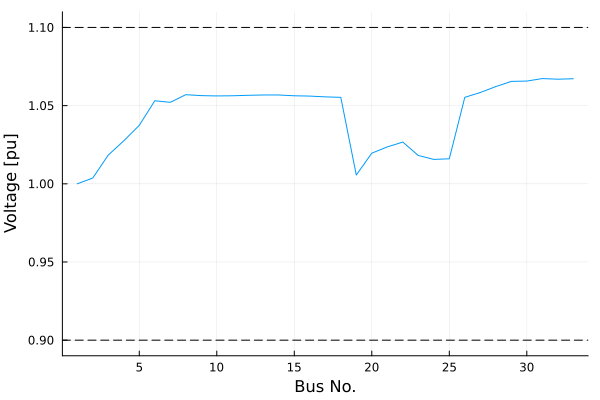

In [15]:
voltage=  XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/v2Revisedversionv0_hour14_1.xlsx", "v2Revisedversionv0_hour14_1","A2:A34")
voltage = vec(voltage)


using Plots
plot(legend = false, ylims=(0.89, 1.11), xlabel="Bus No.", ylabel="Voltage [pu]")
plot!(1:33, voltage, label=false) 
hline!([1.1, 0.9], color=:black, linestyle=:dash, label=false)

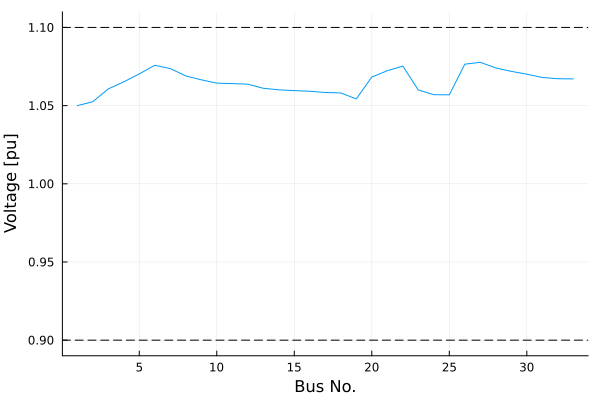

In [16]:
voltage=  XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/v2Revisedversion_hour14_0.1.xlsx", "v2Revisedversion_hour14_0.1","A2:A34")
voltage = vec(voltage)


using Plots
plot(legend = false, ylims=(0.89, 1.11), xlabel="Bus No.", ylabel="Voltage [pu]")
plot!(1:33, voltage, label=false) 
hline!([1.1, 0.9], color=:black, linestyle=:dash, label=false)


# M_f

In [ ]:
htime = 1

epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_1 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_1,  mue_epsilon)
end
allepsilons_1

In [ ]:

htime = 2

epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_2 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_2,  mue_epsilon)
end
allepsilons_2

In [ ]:

htime = 3
epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_3 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_3,  mue_epsilon)
end
allepsilons_3

In [ ]:

htime = 4
epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_4 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_4,  mue_epsilon)
end
allepsilons_4

In [ ]:

htime = 5

epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_5 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_5,  mue_epsilon)
end
allepsilons_5

In [ ]:

htime = 6
epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_6 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_6,  mue_epsilon)
end
allepsilons_6

In [ ]:

htime = 7

epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_7 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_7,  mue_epsilon)
end
allepsilons_7

In [ ]:

htime = 8
epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_8 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_8,  mue_epsilon)
end
allepsilons_8

In [ ]:

htime = 9
epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_9 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_9,  mue_epsilon)
end
allepsilons_9

In [ ]:

htime = 10
epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_10 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_10,  mue_epsilon)
end
allepsilons_10

In [ ]:

htime = 11
epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_11 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_11,  mue_epsilon)
end
allepsilons_11

In [ ]:

htime = 12

epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
epsilon_values=[1.0,0.1,0.01,0.005,0.001,0.0001]
allepsilons_12 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_12,  mue_epsilon)
end
allepsilons_12

In [ ]:

htime = 13

epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
allepsilons_13 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_13,  mue_epsilon)
end
allepsilons_13

In [ ]:

htime = 14
epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
allepsilons_14 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_14,  mue_epsilon)
end
allepsilons_14

In [ ]:

htime = 15

epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
allepsilons_15 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_15,  mue_epsilon)
end
allepsilons_15

In [ ]:

htime = 16

epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
allepsilons_16 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_16,  mue_epsilon)
end
allepsilons_16

In [ ]:

htime = 17

epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
allepsilons_17 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_17,  mue_epsilon)
end
allepsilons_17

In [ ]:

htime = 18
epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
allepsilons_18 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_18,  mue_epsilon)
end
allepsilons_18

In [ ]:

htime = 19

epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
allepsilons_19 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_19,  mue_epsilon)
end
allepsilons_19

In [ ]:

htime = 20

epsilon_values=[0.1,0.01,0.005,0.001,0.0001]
allepsilons_20 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "v2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_20,  mue_epsilon)
end
allepsilons_20

# Grid search for htime = 19

In [ ]:
htime = 19

In [ ]:
#function run_optimization(epsilon)
    function run_optimization(epsilon)
    n_clusters = 5
#     ϵ = zeros(Float64, n_clusters)
#     for i in 1:n_clusters
#         ϵ[i] = epsilon
#     end 
    
     ϵ = [0.01,0.01,0.01,0.01,0.01]
     ϵ[2]=epsilon
    
    model = Model(SCS.Optimizer)
##############################################################
    n_clusters = 5
    N =nbuses
    D = n_clusters
    o= n_clusters
    Nprime = n_samples
    Vmax=1.1
    Vmin=0.9
    eta1 =0.05
    eta=0.05
    er=[]
    for j in 1:n_clusters
        er1= length(clusters[j])
        push!(er,er1)
    end    
    maximum(er)# the number of buses in the cluster which has the maximum buses
############################################################
    @variable(model,0 <= alpha[n=1:nbuses] <= 1) #variable for fraction of active power curtailed by RES
    @variable(model, qc[n=1:nPVs] ) #variable for reactive power provided by RES
    @variable(model, 0 <= pb[n=1: nenergy_storage_systems]) #variable for rate of (dis)charge for energy storage 
    # @variable(model, bb[n=1: nenergy_storage_systems]>= 0) #variable for state of charge of energy storage
    @variable(model, y1[n=1:nPVs] >=0)
    @variable(model, y2[n=1:nPVs] >=0)
    
    
    #auxillary variables for wc exp. cost reformulation
    @variable(model, λ_co[f=1:D] >=0)
    @variable(model, s_co1[n=1:N, i = 1:Nprime] >=0)
    @variable(model, s_co2[n=1:N, i = 1:Nprime] >=0)
    #@variable(model, S_cost[f=1:D, i=1:Nprime])
#     @variable(model, q[f=1:D, i=1:Nprime])
#     @variable(model, U[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
#     @variable(model, L[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    # auxillary variables for CVaR reformulation
    @variable(model, varphi <=0)
    @variable(model, gamma[n=1:N] <=0)
    
    #DEFINE MATRISES
####################################################################    
        A = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            aa = Array{AffExpr}(undef, nbuses, delta_size)
            for n in 1:nbuses
                for j in 1:cluster_size 
                    first =  R[n,cluster[j]]*(1-alpha[cluster[j]])
                    second=  -R[n,cluster[j]]
                    third = -B[n,cluster[j]]
                    # Add elements to the corresponding positions in the matrix A
                    aa[n,(j-1)*3+1] = first
                    aa[n,(j-1)*3+2] = second
                    aa[n,(j-1)*3+3] = third
                end
            end
            push!(A, aa)
        end
######################################################################
        AJ=vcat(A,-A,generalobj1)
         #a_prime= zeros(2*nbuses+1,n_clusters,3*maximum(er))
        a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
        for i in 1:(2*nbuses+1)
            for j in 1:n_clusters
                for k in 1:3*maximum(er)
                    a_prime[i, j, k] = @expression(model, 0)
                end
            end
        end
        #a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
        for b in 1:length(AJ)
            for c in 1:n_buses
                if b < n_clusters+1
                    if 3*length(clusters[b]) == 3*maximum(er)
                        for d in 1:3*maximum(er)
                            a_prime[c,b,d] = AJ[b][c,:][d]
                        end   
                    else
                        for d in 1:3*maximum(er)
                            if d < 3*length(clusters[b])+1
                                a_prime[c,b,d] = AJ[b][c,:][d]
                            else
                                a_prime[c,b,d]=0
                            end    
                        end    
                    end
                elseif b > n_clusters && b < 2*n_clusters+1 
                    if 3*length(clusters[b - n_clusters]) == 3*maximum(er)
                         for d in 1:3*maximum(er)
                             a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                         end   
                    else
                        for d in 1:3*maximum(er)
                            if d < 3*length(clusters[b - n_clusters])+1
                                a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                            else
                                 a_prime[c + nbuses,b - n_clusters,d]=0
                            end    
                         end  
                    end    
                else
                    if c == 1
                        if 3*length(clusters[b - 2*n_clusters]) == 3*maximum(er)
                            for d in 1:3*maximum(er) 
                                a_prime[c + 2*nbuses,b - 2*n_clusters,d] = AJ[b][c,:][d]
                            end    
                        else
                             for d in 1:3*maximum(er)
                                if d < 3*length(clusters[b - 2*n_clusters])+1
                                     a_prime[c + 2*nbuses,b - 2*n_clusters,d] =  AJ[b - 2*n_clusters][c,:][d]
                                else
                                    a_prime[c + 2*nbuses,b - 2*n_clusters,d]=0
                                end    
                             end           
                         end
                    end
                 end
             end
        end    

    ######################################################################
    # THIS MATRIX IS CREATED FOR USING IN MATRIX M   
        generalobj2 = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            general2 = Array{AffExpr}(undef, 1, delta_size)
            for i in 1:1
                for j in 1:cluster_size
                    # p_av follows a normal distribution with mean 0 and std deviation of 10% of forecast
                    p_av_min = -c[cluster[j]]* (1-alpha[cluster[j]])+f[cluster[j]]*alpha[cluster[j]]
                    p_l_min=  c[cluster[j]] 
                    q_l_min = 0

                    general2[1,(j-1)*3+1] = p_av_min
                    general2[1,(j-1)*3+2] = p_l_min
                    general2[1,(j-1)*3+3] = q_l_min
                end
            end
            push!(generalobj2, general2)
        end
#######################################################################
    # matrix M
    # Initialize the matrix of vectors
    M = Array{Array{AffExpr, 1}}(undef, n_clusters, n_clusters)
    for i in 1:n_clusters
        for j in 1:n_clusters
            if i == j
                # If deltas_min[i] is already a vector, transpose and then convert to vector
                M[i, j] = vec(generalobj2[i])
            else
                M[i, j] = vec(zeros(1, 3 * length(clusters[j])))
            end
        end
    end
#################################################################


#########################################################
    @expression(model, b_first[t=1:nbuses], -R[t,:]'*pb +B[t,:]'*qc +a[t] - Vmax -varphi)
    @expression(model, b_second[t=1:nbuses], R[t,:]'*pb - B[t,:]'*qc -a[t] + Vmin -varphi)
    @expression(model, b_third_1[t=1:nbuses], qc[t]^2 - dfpv_pu[t, :S]^2 - gamma[t])
    b_third_0= zeros(Float64, nbuses)
#*    @expression(model, v[n=1:nbuses],  A_filtered[n,:]'*sigma_hat_filtered_second_samples -R[n,:]'*pb +B[n,:]'*qc +a[n])# the definition of voltage in our model
    @expression(model, voltage[n=1:nbuses], sum(dot(A[f][n,:], deltas_min[f]) for f in 1:D) -R[n,:]'*pb +B[n,:]'*qc +a[n])# the definition of voltage in our model
    @expression(model, c_prime[i=1:2*nbuses+1], 
    if i <= nbuses
        b_first[i]  # The first 33 elements from b_first
    elseif i <= 2 * nbuses
        b_second[i - nbuses]  # The next 33 elements from b_second
    else
        0  # The 67th element is zero
    end
)
    @variable(model, varpi) 
    @variable(model, psi[n=1:N]) 
    ########################
    @variable(model, λ_cc[f=1:D] >=0) #related to constraint v[t] >= buses[t].Vmin and  v[t] =< buses[t].Vmax
    @variable(model, λ_third_cc[n=1:N ] >=0) # related to constraint ((1-alpha[PV.index])*pavs[PV.index])^2 + (qc[PV.index])^2 <= (PV.S)^2
    ##################
    @variable(model, P_cc[i=1:Nprime]>=0 )
    @variable(model, P[k=1:2*nbuses+1,f=1:D, i=1:Nprime] >=0)
    @variable(model, z[ k=1:2*nbuses+1,f=1:D, i=1:Nprime])
    @variable(model, u[ k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    @variable(model, l[ k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    ######################
    @variable(model, Z_cc[n=1:N, i=1:Nprime]>=0)
    #*#@variable(model, Z[n=1:N, f=1:D, i=1:Nprime])
     ###############
    @constraint(model,absolute[n=1:N] , qc[n] == y1[n] - y2[n]) 
    #Deterministic constraints
    for energy_storage_system in energy_storage_systems
    @constraint(model, pb[energy_storage_system.index] <= energy_storage_system.Pbmax) #Upper limit constraint for storage device
    @constraint(model, pb[energy_storage_system.index] >= -energy_storage_system.Pbmax)#Lower limit constraint for storage device
    end
    #Worst-case exp. cost aux. constraints
#     @constraint(model, mu_up[f=1:D, i=1:Nprime], S_cost[f,i] >= sum( q[f,i]*deltas_hat[f][m,:][i] + (U[f,m,i] * deltas_max[f][m] -L[f,m,i]* deltas_min[f][m]) for m in 1:3*length(clusters[f]))) 
#     @constraint(model, mu_lo[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime], sum(M[o,:][f][m] for o in 1:D) - q[f,i] == U[f,m,i]- L[f,m,i])
#     @constraint(model, mu_av[f=1:D, i=1:Nprime],  q[f,i] >= -λ_cost[f])
#     @constraint(model, mu_av2[f=1:D, i=1:Nprime],  q[f,i] <= λ_cost[f])
    # CVaR reformulation of chance constraints
    @constraint(model, 0 >=varpi + varphi)
    @constraint(model,cvar_third[n=1:N],0 >= psi[n] + gamma[n])
    ###################################3
    constraint_ref = @constraint(model, eta1*varpi >= sum(λ_cc[f] * ϵ[f] for f in 1:D) + (1/Nprime) * sum(P_cc[i] for i in 1:Nprime))
    @constraint(model, DD1[k=1:2*nbuses+1, i=1:Nprime], P_cc[i] >= c_prime[k] + sum(P[k,f,i] for f in 1:D))
    @constraint(model, rhof1_up[k=1:2*nbuses+1, f=1:D, i=1:Nprime], P[k,f,i] >=  sum( z[k,f,i]*deltas_hat[f][m,:][i] + (u[k,f,m,i] * deltas_max[f][m] -l[k,f,m,i]* deltas_min[f][m]) for m in 1:3*length(clusters[f])))  
    @constraint(model, rhof1_lo[k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime], a_prime[k,f,m]-z[k,f,i] == u[k,f,m,i]- l[k,f,m,i])
    @constraint(model, rhof1_av[k=1:2*nbuses+1, f=1:D, i=1:Nprime],    z[k,f,i] >= -λ_cc[f])
    @constraint(model, rhof1_av2[k=1:2*nbuses+1, f=1:D, i=1:Nprime],  z[k,f,i] <= λ_cc[f])
    ###########################################
    for n in 1:nbuses
        if dfpv_pu[n, :S] == 0.0
            @constraint(model, alpha[n]==0)
        end
    end

    
    constraint_refs = []
    for n in 1:nbuses
        if dfpv_pu[n, :S] != 0.0
            for cluster in clusters
                s_r= zeros(1,3*length(cluster))
                for j in 1:length(cluster)
                    if cluster[j] == n
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        s_r[1,(j-1)*3+1]=1
                        main_constraint_ref = @constraint(model,  eta * psi[n] >= λ_third_cc[n] * ϵ[indxofcluster]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
                        for i in 1:Nprime
                        @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*dot(s_r,deltas_max[indxofcluster]))^2 - λ_third_cc[n]*(dot(s_r,deltas_max[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*(s_r*deltas_hat[indxofcluster])[i])^2)
                        #@constraint(model, Z_cc[n,i] >= -λ_third_cc[n] *(dot(s_r,deltas_max[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        # @constraint(model, Z_cc[n,i] >= λ_third_cc[n] *(dot(s_r,deltas_min[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        @constraint(model, Z_cc[n,i] >= 0)
                        end
                        push!(constraint_refs, main_constraint_ref)
                    end
                 end
             end 
        end   
     end
     
    
    
  
    
    obj_refs = []
    obj_refs2=[]
    for n in 1:nbuses
            totaltotal = 0 
            for cluster in clusters
                for j in 1:length(cluster)
                    if cluster[j] == n
                        r_n= zeros(1,3*length(cluster))
                        m_n= zeros(1,3*length(cluster))
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        m_n[1,(j-1)*3+1]=1
                        r_n[1,(j-1)*3+2]=1
                        #main_constraint_ref = @constraint(model,  eta * psi[n] >= λ_third_cc[n] * ϵ[indxofcluster]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
                        total1 = 0
                        total2=0
                        for i in 1:Nprime
                        @constraint(model, s_co1[n,i] >= c[n]*(dot(r_n,deltas_max[indxofcluster]) - (1-alpha[n])* (dot(m_n,deltas_min[indxofcluster])) + pb[n]) - λ_co[indxofcluster]*((dot(r_n,deltas_max[indxofcluster]) - (r_n*deltas_hat[indxofcluster])[i]) - (dot(m_n,deltas_min[indxofcluster]) - (m_n*deltas_hat[indxofcluster])[i])) )
                        @constraint(model, s_co1[n,i] >= d[n]*(-dot(r_n,deltas_min[indxofcluster]) + (1-alpha[n])* (dot(m_n,deltas_max[indxofcluster])) - pb[n]) - λ_co[indxofcluster]*((- dot(r_n,deltas_min[indxofcluster]) + (r_n*deltas_hat[indxofcluster])[i]) + (dot(m_n,deltas_max[indxofcluster]) - (m_n*deltas_hat[indxofcluster])[i])))
                        @constraint(model, s_co1[n,i] >= c[n]* ((r_n*deltas_hat[indxofcluster])[i]- (1-alpha[n])*(m_n*deltas_hat[indxofcluster])[i] + pb[n]))
                        @constraint(model, s_co1[n,i] >= d[n]* (-(r_n*deltas_hat[indxofcluster])[i]+ (1-alpha[n])*(m_n*deltas_hat[indxofcluster])[i] - pb[n]))
                        @constraint(model, s_co1[n,i] >= 0)
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]*(dot(m_n,deltas_max[indxofcluster])) - λ_co[indxofcluster]*(dot(m_n,deltas_max[indxofcluster])- (m_n*deltas_hat[indxofcluster])[i] ))
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]*(dot(m_n,deltas_min[indxofcluster])) + λ_co[indxofcluster]*(dot(m_n,deltas_min[indxofcluster])- (m_n*deltas_hat[indxofcluster])[i] ))
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]* ((m_n*deltas_hat[indxofcluster])[i]))
                        @constraint(model, s_co2[n,i] >= 0)
                        total1 += s_co1[n,i]
                        total2 += s_co2[n,i]
                        end
                        push!(obj_refs, (1/Nprime) * total1)
                        push!(obj_refs2, (1/Nprime) * total2)
                    end
                 end
             end  
     end
     
    
    
    
    
    
    
    


#*    for n in 1:nbuses
#*        if dfpv_pu[n, :S] != 0.0
#*            @constraint(model,  eta * gamma[n] >= λ_third_cc[n] * ϵj[n]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
#*            for i in 1:Nprime
#*                 @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*sigma_max[n])^2 - λ_third_cc[n]*(sigma_max[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*sigma_hat[n][i])^2)
#*                 @constraint(model, Z_cc[n,i] >= -λ_third_cc[n] *(sigma_max[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= λ_third_cc[n] *(sigma_min[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= 0)
#*            end   
#*        end
#*     end 
    #objective
    expcost = sum(λ_co[f]*ϵ[f] for f in 1:D)  + sum( obj_refs[n] + obj_refs2[n]  for n in 1:N) + sum(( e[n]* (y1[n]+y2[n])) for n in 1:N )
    @objective(model, Min,expcost)
    optimize!(model)
    obj_value = JuMP.objective_value(model)
v_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:voltage])]
qc_opt = [round(x, digits=4) for x in value.(model[:qc])]
alpha_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:alpha])]
pb_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:pb])]
λ_cc_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_cc])]
λ_third_cc_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_third_cc])[pvuncer_loc]]
λ_cost_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_co])]
obj_value_opt = round(value.(obj_value), digits=4) 
    dual_value_cc = dual(constraint_ref)
    dual_value_inv=[]
    for ref in constraint_refs
        rr=zeros(length(pvuncer_loc),1)
        rr = dual(ref)
        push!(dual_value_inv,rr)
    end
    return v_opt,qc_opt, alpha_opt, pb_opt, λ_cc_opt, λ_third_cc_opt, λ_cost_opt, obj_value_opt,dual_value_cc,dual_value_inv
end

In [ ]:
epsilon_values=[0.01,0.005,0.001,0.0001]
# epsilon_values=[1]
for epsilon in epsilon_values
    result=run_optimization(epsilon)
    df_variables = DataFrame(  voltage= result[1], qc=  result[2], alpha=  result[3], pb= result[4])
    df_λ_cc= DataFrame(λ_cc= result[5])
    df_λ_third_cc= DataFrame(λ_third_cc =  result[6]) 
    df_λ_cost= DataFrame(λ_cost= result[7])
    df_objective= DataFrame(objective= result[8])
    df_dualcc= DataFrame(dualcc= result[9])
    df_dualinv= DataFrame(dualinv= result[10])
    ############## store the results for each epsilon in seperate excel files
    xlsx_file = XLSX.writetable("Grid_cluster2_hour$(htime)_$(epsilon).xlsx",df_variables, sheetname="Grid_cluster2_hour$(htime)_$(epsilon)")
    XLSX.openxlsx("Grid_cluster2_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        sheet = xf[1]
        XLSX.writetable!(sheet, df_objective, anchor_cell=XLSX.CellRef("E1"))
    end    
    XLSX.openxlsx("Grid_cluster2_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        sheet = xf[1]
        XLSX.writetable!(sheet, df_dualcc, anchor_cell=XLSX.CellRef("F1"))
    end  
    XLSX.openxlsx("Grid_cluster2_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "dualinv")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_dualinv)
    end
    XLSX.openxlsx("Grid_cluster2_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_cc")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_cc)
    end
    XLSX.openxlsx("Grid_cluster2_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_third_cc")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_third_cc)
    end
    XLSX.openxlsx("Grid_cluster2_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_cost")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_cost)
    end
end

# M_f for changing the epsilon for cluster 2 at time 15

In [ ]:


epsilon_values=[1]
allepsilons = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "Grid_cluster2_hour19_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "Grid_cluster2_hour19_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "Grid_cluster2_hour19_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "Grid_cluster2_hour19_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "Grid_cluster2_hour19_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/Grid_cluster2_hour19_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons,  mue_epsilon)
end
allepsilons

# ploting M_f for each f over 24 hours when epsilon is equal 0.01

In [ ]:
allm=(allepsilons_1,allepsilons_2,allepsilons_3,allepsilons_4,allepsilons_5,allepsilons_6,allepsilons_7,allepsilons_8,allepsilons_9,allepsilons_10,allepsilons_11,allepsilons_12,allepsilons_13,allepsilons_14,allepsilons_15,allepsilons_16,allepsilons_17,allepsilons_18,allepsilons_19,allepsilons_20,allepsilons_20,allepsilons_20,allepsilons_20,allepsilons_20)

In [ ]:
M_1_1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,2.0254,2.093,2.0234,0,1.95,1.346,0,0,0,0,0]


M_1_01=[]
for i in 1:24
    if i <13
    aa=allm[i][2][1]
    push!(M_1_01,aa)
    else
        aa=allm[i][1][1]
    push!(M_1_01,aa)
    end   
end
M_1_01[18] = 10.001



M_1_001= [9.9792,10.0091,9.9959,10.0039,9.9932,9.991,10.0018,10.0086,9.9994,9.9993,10.000664996517889,10.284066705325532,9.9956,11.114525014307226,10.920273409889278,11.048736082315147,9.9981,11.04428332809599,10.991601565911344,9.9961,9.9961,9.9961,9.9961,9.9961]




M_1_0005=[]
for i in 1:24
    if i <13
    aa=allm[i][4][1]
    push!(M_1_0005,aa)
    else
        aa=allm[i][3][1]
    push!(M_1_0005,aa)
    end   
end
M_1_0005


M_1_0001=[]
for i in 1:24
    if i <13
    aa=allm[i][5][1]
    push!(M_1_0001,aa)
    else
        aa=allm[i][4][1]
    push!(M_1_0001,aa)
    end   
end
M_1_0001


M_1_00001=[]
for i in 1:24
    if i <13
    aa=allm[i][6][1]
    push!(M_1_00001,aa)
    else
        aa=allm[i][5][1]
    push!(M_1_00001,aa)
    end   
end
M_1_00001

In [ ]:
hours = ["12 AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM", "6 AM", "7 AM", "8 AM", "9 AM", "10 AM", "11 AM", 
         "12 PM", "1 PM", "2 PM", "3 PM", "4 PM", "5 PM", "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11 PM"]

plot(M_1_00001, title="M_1 over 24 hours for epsilon=0.01", xlabel="hour", ylabel="M_1", legend=false, linewidth=2, marker=:circle,xticks = (1:24,hours),xrotation=45)

In [ ]:
M_2_01=[]
for i in 1:24
    if i <13
    aa=allm[i][2][2]
    push!(M_2_01,aa)
    else
        aa=allm[i][1][2]
    push!(M_2_01,aa)
    end   
end
M_2_01[18] = 10.001



M_2_001=[]
for i in 1:24
    if i <13
    aa=allm[i][3][2]
    push!(M_2_001,aa)
    else
        aa=allm[i][2][2]
    push!(M_2_001,aa)
    end   
end



M_2_0005=[]
for i in 1:24
    if i <13
    aa=allm[i][4][2]
    push!(M_2_0005,aa)
    else
        aa=allm[i][3][2]
    push!(M_2_0005,aa)
    end   
end
M_2_0005


M_2_0001=[]
for i in 1:24
    if i <13
    aa=allm[i][5][2]
    push!(M_2_0001,aa)
    else
        aa=allm[i][4][2]
    push!(M_2_0001,aa)
    end   
end
M_2_0001


M_2_00001=[]
for i in 1:24
    if i <13
    aa=allm[i][6][2]
    push!(M_2_00001,aa)
    else
        aa=allm[i][5][2]
    push!(M_2_00001,aa)
    end   
end
M_2_00001

In [ ]:

hours = ["12 AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM", "6 AM", "7 AM", "8 AM", "9 AM", "10 AM", "11 AM", 
         "12 PM", "1 PM", "2 PM", "3 PM", "4 PM", "5 PM", "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11 PM"]

plot(M_2_00001, title="M_2 over 24 hours for epsilon=0.01", xlabel="Time of Day", ylabel="M_2", legend=false, linewidth=2, marker=:circle)

In [ ]:
using Plots

M_2all= plot(1:24, [M_2_01,M_2_001,M_2_0005,M_2_0001,M_2_00001], label=["ε = 0.1" "ε = 0.01" "ε = 0.005"  "ε = 0.001" "ε = 0.0001"], color=[:orange :blue :red :green :purple :brown],
     xticks=(1:24, hours), xlabel="Time of Day", ylabel="\u03bc_1", linewidth=2.5, legend=:topleft, xrotation=45)
 M_1all= plot(1:24, [M_1_1,M_1_01,M_1_001,M_1_0005,M_1_0001,M_1_00001], label=["ε = 1" "ε = 0.1" "ε = 0.01" "ε = 0.005"  "ε = 0.001" "ε = 0.0001"], color=[:orange :blue :red :green :purple :brown],
     xticks=(1:2:24, ["12 AM","2 AM" , "4 AM", "6 AM", "8 AM"  
        ,"10 AM", "12 PM", "2 PM", "4 PM","6 PM",  "8 PM","10 PM", "12 AM"]), xlabel="Time of Day", ylabel="\u03bc_1", linewidth=2.5,xguidefontsize=18,yguidefontsize=18, legend=:outerbottom,legend_columns=3,legendfontsize=18,xrotation=45,size=(700,700))
xaxis!(tickfontsize=17)
plot!(margins = 0mm)
savefig(M_1all, "/Users/ebrah/Mehrnoush/m1.pdf")

In [ ]:
hours

In [ ]:
allM1over24at01=[]
for i in 1:24
    if i <13
        aa=allm[i][2][1]
        push!(allM1over24at01,aa)
    else
        aa=allm[i][1][1]
        push!(allM1over24at01,aa)
    end
end
allM1over24at01


allM2over24at01=[]
for i in 1:24
    if i <13
        aa=allm[i][2][2]
        push!(allM2over24at01,aa)
    else
        aa=allm[i][1][2]
        push!(allM2over24at01,aa)
    end
end
allM2over24at01


allM3over24at01=[]
for i in 1:24
    if i <13
        aa=allm[i][2][3]
        push!(allM3over24at01,aa)
    else
        aa=allm[i][1][3]
        push!(allM3over24at01,aa)
    end
end
allM3over24at01



allM4over24at01=[]
for i in 1:24
    if i <13
        aa=allm[i][2][4]
        push!(allM4over24at01,aa)
    else
        aa=allm[i][1][4]
        push!(allM4over24at01,aa)
    end
end
allM4over24at01


allM5over24at01=[]
for i in 1:24
    if i <13
        aa=allm[i][2][5]
        push!(allM5over24at01,aa)
    else
        aa=allm[i][1][5]
        push!(allM5over24at01,aa)
    end
end
allM5over24at01




################

allM1over24at001=[]
for i in 1:24
    if i <13
        aa=allm[i][3][1]
        push!(allM1over24at001,aa)
    else
        aa=allm[i][2][1]
        push!(allM1over24at001,aa)
    end
end
allM1over24at001


allM2over24at001=[]
for i in 1:24
    if i <13
        aa=allm[i][3][2]
        push!(allM2over24at001,aa)
    else
        aa=allm[i][2][2]
        push!(allM2over24at001,aa)
    end
end
allM2over24at001


allM3over24at001=[]
for i in 1:24
    if i <13
        aa=allm[i][3][3]
        push!(allM3over24at001,aa)
    else
        aa=allm[i][2][3]
        push!(allM3over24at001,aa)
    end
end
allM3over24at001



allM4over24at001=[]
for i in 1:24
    if i <13
        aa=allm[i][3][4]
        push!(allM4over24at001,aa)
    else
        aa=allm[i][2][4]
        push!(allM4over24at001,aa)
    end
end
allM4over24at001


allM5over24at001=[]
for i in 1:24
    if i <13
        aa=allm[i][3][5]
        push!(allM5over24at001,aa)
    else
        aa=allm[i][2][5]
        push!(allM5over24at001,aa)
    end
end
allM5over24at001

################







allM1over24at0005=[]
for i in 1:24
    if i <13
        aa=allm[i][4][1]
        push!(allM1over24at0005,aa)
    else
        aa=allm[i][3][1]
        push!(allM1over24at0005,aa)
    end
end
allM1over24at0005


allM2over24at0005=[]
for i in 1:24
    if i <13
        aa=allm[i][4][2]
        push!(allM2over24at0005,aa)
    else
        aa=allm[i][3][2]
        push!(allM2over24at0005,aa)
    end
end
allM2over24at0005


allM3over24at0005=[]
for i in 1:24
    if i <13
        aa=allm[i][4][3]
        push!(allM3over24at0005,aa)
    else
        aa=allm[i][3][3]
        push!(allM3over24at0005,aa)
    end
end
allM3over24at0005



allM4over24at0005=[]
for i in 1:24
    if i <13
        aa=allm[i][4][4]
        push!(allM4over24at0005,aa)
    else
        aa=allm[i][3][4]
        push!(allM4over24at0005,aa)
    end
end
allM4over24at0005


allM5over24at0005=[]
for i in 1:24
    if i <13
        aa=allm[i][4][5]
        push!(allM5over24at0005,aa)
    else
        aa=allm[i][3][5]
        push!(allM5over24at0005,aa)
    end
end
allM5over24at0005


######################





allM1over24at0001=[]
for i in 1:24
    if i <13
        aa=allm[i][5][1]
        push!(allM1over24at0001,aa)
    else
        aa=allm[i][4][1]
        push!(allM1over24at0001,aa)
    end
end
allM1over24at0001


allM2over24at0001=[]
for i in 1:24
    if i <13
        aa=allm[i][5][2]
        push!(allM2over24at0001,aa)
    else
        aa=allm[i][4][2]
        push!(allM2over24at0001,aa)
    end
end
allM2over24at0001


allM3over24at0001=[]
for i in 1:24
    if i <13
        aa=allm[i][5][3]
        push!(allM3over24at0001,aa)
    else
        aa=allm[i][4][3]
        push!(allM3over24at0001,aa)
    end
end
allM3over24at0001



allM4over24at0001=[]
for i in 1:24
    if i <13
        aa=allm[i][5][4]
        push!(allM4over24at0001,aa)
    else
        aa=allm[i][4][4]
        push!(allM4over24at0001,aa)
    end
end
allM4over24at0001


allM5over24at0001=[]
for i in 1:24
    if i <13
        aa=allm[i][5][5]
        push!(allM5over24at0001,aa)
    else
        aa=allm[i][4][5]
        push!(allM5over24at0001,aa)
    end
end
allM5over24at0001


##########




allM1over24at00001=[]
for i in 1:24
    if i <13
        aa=allm[i][6][1]
        push!(allM1over24at00001,aa)
    else
        aa=allm[i][5][1]
        push!(allM1over24at00001,aa)
    end
end
allM1over24at00001


allM2over24at00001=[]
for i in 1:24
    if i <13
        aa=allm[i][6][2]
        push!(allM2over24at00001,aa)
    else
        aa=allm[i][5][2]
        push!(allM2over24at00001,aa)
    end
end
allM2over24at00001


allM3over24at00001=[]
for i in 1:24
    if i <13
        aa=allm[i][6][3]
        push!(allM3over24at00001,aa)
    else
        aa=allm[i][5][3]
        push!(allM3over24at00001,aa)
    end
end
allM3over24at00001



allM4over24at00001=[]
for i in 1:24
    if i <13
        aa=allm[i][6][4]
        push!(allM4over24at00001,aa)
    else
        aa=allm[i][5][4]
        push!(allM4over24at00001,aa)
    end
end
allM4over24at00001


allM5over24at00001=[]
for i in 1:24
    if i <13
        aa=allm[i][6][5]
        push!(allM5over24at00001,aa)
    else
        aa=allm[i][5][5]
        push!(allM5over24at00001,aa)
    end
end
allM5over24at00001















In [ ]:
Mdifferent001= plot(1:24, [allM1over24at001,allM2over24at001,allM3over24at001,allM4over24at001,allM5over24at001], label=["1" "2" "3"  "4" "5"], color=[:orange :blue :red :green :purple ],
     xticks=(1:24, hours), xlabel="Time of Day", ylabel="\u03bc_f", linewidth=2.5, legend=:topleft, xrotation=45)

In [ ]:
using Plots

gr()  # Explicitly using GR backend

# ... (assuming your plotting data is defined earlier in the script)

# Create individual plots without a legend
p3 = plot(1:24, [allM1over24at001,allM2over24at001,allM3over24at001,allM4over24at001,allM5over24at001], color=[:orange :blue :red :green :purple],
     xticks=(1:2:24, ["12 AM","2 AM" , "4 AM", "6 AM", "8 AM", "10 AM", "12 PM", "2 PM", "4 PM","6 PM", "8 PM","10 PM", "12 AM"]),
     ylabel="\u03bc_f", title = "ε = 0.01", linewidth=2.5, legend=false, xguidefontsize=17, yguidefontsize=17, titlefontsize=17,xrotation=45, size=(800, 800))
xaxis!(tickfontsize=16)
p4 = plot(1:24, [allM1over24at0005,allM2over24at0005,allM3over24at0005,allM4over24at0005,allM5over24at0005], color=[:orange :blue :red :green :purple],
     xticks=(1:2:24, ["12 AM","2 AM" , "4 AM", "6 AM", "8 AM", "10 AM", "12 PM", "2 PM", "4 PM","6 PM", "8 PM","10 PM", "12 AM"]),
     ylabel="\u03bc_f",title = "ε = 0.005", linewidth=2.5, legend=false, xguidefontsize=17, yguidefontsize=17,titlefontsize=17,xrotation=45, size=(800, 800))
xaxis!(tickfontsize=16)
# The last plot includes the legend
p5 = plot(1:24, [allM1over24at0001,allM2over24at0001,allM3over24at0001,allM4over24at0001,allM5over24at0001], label=["f=1" "f=2" "f=3" "f=4" "f=5"], color=[:orange :blue :red :green :purple],
     xticks=(1:2:24, ["12 AM","2 AM" , "4 AM", "6 AM", "8 AM", "10 AM", "12 PM", "2 PM", "4 PM","6 PM", "8 PM","10 PM", "12 AM"]),
     xlabel="Time of Day", title = "ε = 0.001", ylabel="\u03bc_f", linewidth=2.5, xguidefontsize=17, yguidefontsize=17, xrotation=45,legend_columns=5,legend=(0.2, -0.99),bottom_margin=12mm,legendfontsize=17,titlefontsize=17,size=(900, 1000))
xaxis!(tickfontsize=16)
# Combine the plots into a single layout
combined_plots = plot(p3, p4, p5, layout=(3, 1), size=(800, 900))
xaxis!(tickfontsize=16)
# Display the combined plot
display(combined_plots)

# Save the figure if necessary
savefig(combined_plots, "/Users/ebrah/Mehrnoush/threeepsilons5.pdf")


# Out of sample test


load data

In [25]:
# Assuming you've read your dataset into a DataFrame called df
df = CSV.read("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/data/loaddata/time_series_60min_singleindex - Copy.csv", DataFrame)
# Define the normalization function
function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names(df)
    if eltype(df[!, col_name]) <: Real
        df[!, col_name] = normalize_column!(df[!, col_name])
    end
end




# Define the format of your timestamps
dateformat = "yyyy-mm-dd\\THH:MM:SSZ"
# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("2015-01-02T00:00:00Z", dateformat)
end_time = DateTime("2015-01-03T00:00:00Z", dateformat)
df_24h = filter(row -> start_time <= DateTime(row[:utc_timestamp], dateformat) < end_time, df)
# Plot the load data
loadplot = plot(df_24h.utc_timestamp, df_24h.AT_load_actual_entsoe_transparency, label="Actual Load", xlabel="Time", ylabel="Load", title="Load Data for 24 Hours", xrotation=45) # Rotates X-axis labels to make them readable





Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1

cum24hourseachbus = []
for i in 1:33
    eachbus = df_24h.AT_load_actual_entsoe_transparency.* dfb[!,"Pd"][i].* 1e3.*0.5 ./ Sbase
    push!(cum24hourseachbus,eachbus)
end


# Plot the load data
loadplot = plot(df_24h.utc_timestamp, cum24hourseachbus[4], label="Actual Load", xlabel="Time", ylabel="Load", title="Load Data for 24 Hours", xrotation=45) # Rotates X-axis labels to make them readable


cumbuseachhour = []
for i in 1:24
    eachhour = df_24h.AT_load_actual_entsoe_transparency[i].* dfb[!,"Pd"].* 1e3.*0.5 ./ Sbase
    push!(cumbuseachhour,eachhour)
end    



cumbuseachhourreactiveload = []
for i in 1:24
    eachhourreactiveload = df_24h.AT_load_actual_entsoe_transparency[i].* dfb[!,"Qd"].* 1e3.*0.5 ./ Sbase
    push!(cumbuseachhourreactiveload,eachhourreactiveload )
end  

PV data

In [26]:
data_url = "https://raw.githubusercontent.com/mieth-robert/testdata/main/single_household_smart_home.csv"
response = HTTP.get(data_url)
smart_home_data = CSV.File(IOBuffer(response.body)) |> DataFrame


smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], "m/d/y H:M")
# Define the format of your timestamps
dateformat = "m/d/y H:M"


# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, smart_home_data)

# filter to get only the start of each hour
df_hourly = df_24h[minute.(df_24h[!, :local_15min]) .== 0, :]

# Plot the solar data
plt = plot(df_hourly.local_15min, df_hourly.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)




function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names( df_hourly)
    if eltype( df_hourly[!, col_name]) <: Real
         df_hourly[!, col_name] = normalize_column!( df_hourly[!, col_name])
    end
end



df_24h = filter(row -> start_time <= row[:local_15min] < end_time, df_hourly)
# Plot the solar data
solarplot = plot(df_24h.local_15min, df_24h.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)



#define voltage base and Sbase 
Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1
df_24h.solar[21] = 0.0005
cum24hourseachbuspv = []
for i in 1:33
    eachbuspv = df_24h.solar.* dfpv[!, :S][i].*2# Here we multiply each curve (24 hours) by a single value
    push!(cum24hourseachbuspv,eachbuspv)
end

cumbuseachhourpv = []
for i in 1:24
    eachhourpv = df_24h.solar[i].* dfpv[!, :S].*2 # Here we scale the system capacity for all 33 buses at one specific hour by multiplying the system capacity for all 33 buses by the amount of generated pv (curve) at one specific time. then we repeat it 24 hours for all hours. so we have 24 33-dimensional vectors.
    push!(cumbuseachhourpv,eachhourpv)
end    
cumbuseachhourpv[10][:]

cumbuseachhourpv = cumbuseachhourpv.* 1e3 ./ Sbase

24-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.00028328611898017006, 0.0, 0.00028328611898017006, 0.000424929178470255, 0.0, 0.000226628895184136, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.000339943342776204, 0.0, 0.000169971671388102, 0.0, 0.000453257790368272]
 [0.0, 0.0, 0.00028328611898017006, 0.0, 0.00028328611898017006, 0.000424929178470255, 0.0, 0.000226628895184136, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.000339943342776204, 0.0, 0.000169971671388102, 0.0, 0.000453257790368272]
 [0.0, 0.0, 0.00028328611898017006, 0.0, 0.00028328611898017006, 0.000424929178470255, 0.0, 0.000226628895184136, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.000339943342776204, 0.0, 0.000169971671388102, 0.0, 0.000453257790368272]
 [0.0, 0.0, 0.00028328611898017006, 0.0, 0.00028328611898017006, 0.000424929178470255, 0.0, 0.000226628895184136, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.00033994334277620

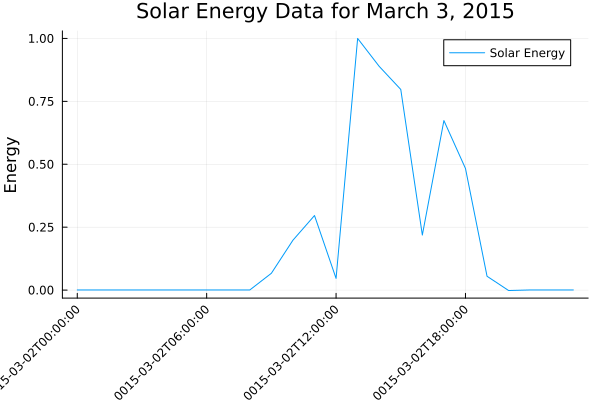

In [27]:
plt = plot(df_hourly.local_15min, df_hourly.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)

In [28]:
S_per_time_pu=cumbuseachhourpv

24-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.00028328611898017006, 0.0, 0.00028328611898017006, 0.000424929178470255, 0.0, 0.000226628895184136, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.000339943342776204, 0.0, 0.000169971671388102, 0.0, 0.000453257790368272]
 [0.0, 0.0, 0.00028328611898017006, 0.0, 0.00028328611898017006, 0.000424929178470255, 0.0, 0.000226628895184136, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.000339943342776204, 0.0, 0.000169971671388102, 0.0, 0.000453257790368272]
 [0.0, 0.0, 0.00028328611898017006, 0.0, 0.00028328611898017006, 0.000424929178470255, 0.0, 0.000226628895184136, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.000339943342776204, 0.0, 0.000169971671388102, 0.0, 0.000453257790368272]
 [0.0, 0.0, 0.00028328611898017006, 0.0, 0.00028328611898017006, 0.000424929178470255, 0.0, 0.000226628895184136, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.00033994334277620

In [29]:
# Function to adjust and format numbers, keeping them as numbers
function adjust_and_format_number(num)
    if abs(num) < 1e-4
        return 0.0
    else
        return round(num, digits=4)
    end
end

# Apply the function to each number in the vector pvcum
cumbuseachhourpv = map(sublist -> map(adjust_and_format_number, sublist), cumbuseachhourpv)

# Displaying a sample from the result
println(cumbuseachhourpv[10])

# Apply the same process for other vectors
cumbuseachhour = map(sublist -> map(adjust_and_format_number, sublist), cumbuseachhour)
println(cumbuseachhour[10])

cumbuseachhourreactiveload = map(sublist -> map(adjust_and_format_number, sublist), cumbuseachhourreactiveload)
println(cumbuseachhourreactiveload[10])


[0.0, 0.0, 0.0334, 0.0, 0.0334, 0.0501, 0.0, 0.0267, 0.0, 0.0, 0.0501, 0.0535, 0.0, 0.0134, 0.0, 0.0334, 0.0134, 0.0334, 0.0134, 0.0, 0.0334, 0.0334, 0.0134, 0.0, 0.0201, 0.0, 0.0401, 0.0, 0.0401, 0.0, 0.0201, 0.0, 0.0535]
[0.0, 0.0486, 0.0438, 0.0583, 0.0292, 0.0292, 0.0972, 0.0972, 0.0292, 0.0292, 0.0219, 0.0292, 0.0292, 0.0583, 0.0292, 0.0292, 0.0292, 0.0438, 0.0438, 0.0438, 0.0438, 0.0438, 0.0438, 0.2042, 0.2042, 0.0292, 0.0292, 0.0292, 0.0583, 0.0972, 0.0729, 0.1021, 0.0292]
[0.0, 0.0292, 0.0194, 0.0389, 0.0146, 0.0097, 0.0486, 0.0486, 0.0097, 0.0097, 0.0146, 0.017, 0.017, 0.0389, 0.0049, 0.0097, 0.0097, 0.0194, 0.0194, 0.0194, 0.0194, 0.0194, 0.0243, 0.0972, 0.0972, 0.0122, 0.0122, 0.0097, 0.034, 0.2917, 0.034, 0.0486, 0.0194]


In [30]:
# define location of files

htime= 14

#define voltage base and Sbase 
Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1

#convert impedances from Ohms to p.u. - loads from kW to pu - battery data from kw to pu - pv data from kw to pu
dfb_pu = DataFrame()
for row in eachrow(dfb)
    newdfb = (index=row.index, Node = row.Node, Pd=row.Pd .* 1e3.*0.5 ./ Sbase, Qd=row.Qd.*0.5 .* 1e3 ./ Sbase, Vmax=1.1, Vmin=0.9, r=row.r ./(Vbase^2 / Sbase), x=row.x ./(Vbase^2 / Sbase), b= row.b)
    push!(dfb_pu, newdfb)
end

dfl_pu = DataFrame()
for row in eachrow(dfl)
    newdfl = (index=row.index, to = row.to , from=row.from , r=row.r ./  (Vbase^2 / Sbase), x=row.x ./ (Vbase^2 / Sbase), b=row.b, s=row.s, g = row.g)
    push!(dfl_pu, newdfl)
end

dfbat_pu = DataFrame()
for row in eachrow(dfbat)
    newdfbat = (index=row.index, Node = row.Node , bmax=row.bmax .* 1e3 ./ Sbase , pmax=row.pmax .* 1e3 ./ Sbase )
    push!(dfbat_pu, newdfbat)
end

dfpv_pu = DataFrame()
for row in eachrow(dfpv)
    newdfpv = (index=row.index, Node = row.Node , S = row.S .* 1e3.*2 ./ Sbase )
    push!(dfpv_pu, newdfpv)
end


# bring the data in a more useable form
println(">>> preparing data")
buses = []
for row in eachrow(dfb_pu)
    newbus = (index=row.index, ancestor=[], children=[], pd=row.Pd, qd=row.Qd, Vmax=row.Vmax, Vmin = row.Vmin)
    push!(buses, newbus)
end

lines = []
for row in eachrow(dfl_pu)
    newline = (index=row.index, r=row.r, x=row.x, from=row.to, to=row.from)
    push!(buses[newline.to].ancestor, newline.from)
    push!(buses[newline.from].children, newline.to)
    push!(lines, newline)
end

PVs = []
for row in eachrow(dfpv_pu)
    newPV = (index=row.index, S=row.S)
    push!(PVs, newPV)
end

energy_storage_systems = []
for row in eachrow(dfbat_pu)
    newenergy_storage_system = (index=row.index, Pbmax=row.pmax,Bmax = row.bmax )
    push!(energy_storage_systems, newenergy_storage_system)
end

nbuses = length(buses)
nlines = length(lines)
nPVs = length(PVs)
nenergy_storage_systems = length(energy_storage_systems)

# now compute the same thing in the matrix form
println(">>> compute matrizes")
# define A matrix (with substation bus!)
A = zeros(length(lines), length(buses))
for bus in buses
    a = bus.index
    while a != 1
        A[a-1, bus.index] = 1
        a = buses[a].ancestor[1]
    end
end

# define load active and reactive power vectors
pl= cumbuseachhour[htime]
ql = cumbuseachhourreactiveload[htime]
pav_pu = cumbuseachhourpv[htime]




# Random.seed!(123)
# random_factors = 1 .* rand(length(dfpv[!, :S])) 
# pav = random_factors .* dfpv[!, :S]
# pav_pu=pav .* 1e3 ./ Sbase 
######################################



# define power generation vectors
#Random.seed!(123)
#pav = rand(length(dfpv_pu[!, :S])) .* dfpv_pu[!, :S] # Generate random scaling factors between 0 and 1 and then Scale the values between 0 and 100%

#pavs = pav .* 5

# set substation voltage
u_0 = 1

# define remaining matrizes
diag_r = Diagonal([line.r for line in lines])
diag_x = Diagonal([line.x for line in lines])
R = 2*A'*diag_r*A
B = 2*A'*diag_x*A
a = ones(nbuses) .* u_0 


# define parameters relatedd to the price
c = fill(10, nbuses) #the price associated with the power consumed by the customers
d= fill(3, nbuses) # the feed-in tariff cost to the utility
e= fill(30, nbuses) # the cost of reactive power injection/absorption from the inverters
f= fill(6,nbuses) # the cost of active power curtailment

>>> preparing data
>>> compute matrizes


33-element Vector{Int64}:
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 ⋮
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6

In [31]:
forecast_values = hcat(pav_pu,pl,ql)

33×3 Matrix{Float64}:
 0.0   0.0     0.0
 0.0   0.0458  0.0275
 0.5   0.0412  0.0183
 0.0   0.0549  0.0366
 0.5   0.0275  0.0137
 0.75  0.0275  0.0092
 0.0   0.0916  0.0458
 0.4   0.0916  0.0458
 0.0   0.0275  0.0092
 0.0   0.0275  0.0092
 0.75  0.0206  0.0137
 0.8   0.0275  0.016
 0.0   0.0275  0.016
 ⋮             
 0.5   0.0412  0.0183
 0.2   0.0412  0.0229
 0.0   0.1923  0.0916
 0.3   0.1923  0.0916
 0.0   0.0275  0.0114
 0.6   0.0275  0.0114
 0.0   0.0275  0.0092
 0.6   0.0549  0.032
 0.0   0.0916  0.2747
 0.3   0.0687  0.032
 0.0   0.0961  0.0458
 0.8   0.0275  0.0183

In [32]:
# Function to create clusters
function create_clusters(n_buses, n_clusters)
    Random.seed!(123)
    buses = collect(1:n_buses) # Create a list of buses
    clusters = [Int[] for _ in 1:n_clusters] # Initialize clusters

    while length(buses) > 0
        for cluster in clusters
            if length(buses) == 0
                break
            end
            # Randomly choose a bus to be in this cluster
            bus_index = rand(1:length(buses))
            bus = buses[bus_index]

            # Add the bus to the current cluster
            push!(cluster, bus)

            # Remove the bus from the list of buses
            deleteat!(buses, bus_index)

            # Sort the cluster to ensure buses are close together
            sort!(cluster)
        end
    end
    return clusters
end

# Define the number of buses and clusters
n_buses = 33
n_clusters = 5

5

In [33]:
clusters= [[1,2,3,4,5,6,7,8,9,10],[11,12,13,14,15,16,17,18],[19,20,21,22],[23,24,25],[26,27,28,29,30,31,32,33]]

5-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 [11, 12, 13, 14, 15, 16, 17, 18]
 [19, 20, 21, 22]
 [23, 24, 25]
 [26, 27, 28, 29, 30, 31, 32, 33]

In [34]:
F=pl./ql
F[1]=0

0

In [35]:
N_main=200

200

In [36]:
S_per_time_pu[htime][:][11]

0.75

In [37]:
dfpv_pu[11, :S]

0.75

In [38]:
Random.seed!(123)
# Function to create samples for vector deltas
function create_delta_samples(clusters, forecast_values, n_samples)
    deltas_samples = []

    # For each cluster, create samples for delta vector
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        samples = zeros(delta_size, n_samples)

        # Create samples
        for i in 1:n_samples
            for j in 1:cluster_size
                # p_av follows a normal distribution with mean 0 and std deviation of 10% of forecast
                p_av_forecast = forecast_values[cluster[j], 1]
                p_av_std = 0.2 * p_av_forecast
                p_av_dist = Normal(0, p_av_std)
                p_av_sample = rand(p_av_dist)
                p_av_sample = min.(p_av_sample, dfpv_pu[cluster[j], :S] - pav_pu[cluster[j]])
                p_av_sample = max.(p_av_sample, - pav_pu[cluster[j]])

                # p_l is uniformly sampled between 0.5 and 1 of forecast
                # q_l is uniformly sampled between 0.9 and 1.1 of forecast
                p_l_forecast = forecast_values[cluster[j], 2]
                p_l_std = 0.2 * p_l_forecast
                p_l_dist = Normal(0, p_l_std)
                p_l_sample = rand(p_l_dist)
                p_l_sample = min.(p_l_sample, 1.2 * p_l_forecast - p_l_forecast)
                p_l_sample = max.(p_l_sample, 0.5 * p_l_forecast- p_l_forecast)
                
                if F[cluster[j]] == 0
                    q_l_sample= 0
                else    
                    q_l_sample = (p_l_sample + p_l_forecast) ./ F[cluster[j]]
                end
                
                # Add samples to the corresponding positions in the delta vector
                samples[(j-1)*3+1, i] = p_av_sample + p_av_forecast
                samples[(j-1)*3+2, i] = p_l_sample + p_l_forecast
                samples[(j-1)*3+3, i] = q_l_sample
            end
        end

        # Add the samples for this cluster's delta to the list
        push!(deltas_samples, samples)
    end
    return deltas_samples
end







# Create the samples for vector deltas
n_samples = 5# Number of samples for each vector delta
X = create_delta_samples(clusters, forecast_values, N_main)
Y1 = X[1][:, sample(1:N_main, n_samples, replace = false)]
Y2 = X[2][:, sample(1:N_main, n_samples, replace = false)]
Y3 = X[3][:, sample(1:N_main, n_samples, replace = false)]
Y4 = X[4][:, sample(1:N_main, n_samples, replace = false)]
Y5 = X[5][:, sample(1:N_main, n_samples, replace = false)]


24×5 Matrix{Float64}:
 0.0         0.0         0.0         0.0         0.0
 0.0246683   0.0300625   0.0314906   0.03192     0.0268811
 0.0102261   0.0124623   0.0130543   0.0132323   0.0111434
 0.384758    0.45787     0.6         0.319792    0.439466
 0.0300257   0.0208864   0.028445    0.0218802   0.0302226
 0.012447    0.00865836  0.0117917   0.00907035  0.0125286
 0.0         0.0         0.0         0.0         0.0
 0.0296987   0.0163027   0.023889    0.0259865   0.0259594
 0.00993556  0.00545398  0.00799194  0.00869366  0.00868461
 0.388095    0.6         0.6         0.6         0.362576
 0.06588     0.0604809   0.0610438   0.0518045   0.0458286
 0.0384      0.035253    0.0355811   0.0301957   0.0267125
 0.0         0.0         0.0         0.0         0.0
 0.10992     0.103638    0.0930252   0.0756044   0.0987608
 0.32964     0.3108      0.278974    0.226731    0.296175
 0.259327    0.3         0.276416    0.3         0.3
 0.0684419   0.0535177   0.0678081   0.0712799   0.0705134
 

In [39]:
deltas_samples = [Y1,Y2,Y3,Y4,Y5]

5-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0214777725938565 0.01799662807135359 … 0.017896050687091214 0.02148488389584926; 0.007185291195035629 0.006020690118416473 … 0.005987042411681424 0.007187670248793207]
 [0.6693462636738793 0.75 … 0.45531507563337326 0.75; 0.014142714837782542 0.010331225923317148 … 0.02342850875230823 0.021760038344093513; … ; 0.04843407501125524 0.021358232702134147 … 0.024641947469105224 0.04375244331801916; 0.02151319351228085 0.009486787826433371 … 0.010945331036034603 0.019433730891256086]
 [0.19680692413184253 0.2 … 0.2 0.2; 0.025459966458458435 0.040587770272732804 … 0.046073447818884436 0.04944; … ; 0.028698356280096933 0.03909514093804885 … 0.04298897399355605 0.04944; 0.0127470854350916 0.01736507473704597 … 0.019094617089370772 0.02196]
 [0.17730175036930915 0.16844964776870272 … 0.16335195624899904 0.2; 0.03908553730774253 0.04944 … 0.04209850747654004 0.04177900080788991; … ; 0.2285735113763776 0.1647656474217

In [40]:
Y_r1 = repeat(Y1,1,Int(N_main/n_samples))
Y_r2 = repeat(Y2,1,Int(N_main/n_samples))
Y_r3 = repeat(Y3,1,Int(N_main/n_samples))
Y_r4 = repeat(Y4,1,Int(N_main/n_samples))
Y_r5 = repeat(Y5,1,Int(N_main/n_samples))


println("building mod")
m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "MIPGap", 0.01)
@variable(m, P[i=1:N_main, j=1:N_main], Bin)
@variable(m, t[i=1:N_main])
@objective(m, Min, sum(t))
@constraint(m, [i=1:N_main], t[i] >=  sum(X[1][:,i] - Y_r1*P[:,i]))
@constraint(m, [i=1:N_main], t[i] >= -sum(X[1][:,i] - Y_r1*P[:,i]))
@constraint(m, [i=1:N_main], sum(P[:,i]) == 1)
@constraint(m, [i=1:N_main], sum(P[i,:]) == 1)
println("ok")
optimize!(m)
objv = objective_value(m)
wd = 1/N_main * objv
println("Empirical WD: $(wd)")

building mod
Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-11
Set parameter MIPGap to value 0.01
ok
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[rosetta2] - Darwin 23.3.0 23D2057)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 800 rows, 40200 columns and 160400 nonzeros
Model fingerprint: 0x67b218cc
Variable types: 200 continuous, 40000 integer (40000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 38.3622863
Presolve removed 118 rows and 3 columns
Presolve time: 0.14s
Presolved: 682 rows, 40197 columns, 121531 nonzeros
Found heuristic solution: objective 38.3622864
Variable types: 194 continuous, 40003 integer (40003 binary)

Root relaxation: objective 2.816222e+01, 5043 it

In [113]:
println("building mod")
m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "MIPGap", 0.01)
@variable(m, P[i=1:N_main, j=1:N_main], Bin)
@variable(m, t[i=1:N_main])
@objective(m, Min, sum(t))
@constraint(m, [i=1:N_main], t[i] >=  sum(X[2][:,i] - Y_r2*P[:,i]))
@constraint(m, [i=1:N_main], t[i] >= -sum(X[2][:,i] - Y_r2*P[:,i]))
@constraint(m, [i=1:N_main], sum(P[:,i]) == 1)
@constraint(m, [i=1:N_main], sum(P[i,:]) == 1)
println("ok")
optimize!(m)
objv = objective_value(m)
wd = 1/N_main * objv
println("Empirical WD: $(wd)")

building mod
Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-11
Set parameter MIPGap to value 0.01
ok
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[rosetta2] - Darwin 23.3.0 23D2057)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 800 rows, 40200 columns and 160400 nonzeros
Model fingerprint: 0x57e34439
Variable types: 200 continuous, 40000 integer (40000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 39.7126911
Presolve removed 60 rows and 5 columns
Presolve time: 0.14s
Presolved: 740 rows, 40195 columns, 126570 nonzeros
Found heuristic solution: objective 39.7126915
Variable types: 185 continuous, 40010 integer (40010 binary)

Root relaxation: objective 1.534107e+01, 4753 ite

In [114]:
println("building mod")
m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "MIPGap", 0.01)
@variable(m, P[i=1:N_main, j=1:N_main], Bin)
@variable(m, t[i=1:N_main])
@objective(m, Min, sum(t))
@constraint(m, [i=1:N_main], t[i] >=  sum(X[3][:,i] - Y_r3*P[:,i]))
@constraint(m, [i=1:N_main], t[i] >= -sum(X[3][:,i] - Y_r3*P[:,i]))
@constraint(m, [i=1:N_main], sum(P[:,i]) == 1)
@constraint(m, [i=1:N_main], sum(P[i,:]) == 1)
println("ok")
optimize!(m)
objv = objective_value(m)
wd = 1/N_main * objv
println("Empirical WD: $(wd)")

building mod
Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-11
Set parameter MIPGap to value 0.01
ok
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[rosetta2] - Darwin 23.3.0 23D2057)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 800 rows, 40200 columns and 160400 nonzeros
Model fingerprint: 0xea1797c8
Variable types: 200 continuous, 40000 integer (40000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 16.6716557
Presolve removed 48 rows and 0 columns
Presolve time: 0.14s
Presolved: 752 rows, 40200 columns, 124236 nonzeros
Found heuristic solution: objective 16.6716562
Variable types: 172 continuous, 40028 integer (40028 binary)

Root relaxation: objective 3.746986e+00, 4364 ite

In [115]:
println("building mod")
m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "MIPGap", 0.01)
@variable(m, P[i=1:N_main, j=1:N_main], Bin)
@variable(m, t[i=1:N_main])
@objective(m, Min, sum(t))
@constraint(m, [i=1:N_main], t[i] >=  sum(X[4][:,i] - Y_r4*P[:,i]))
@constraint(m, [i=1:N_main], t[i] >= -sum(X[4][:,i] - Y_r4*P[:,i]))
@constraint(m, [i=1:N_main], sum(P[:,i]) == 1)
@constraint(m, [i=1:N_main], sum(P[i,:]) == 1)
println("ok")
optimize!(m)
objv = objective_value(m)
wd = 1/N_main * objv
println("Empirical WD: $(wd)")

building mod
Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-11
Set parameter MIPGap to value 0.01
ok
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[rosetta2] - Darwin 23.3.0 23D2057)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 800 rows, 40200 columns and 160400 nonzeros
Model fingerprint: 0xef1611f4
Variable types: 200 continuous, 40000 integer (40000 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 18.5135009
Presolve added 0 rows and 7 columns
Presolve removed 42 rows and 0 columns
Presolve time: 0.14s
Presolved: 758 rows, 40207 columns, 129175 nonzeros
Found heuristic solution: objective 18.5135002
Variable types: 188 continuous, 40019 integer (40019 binary)

Root relaxati

In [116]:
println("building mod")
m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "MIPGap", 0.01)
@variable(m, P[i=1:N_main, j=1:N_main], Bin)
@variable(m, t[i=1:N_main])
@objective(m, Min, sum(t))
@constraint(m, [i=1:N_main], t[i] >=  sum(X[5][:,i] - Y_r5*P[:,i]))
@constraint(m, [i=1:N_main], t[i] >= -sum(X[5][:,i] - Y_r5*P[:,i]))
@constraint(m, [i=1:N_main], sum(P[:,i]) == 1)
@constraint(m, [i=1:N_main], sum(P[i,:]) == 1)
println("ok")
optimize!(m)
objv = objective_value(m)
wd = 1/N_main * objv
println("Empirical WD: $(wd)")

building mod
Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-11
Set parameter MIPGap to value 0.01
ok
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[rosetta2] - Darwin 23.3.0 23D2057)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 800 rows, 40200 columns and 160400 nonzeros
Model fingerprint: 0xd65b7428
Variable types: 200 continuous, 40000 integer (40000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 48.3730083
Presolve added 0 rows and 20 columns
Presolve removed 1 rows and 0 columns
Presolve time: 0.15s
Presolved: 799 rows, 40220 columns, 129957 nonzeros
Found heuristic solution: objective 48.3730082
Variable types: 194 continuous, 40026 integer (40026 binary)

Root relaxati

In [41]:
function create_delta_max(clusters, dfpv_pu,pl,ql)
    deltas_max = []
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        max = zeros(delta_size, 1)
        for i in 1:1
            for j in 1:cluster_size
                p_av_max =  dfpv_pu[cluster[j], :S]
                p_l_max=  1.2*pl[cluster[j]]
                if F[cluster[j]]==0
                    q_l_max = 0
                else    
                    q_l_max = 1.2*pl[cluster[j]]/F[cluster[j]]
                end    
                # Add maxvalues to the corresponding positions in the delta_max vector
                max[(j-1)*3+1, i] = p_av_max
                max[(j-1)*3+2, i] = p_l_max
                max[(j-1)*3+3, i] = q_l_max
            end
        end
        push!(deltas_max, max)
    end
    return deltas_max
end
deltas_max = create_delta_max(clusters, dfpv_pu,pl,ql)



5-element Vector{Any}:
 [0.0; 0.0; … ; 0.033; 0.01104;;]
 [0.75; 0.02472; … ; 0.04944; 0.02196;;]
 [0.2; 0.04944; … ; 0.04944; 0.02196;;]
 [0.2; 0.04944; … ; 0.23076; 0.10992;;]
 [0.0; 0.033; … ; 0.033; 0.021960000000000004;;]

In [42]:


function create_delta_min(clusters, dfpv_pu,pl,ql)
    deltas_min = []
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        min = zeros(delta_size, 1)
        for i in 1:1
            for j in 1:cluster_size
                p_av_min = 0
                p_l_min=  0.5*pl[cluster[j]]
                if F[cluster[j]]==0
                    q_l_min = 0
                else    
                    q_l_min = 0.5*pl[cluster[j]]/F[cluster[j]]
                end 
                # Add minvalues to the corresponding positions in the delta_min vector
                min[(j-1)*3+1, i] = p_av_min
                min[(j-1)*3+2, i] = p_l_min
                min[(j-1)*3+3, i] = q_l_min
            end
        end
        push!(deltas_min, min)
    end
    return deltas_min
end
deltas_min = create_delta_min(clusters, dfpv_pu,pl,ql)



5-element Vector{Any}:
 [0.0; 0.0; … ; 0.01375; 0.0046;;]
 [0.0; 0.0103; … ; 0.0206; 0.00915;;]
 [0.0; 0.0206; … ; 0.0206; 0.00915;;]
 [0.0; 0.0206; … ; 0.09615; 0.0458;;]
 [0.0; 0.01375; … ; 0.01375; 0.00915;;]

In [43]:
deltas_hat = deltas_samples

5-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0214777725938565 0.01799662807135359 … 0.017896050687091214 0.02148488389584926; 0.007185291195035629 0.006020690118416473 … 0.005987042411681424 0.007187670248793207]
 [0.6693462636738793 0.75 … 0.45531507563337326 0.75; 0.014142714837782542 0.010331225923317148 … 0.02342850875230823 0.021760038344093513; … ; 0.04843407501125524 0.021358232702134147 … 0.024641947469105224 0.04375244331801916; 0.02151319351228085 0.009486787826433371 … 0.010945331036034603 0.019433730891256086]
 [0.19680692413184253 0.2 … 0.2 0.2; 0.025459966458458435 0.040587770272732804 … 0.046073447818884436 0.04944; … ; 0.028698356280096933 0.03909514093804885 … 0.04298897399355605 0.04944; 0.0127470854350916 0.01736507473704597 … 0.019094617089370772 0.02196]
 [0.17730175036930915 0.16844964776870272 … 0.16335195624899904 0.2; 0.03908553730774253 0.04944 … 0.04209850747654004 0.04177900080788991; … ; 0.2285735113763776 0.1647656474217

In [46]:
generalobj1 = []
    # For each cluster, create samples for delta vector
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        general = zeros(1,delta_size)
# Create samples
        for i in 1:1
            for j in 1:cluster_size
                p_av_min = 0
                p_l_min=  0
                q_l_min = 0

                # Add samples to the corresponding positions in the delta vector
                general[1,(j-1)*3+1] = p_av_min
                general[1,(j-1)*3+2] = p_l_min
                general[1,(j-1)*3+3] = q_l_min
            end
        end
        # Add the samples for this cluster's delta to the list
        push!(generalobj1, general)
    end

In [47]:
# pvuncer_loc= [8,11,12,16, 17,18,19,22,23,25,27,29,31] 
pvuncer_loc= [3,5,6,8,11,12,14,16, 17,18,19,21,22,23,25,27,29,31,33] 
# pvuncer_loc= [4,6,8,11,12,16, 17,18,19,22,23,25,27,29,31,33] 

19-element Vector{Int64}:
  3
  5
  6
  8
 11
 12
 14
 16
 17
 18
 19
 21
 22
 23
 25
 27
 29
 31
 33

In [48]:
clusters

5-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 [11, 12, 13, 14, 15, 16, 17, 18]
 [19, 20, 21, 22]
 [23, 24, 25]
 [26, 27, 28, 29, 30, 31, 32, 33]

In [49]:

function run_optimization( ϵ)
#     function run_optimization(epsilon)
#     n_clusters = 5
#     ϵ = zeros(Float64, n_clusters)
#     for i in 1:n_clusters
#         ϵ[i] = epsilon
#     end 
    
#      ϵ = [0.01,0.01,0.01,0.01,0.01]
#      ϵ[5]=epsilon
    
    model = Model(SCS.Optimizer)
##############################################################
    n_clusters = 5
    N =nbuses
    D = n_clusters
    o= n_clusters
    Nprime = n_samples
    Vmax=1.1
    Vmin=0.9
    eta1 =0.05
    eta=0.05
    er=[]
    for j in 1:n_clusters
        er1= length(clusters[j])
        push!(er,er1)
    end    
    maximum(er)# the number of buses in the cluster which has the maximum buses
############################################################
    @variable(model,0 <= alpha[n=1:nbuses] <= 1) #variable for fraction of active power curtailed by RES
    @variable(model, qc[n=1:nPVs] ) #variable for reactive power provided by RES
    @variable(model, 0 <= pb[n=1: nenergy_storage_systems]) #variable for rate of (dis)charge for energy storage 
    # @variable(model, bb[n=1: nenergy_storage_systems]>= 0) #variable for state of charge of energy storage
    @variable(model, y1[n=1:nPVs] >=0)
    @variable(model, y2[n=1:nPVs] >=0)
    
    
    #auxillary variables for wc exp. cost reformulation
    @variable(model, λ_co[f=1:D] >=0)
    @variable(model, s_co1[n=1:N, i = 1:Nprime] >=0)
    @variable(model, s_co2[n=1:N, i = 1:Nprime] >=0)
    #@variable(model, S_cost[f=1:D, i=1:Nprime])
#     @variable(model, q[f=1:D, i=1:Nprime])
#     @variable(model, U[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
#     @variable(model, L[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    # auxillary variables for CVaR reformulation
    @variable(model, varphi <=0)
    @variable(model, gamma[n=1:N] <=0)
    
    #DEFINE MATRISES
####################################################################    
        A = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            aa = Array{AffExpr}(undef, nbuses, delta_size)
            for n in 1:nbuses
                for j in 1:cluster_size 
                    first =  R[n,cluster[j]]*(1-alpha[cluster[j]])
                    second=  -R[n,cluster[j]]
                    third = -B[n,cluster[j]]
                    # Add elements to the corresponding positions in the matrix A
                    aa[n,(j-1)*3+1] = first
                    aa[n,(j-1)*3+2] = second
                    aa[n,(j-1)*3+3] = third
                end
            end
            push!(A, aa)
        end
######################################################################
        AJ=vcat(A,-A,generalobj1)
         #a_prime= zeros(2*nbuses+1,n_clusters,3*maximum(er))
        a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
        for i in 1:(2*nbuses+1)
            for j in 1:n_clusters
                for k in 1:3*maximum(er)
                    a_prime[i, j, k] = @expression(model, 0)
                end
            end
        end
        #a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
        for b in 1:length(AJ)
            for c in 1:n_buses
                if b < n_clusters+1
                    if 3*length(clusters[b]) == 3*maximum(er)
                        for d in 1:3*maximum(er)
                            a_prime[c,b,d] = AJ[b][c,:][d]
                        end   
                    else
                        for d in 1:3*maximum(er)
                            if d < 3*length(clusters[b])+1
                                a_prime[c,b,d] = AJ[b][c,:][d]
                            else
                                a_prime[c,b,d]=0
                            end    
                        end    
                    end
                elseif b > n_clusters && b < 2*n_clusters+1 
                    if 3*length(clusters[b - n_clusters]) == 3*maximum(er)
                         for d in 1:3*maximum(er)
                             a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                         end   
                    else
                        for d in 1:3*maximum(er)
                            if d < 3*length(clusters[b - n_clusters])+1
                                a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                            else
                                 a_prime[c + nbuses,b - n_clusters,d]=0
                            end    
                         end  
                    end    
                else
                    if c == 1
                        if 3*length(clusters[b - 2*n_clusters]) == 3*maximum(er)
                            for d in 1:3*maximum(er) 
                                a_prime[c + 2*nbuses,b - 2*n_clusters,d] = AJ[b][c,:][d]
                            end    
                        else
                             for d in 1:3*maximum(er)
                                if d < 3*length(clusters[b - 2*n_clusters])+1
                                     a_prime[c + 2*nbuses,b - 2*n_clusters,d] =  AJ[b - 2*n_clusters][c,:][d]
                                else
                                    a_prime[c + 2*nbuses,b - 2*n_clusters,d]=0
                                end    
                             end           
                         end
                    end
                 end
             end
        end    

    ######################################################################
    # THIS MATRIX IS CREATED FOR USING IN MATRIX M   
        generalobj2 = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            general2 = Array{AffExpr}(undef, 1, delta_size)
            for i in 1:1
                for j in 1:cluster_size
                    # p_av follows a normal distribution with mean 0 and std deviation of 10% of forecast
                    p_av_min = -c[cluster[j]]* (1-alpha[cluster[j]])+f[cluster[j]]*alpha[cluster[j]]
                    p_l_min=  c[cluster[j]] 
                    q_l_min = 0

                    general2[1,(j-1)*3+1] = p_av_min
                    general2[1,(j-1)*3+2] = p_l_min
                    general2[1,(j-1)*3+3] = q_l_min
                end
            end
            push!(generalobj2, general2)
        end
#######################################################################
    # matrix M
    # Initialize the matrix of vectors
    M = Array{Array{AffExpr, 1}}(undef, n_clusters, n_clusters)
    for i in 1:n_clusters
        for j in 1:n_clusters
            if i == j
                # If deltas_min[i] is already a vector, transpose and then convert to vector
                M[i, j] = vec(generalobj2[i])
            else
                M[i, j] = vec(zeros(1, 3 * length(clusters[j])))
            end
        end
    end
#################################################################


#########################################################
    @expression(model, b_first[t=1:nbuses], -R[t,:]'*pb +B[t,:]'*qc +a[t] - Vmax -varphi)
    @expression(model, b_second[t=1:nbuses], R[t,:]'*pb - B[t,:]'*qc -a[t] + Vmin -varphi)
    @expression(model, b_third_1[t=1:nbuses], qc[t]^2 - dfpv_pu[t, :S]^2 - gamma[t])
    b_third_0= zeros(Float64, nbuses)
#*    @expression(model, v[n=1:nbuses],  A_filtered[n,:]'*sigma_hat_filtered_second_samples -R[n,:]'*pb +B[n,:]'*qc +a[n])# the definition of voltage in our model
    @expression(model, voltage[n=1:nbuses], sum(dot(A[f][n,:], deltas_min[f]) for f in 1:D) -R[n,:]'*pb +B[n,:]'*qc +a[n])# the definition of voltage in our model
    @expression(model, c_prime[i=1:2*nbuses+1], 
    if i <= nbuses
        b_first[i]  # The first 33 elements from b_first
    elseif i <= 2 * nbuses
        b_second[i - nbuses]  # The next 33 elements from b_second
    else
        0  # The 67th element is zero
    end
)
    @variable(model, varpi) 
    @variable(model, psi[n=1:N]) 
    ########################
    @variable(model, λ_cc[f=1:D] >=0) #related to constraint v[t] >= buses[t].Vmin and  v[t] =< buses[t].Vmax
    @variable(model, λ_third_cc[n=1:N ] >=0) # related to constraint ((1-alpha[PV.index])*pavs[PV.index])^2 + (qc[PV.index])^2 <= (PV.S)^2
    ##################
    @variable(model, P_cc[i=1:Nprime]>=0 )
    @variable(model, P[k=1:2*nbuses+1,f=1:D, i=1:Nprime] >=0)
    @variable(model, z[ k=1:2*nbuses+1,f=1:D, i=1:Nprime])
    @variable(model, u[ k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    @variable(model, l[ k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    ######################
    @variable(model, Z_cc[n=1:N, i=1:Nprime]>=0)
    #*#@variable(model, Z[n=1:N, f=1:D, i=1:Nprime])
     ###############
    @constraint(model,absolute[n=1:N] , qc[n] == y1[n] - y2[n]) 
    #Deterministic constraints
    for energy_storage_system in energy_storage_systems
    @constraint(model, pb[energy_storage_system.index] <= energy_storage_system.Pbmax) #Upper limit constraint for storage device
    @constraint(model, pb[energy_storage_system.index] >= -energy_storage_system.Pbmax)#Lower limit constraint for storage device
    end
    #Worst-case exp. cost aux. constraints
#     @constraint(model, mu_up[f=1:D, i=1:Nprime], S_cost[f,i] >= sum( q[f,i]*deltas_hat[f][m,:][i] + (U[f,m,i] * deltas_max[f][m] -L[f,m,i]* deltas_min[f][m]) for m in 1:3*length(clusters[f]))) 
#     @constraint(model, mu_lo[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime], sum(M[o,:][f][m] for o in 1:D) - q[f,i] == U[f,m,i]- L[f,m,i])
#     @constraint(model, mu_av[f=1:D, i=1:Nprime],  q[f,i] >= -λ_cost[f])
#     @constraint(model, mu_av2[f=1:D, i=1:Nprime],  q[f,i] <= λ_cost[f])
    # CVaR reformulation of chance constraints
    @constraint(model, 0 >=varpi + varphi)
    @constraint(model,cvar_third[n=1:N],0 >= psi[n] + gamma[n])
    ###################################3
    constraint_ref = @constraint(model, eta1*varpi >= sum(λ_cc[f] * ϵ[f] for f in 1:D) + (1/Nprime) * sum(P_cc[i] for i in 1:Nprime))
    @constraint(model, DD1[k=1:2*nbuses+1, i=1:Nprime], P_cc[i] >= c_prime[k] + sum(P[k,f,i] for f in 1:D))
    @constraint(model, rhof1_up[k=1:2*nbuses+1, f=1:D, i=1:Nprime], P[k,f,i] >=  sum( z[k,f,i]*deltas_hat[f][m,:][i] + (u[k,f,m,i] * deltas_max[f][m] -l[k,f,m,i]* deltas_min[f][m]) for m in 1:3*length(clusters[f])))  
    @constraint(model, rhof1_lo[k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime], a_prime[k,f,m]-z[k,f,i] == u[k,f,m,i]- l[k,f,m,i])
    @constraint(model, rhof1_av[k=1:2*nbuses+1, f=1:D, i=1:Nprime],    z[k,f,i] >= -λ_cc[f])
    @constraint(model, rhof1_av2[k=1:2*nbuses+1, f=1:D, i=1:Nprime],  z[k,f,i] <= λ_cc[f])
    ###########################################
    for n in 1:nbuses
        if dfpv_pu[n, :S] == 0.0
            @constraint(model, alpha[n]==0)
        end
    end

    
    constraint_refs = []
    for n in 1:nbuses
        if dfpv_pu[n, :S] != 0.0
            for cluster in clusters
                s_r= zeros(1,3*length(cluster))
                for j in 1:length(cluster)
                    if cluster[j] == n
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        s_r[1,(j-1)*3+1]=1
                        main_constraint_ref = @constraint(model,  eta * psi[n] >= λ_third_cc[n] * ϵ[indxofcluster]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
                        for i in 1:Nprime
                        @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*dot(s_r,deltas_max[indxofcluster]))^2 - λ_third_cc[n]*(dot(s_r,deltas_max[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*(s_r*deltas_hat[indxofcluster])[i])^2)
                        #@constraint(model, Z_cc[n,i] >= -λ_third_cc[n] *(dot(s_r,deltas_max[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        # @constraint(model, Z_cc[n,i] >= λ_third_cc[n] *(dot(s_r,deltas_min[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        @constraint(model, Z_cc[n,i] >= 0)
                        end
                        push!(constraint_refs, main_constraint_ref)
                    end
                 end
             end 
        end   
     end
     
    
    
  
    
    obj_refs = []
    obj_refs2=[]
    for n in 1:nbuses
            totaltotal = 0 
            for cluster in clusters
                for j in 1:length(cluster)
                    if cluster[j] == n
                        r_n= zeros(1,3*length(cluster))
                        m_n= zeros(1,3*length(cluster))
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        m_n[1,(j-1)*3+1]=1
                        r_n[1,(j-1)*3+2]=1
                        #main_constraint_ref = @constraint(model,  eta * psi[n] >= λ_third_cc[n] * ϵ[indxofcluster]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
                        total1 = 0
                        total2=0
                        for i in 1:Nprime
                        @constraint(model, s_co1[n,i] >= c[n]*(dot(r_n,deltas_max[indxofcluster]) - (1-alpha[n])* (dot(m_n,deltas_min[indxofcluster])) + pb[n]) - λ_co[indxofcluster]*((dot(r_n,deltas_max[indxofcluster]) - (r_n*deltas_hat[indxofcluster])[i]) - (dot(m_n,deltas_min[indxofcluster]) - (m_n*deltas_hat[indxofcluster])[i])) )
                        @constraint(model, s_co1[n,i] >= d[n]*(-dot(r_n,deltas_min[indxofcluster]) + (1-alpha[n])* (dot(m_n,deltas_max[indxofcluster])) - pb[n]) - λ_co[indxofcluster]*((- dot(r_n,deltas_min[indxofcluster]) + (r_n*deltas_hat[indxofcluster])[i]) + (dot(m_n,deltas_max[indxofcluster]) - (m_n*deltas_hat[indxofcluster])[i])))
                        @constraint(model, s_co1[n,i] >= c[n]* ((r_n*deltas_hat[indxofcluster])[i]- (1-alpha[n])*(m_n*deltas_hat[indxofcluster])[i] + pb[n]))
                        @constraint(model, s_co1[n,i] >= d[n]* (-(r_n*deltas_hat[indxofcluster])[i]+ (1-alpha[n])*(m_n*deltas_hat[indxofcluster])[i] - pb[n]))
                        @constraint(model, s_co1[n,i] >= 0)
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]*(dot(m_n,deltas_max[indxofcluster])) - λ_co[indxofcluster]*(dot(m_n,deltas_max[indxofcluster])- (m_n*deltas_hat[indxofcluster])[i] ))
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]*(dot(m_n,deltas_min[indxofcluster])) + λ_co[indxofcluster]*(dot(m_n,deltas_min[indxofcluster])- (m_n*deltas_hat[indxofcluster])[i] ))
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]* ((m_n*deltas_hat[indxofcluster])[i]))
                        @constraint(model, s_co2[n,i] >= 0)
                        total1 += s_co1[n,i]
                        total2 += s_co2[n,i]
                        end
                        push!(obj_refs, (1/Nprime) * total1)
                        push!(obj_refs2, (1/Nprime) * total2)
                    end
                 end
             end  
     end
     
    
    
    
    
    
    
    


#*    for n in 1:nbuses
#*        if dfpv_pu[n, :S] != 0.0
#*            @constraint(model,  eta * gamma[n] >= λ_third_cc[n] * ϵj[n]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
#*            for i in 1:Nprime
#*                 @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*sigma_max[n])^2 - λ_third_cc[n]*(sigma_max[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*sigma_hat[n][i])^2)
#*                 @constraint(model, Z_cc[n,i] >= -λ_third_cc[n] *(sigma_max[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= λ_third_cc[n] *(sigma_min[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= 0)
#*            end   
#*        end
#*     end 
    #objective
    expcost = sum(λ_co[f]*ϵ[f] for f in 1:D)  + sum( obj_refs[n] + obj_refs2[n]  for n in 1:N) + sum(( e[n]* (y1[n]+y2[n])) for n in 1:N )
    @objective(model, Min,expcost)
    optimize!(model)
    obj_value = JuMP.objective_value(model)
v_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:voltage])]
qc_opt = [round(x, digits=4) for x in value.(model[:qc])]
alpha_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:alpha])]
pb_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:pb])]
λ_cc_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_cc])]
λ_third_cc_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_third_cc])[pvuncer_loc]]
λ_cost_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_co])]
obj_value_opt = round(value.(obj_value), digits=4) 
    dual_value_cc = dual(constraint_ref)
    dual_value_inv=[]
    for ref in constraint_refs
        rr=zeros(length(pvuncer_loc),1)
        rr = dual(ref)
        push!(dual_value_inv,rr)
    end
    return v_opt,qc_opt, alpha_opt, pb_opt, λ_cc_opt, λ_third_cc_opt, λ_cost_opt, obj_value_opt,dual_value_cc,dual_value_inv
end

run_optimization (generic function with 1 method)

In [124]:
 # ϵ = [0.0614,0.073,0.062,0.033,0.053]
#  ϵ = [0.067,0.055,0.036,0.046,0.067]
  ϵ = [0.14,0.078,0.021,0.024,0.012]
 # ϵ = [0,0,0,0,0]
    result=run_optimization(ϵ)
    df_variables = DataFrame(  voltage= result[1], qc=  result[2], alpha=  result[3], pb= result[4])
    df_λ_cc= DataFrame(λ_cc= result[5])
    df_λ_third_cc= DataFrame(λ_third_cc =  result[6]) 
    df_λ_cost= DataFrame(λ_cost= result[7])
    df_objective= DataFrame(objective= result[8])
    df_dualcc= DataFrame(dualcc= result[9])
    df_dualinv= DataFrame(dualinv= result[10])
    ############## store the results for each epsilon in seperate excel files
    xlsx_file = XLSX.writetable("veryhighvery1.xlsx",df_variables, sheetname="veryhighvery1")
    XLSX.openxlsx("veryhighvery1.xlsx", mode="rw") do xf
        sheet = xf[1]
        XLSX.writetable!(sheet, df_objective, anchor_cell=XLSX.CellRef("E1"))
    end    
    XLSX.openxlsx("veryhighvery1.xlsx", mode="rw") do xf
        sheet = xf[1]
        XLSX.writetable!(sheet, df_dualcc, anchor_cell=XLSX.CellRef("F1"))
    end  
    XLSX.openxlsx("veryhighvery1.xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "dualinv")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_dualinv)
    end
    XLSX.openxlsx("veryhighvery1.xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_cc")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_cc)
    end
    XLSX.openxlsx("veryhighvery1.xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_third_cc")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_third_cc)
    end
    XLSX.openxlsx("veryhighvery1.xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_cost")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_cost)
    end

------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 70456, constraints m: 109779
cones: 	  z: primal zero / dual free vars: 33212
	  l: linear vars: 75807
	  q: soc vars: 760, qsize: 190
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 265792, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 6.00e+02  3.00e+01  1.19e+06 -5.94e+05  1.00e-01  1.40e-01 
   250| 

Generating samples for OOS

In [50]:
n_samples = 100# Number of samples for each vector delta
#X = create_delta_samples(clusters, forecast_values, N_main)
Y1 = X[1][:, sample(1:N_main, n_samples, replace = false)]
Y2 = X[2][:, sample(1:N_main, n_samples, replace = false)]
Y3 = X[3][:, sample(1:N_main, n_samples, replace = false)]
Y4 = X[4][:, sample(1:N_main, n_samples, replace = false)]
Y5 = X[5][:, sample(1:N_main, n_samples, replace = false)]

24×100 Matrix{Float64}:
 0.0         0.0         0.0         …  0.0         0.0         0.0
 0.0284976   0.03192     0.027759       0.0236136   0.028415    0.0191492
 0.0118136   0.0132323   0.0115074      0.00978892  0.0117793   0.00793823
 0.464126    0.319792    0.531349       0.6         0.563496    0.6
 0.0252611   0.0218802   0.033          0.0241114   0.0237611   0.0322274
 0.0104719   0.00907035  0.01368     …  0.00999528  0.00985006  0.0133597
 0.0         0.0         0.0            0.0         0.0         0.0
 0.0293578   0.0259865   0.0289372      0.0296623   0.0249994   0.0291518
 0.00982152  0.00869366  0.00968082     0.00992339  0.00836343  0.00975262
 0.6         0.6         0.48023        0.501085    0.6         0.539106
 0.0626775   0.0518045   0.0419298   …  0.0516133   0.0407958   0.0454594
 0.0365333   0.0301957   0.0244399      0.0300842   0.023779    0.0264973
 0.0         0.0         0.0            0.0         0.0         0.0
 0.0933761   0.0756044   0.100603    

In [51]:
deltas_samples_oos = [Y1,Y2,Y3,Y4,Y5]

5-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.03027710989192385 0.03224996092268382 … 0.03295659667115369 0.030363315841042366; 0.010129069491116343 0.010789077835952404 … 0.011025479613622326 0.010157909299548719]
 [0.75 0.75 … 0.75 0.6964212140879436; 0.019844554966372663 0.016953101405892804 … 0.018009076237204703 0.02363191564120776; … ; 0.04079745697013494 0.04791530830942607 … 0.03799445600833975 0.04944; 0.01812120054741431 0.021282770438410127 … 0.016876178275548968 0.02196]
 [0.14402790631006696 0.2 … 0.2 0.2; 0.04183553057142543 0.03375361719212976 … 0.038274480881723943 0.0331255619727339; … ; 0.03977773739725058 0.040299242133672725 … 0.03631064083078669 0.04944; 0.01766826685363315 0.017899906093354633 … 0.01612827007775234 0.02196]
 [0.172139223727168 0.2 … 0.2 0.15642357604997395; 0.028372582313320613 0.03795809666539729 … 0.04177900080788991 0.03274605557989015; … ; 0.12815898932802522 0.23076 … 0.21789736204096902 0.11902232210537819;

Importing the DRO results and drawing a plot for voltage magnitude of DRO

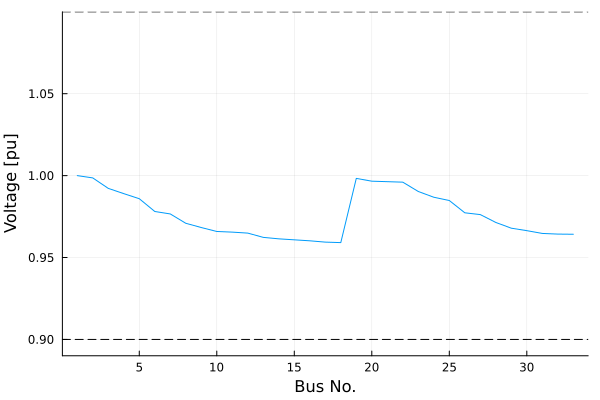

In [52]:
voltage=  XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/veryhighvery1.xlsx", "veryhighvery1","A2:A34")
voltage = vec(voltage)
rpower=  XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/veryhighvery1.xlsx", "veryhighvery1","B2:B34")
rpower = vec(rpower)
alphas=  XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/veryhighvery1.xlsx", "veryhighvery1","C2:C34")
alphas = vec(alphas)
 pbb=  XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/veryhighvery1.xlsx", "veryhighvery1","D2:D34")
 pbb= vec(pbb)


# voltage=  value.(m2[:v])
# voltage = vec(voltage)
# rpower=  value.(m2[:qc])
# rpower = vec(rpower)
# alphas=  value.(m2[:alpha])
# alphas = vec(alphas)
#  pbb=  value.(m2[:pb])
#  pbb= vec(pbb)



using Plots
plot(legend = false, ylims=(0.89, 1.1), xlabel="Bus No.", ylabel="Voltage [pu]")
plot!(1:33, voltage, label=false) 
hline!([1.1, 0.9], color=:black, linestyle=:dash, label=false)

# Display the plot
display(plot!())

Drawing the plot for voltage magnitude for OOS test

In [53]:
D = n_clusters
A = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            aa = zeros(nbuses, delta_size)
            for n in 1:nbuses
                for j in 1:cluster_size 
                    first =  R[n,cluster[j]]*(1-alphas[cluster[j]])
                    second=  -R[n,cluster[j]]
                    third = -B[n,cluster[j]]
                    # Add elements to the corresponding positions in the matrix A
                    aa[n,(j-1)*3+1] = first
                    aa[n,(j-1)*3+2] = second
                    aa[n,(j-1)*3+3] = third
                end
            end
            push!(A, aa)
        end

In [54]:
voltagenew = []
for m in 1:n_samples
    for n in 1:n_buses
        pr = sum(dot(A[f][n,:], deltas_samples_oos[f][:,m]) for f in 1:D) -R[n,:]'*pbb +B[n,:]'*rpower +a[n] 
        voltagenew_value = pr 
        push!(voltagenew, voltagenew_value)
    end
end

In [55]:
voltagenew

3300-element Vector{Any}:
 1.0
 1.0035795547381507
 1.017725701218526
 1.0266850177478337
 1.0362179663750326
 1.0493220126213765
 1.0479094479356463
 1.0526417136401665
 1.0522766809266488
 1.0524567628079482
 1.0527044660679934
 1.0529099776257618
 1.0506747079670031
 ⋮
 1.0264141196541545
 1.0193907653360677
 1.0173516734617125
 1.0183200947152304
 1.0604893823475379
 1.0641707214232115
 1.0691219318137153
 1.073288644506027
 1.073484920668647
 1.0751381523637717
 1.0747390717612355
 1.0746741122735906

In [56]:
original_vector = rand(n_samples*nbuses)  
function split_vector(v, chunk_size)
    n = length(v)
    chunks = []
    for i in 1:chunk_size:n
        push!(chunks, v[i:min(i+chunk_size-1, n)])
    end
    return chunks
end

split_vectors = split_vector(voltagenew, 33)

100-element Vector{Any}:
 Any[1.0, 1.0035795547381507, 1.017725701218526, 1.0266850177478337, 1.0362179663750326, 1.0493220126213765, 1.0479094479356463, 1.0526417136401665, 1.0522766809266488, 1.0524567628079482  …  1.01438472636599, 1.0151561644484972, 1.0510674217267102, 1.0536337280633634, 1.0553493645086691, 1.057078040804234, 1.055847325079536, 1.0557491972670148, 1.0549869059567227, 1.0548776107608475]
 Any[1.0, 1.0031963027177206, 1.0148655564797118, 1.0227452429254953, 1.031336968370408, 1.042746309474771, 1.0415469356988059, 1.0463885480253423, 1.0460885336140848, 1.046332134141813  …  1.0093649895000871, 1.008618452010912, 1.0444986647833878, 1.047089337497928, 1.0511258431241988, 1.0545652159875425, 1.054151938570713, 1.0551690734710677, 1.0546964561896175, 1.0546243486349205]
 Any[1.0, 1.0030992798288805, 1.014806832217443, 1.0224127930998492, 1.0305991299280786, 1.0429656300462367, 1.041538528628726, 1.0456817154105353, 1.0454507183896606, 1.0456148170409543  …  1.0110986

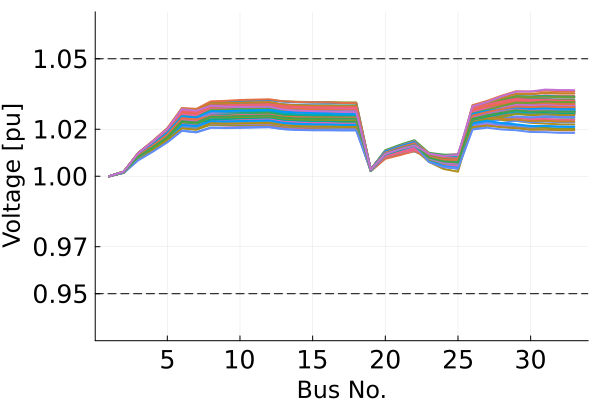

"/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/voltage_comparison3_1pm.pdf"

In [64]:
using Plots

plot(legend = false, ylims=(0.93, 1.07),xlabel="Bus No.", yticks=( [0.95,0.97,1,1.02,1.05]), ylabel="Voltage [pu]",xguidefontsize=16,yguidefontsize=16)
for vector in split_vectors
    plot!(1:33, vector.^0.5, label=false,linewidth=2) 
end

hline!([1.05, 0.95], color=:black, linestyle=:dash, label=false)
xaxis!(tickfontsize=17)


display(plot!())
savefig(plot!(), "voltage_comparison3_1pm.pdf")

Objective function for OOS test

checking the imprical violation probabilty in voltage constraints (joint chance constraints)

In [690]:
Vmax = 1.1
Vmin = 0.9

0.9

In [691]:
b_first = zeros(nbuses,1)
for n in 1:nbuses
    b_first[n]= -R[n,:]'*pbb +B[n,:]'*rpower +a[n] - Vmax
end 
b_first
b_second = zeros(nbuses,1)
for n in 1:nbuses
    b_second[n] = R[n,:]'*pbb -B[n,:]'*rpower -a[n] + Vmin
end  
b_second
c_prime = zeros(2*nbuses+1,1)
for i in 1:2*nbuses+1
    if i <= nbuses
        c_prime[i] = b_first[i]  # The first 33 elements from b_first
    elseif i <= 2 * nbuses
        c_prime[i] = b_second[i - nbuses]  # The next 33 elements from b_second
    else
        0  # The 67th element is zero
    end
end 
c_prime

67×1 Matrix{Float64}:
 -0.050000000000000044
 -0.05011546848054227
 -0.05042525699482647
 -0.05042688519025984
 -0.05042858064483924
 -0.050434756257346836
 -0.05044402229659406
 -0.0504625169395716
 -0.05047359785269867
 -0.050483755356398596
 -0.050484566459273905
 -0.05048595681438717
 -0.05049748695372225
  ⋮
 -0.1492932279149165
 -0.14873294300567286
 -0.1481739059470063
 -0.14956588888140188
 -0.1495667917012945
 -0.149572617291715
 -0.14957698851228762
 -0.1495782787897847
 -0.14958188383010274
 -0.14958278702435057
 -0.1495834486347266
  0.0

In [692]:
generalobj1 = []
    # For each cluster, create samples for delta vector
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        general = zeros(1,delta_size)
# Create samples
        for i in 1:1
            for j in 1:cluster_size
                p_av_min = 0
                p_l_min=  0
                q_l_min = 0

                # Add samples to the corresponding positions in the delta vector
                general[1,(j-1)*3+1] = p_av_min
                general[1,(j-1)*3+2] = p_l_min
                general[1,(j-1)*3+3] = q_l_min
            end
        end
        push!(generalobj1, general)
    end

In [693]:
A = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            aa = zeros(nbuses, delta_size)
            for n in 1:nbuses
                for j in 1:cluster_size 
                    first =  R[n,cluster[j]]*(1-alphas[cluster[j]])
                    second=  -R[n,cluster[j]]
                    third = -B[n,cluster[j]]
                    # Add elements to the corresponding positions in the matrix A
                    aa[n,(j-1)*3+1] = first
                    aa[n,(j-1)*3+2] = second
                    aa[n,(j-1)*3+3] = third
                end
            end
            push!(A, aa)
        end

In [694]:
er=[]
for j in 1:n_clusters
        er1= length(clusters[j])
        push!(er,er1)
    end    
    maximum(er)

10

In [695]:
AJ=vcat(A,-A,generalobj1)
 #a_prime= zeros(2*nbuses+1,n_clusters,3*maximum(er))
a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
# for i in 1:(2*nbuses+1)
#     for j in 1:n_clusters
#         for k in 1:3*maximum(er)
#             a_prime[i, j, k] = @expression(model, 0)
#         end
#     end
# end
# #a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
for b in 1:length(AJ)
    for c in 1:n_buses
        if b < n_clusters+1
            if 3*length(clusters[b]) == 3*maximum(er)
                for d in 1:3*maximum(er)
                    a_prime[c,b,d] = AJ[b][c,:][d]
                end   
            else
                for d in 1:3*maximum(er)
                    if d < 3*length(clusters[b])+1
                        a_prime[c,b,d] = AJ[b][c,:][d]
                    else
                        a_prime[c,b,d]=0
                    end    
                end    
            end
        elseif b > n_clusters && b < 2*n_clusters+1 
            if 3*length(clusters[b - n_clusters]) == 3*maximum(er)
                 for d in 1:3*maximum(er)
                     a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                 end   
            else
                for d in 1:3*maximum(er)
                    if d < 3*length(clusters[b - n_clusters])+1
                        a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                    else
                         a_prime[c + nbuses,b - n_clusters,d]=0
                    end    
                 end  
            end    
        else
            if c == 1
                if 3*length(clusters[b - 2*n_clusters]) == 3*maximum(er)
                    for d in 1:3*maximum(er) 
                        a_prime[c + 2*nbuses,b - 2*n_clusters,d] = AJ[b][c,:][d]
                    end    
                else
                     for d in 1:3*maximum(er)
                        if d < 3*length(clusters[b - 2*n_clusters])+1
                             a_prime[c + 2*nbuses,b - 2*n_clusters,d] =  AJ[b - 2*n_clusters][c,:][d]
                        else
                            a_prime[c + 2*nbuses,b - 2*n_clusters,d]=0
                        end    
                     end           
                 end
            end
         end
     end
end    
       
######################################################################

In [696]:
maxvaluesofg=zeros(n_samples,1)
for i in 1:n_samples
    g33_first =zeros(nbuses,1)
    for n in 1:nbuses
        g33_first[n]= dot(AJ[1][n,:],deltas_samples_oos[1][:,i]) + dot(AJ[2][n,:],deltas_samples_oos[2][:,i]) + dot(AJ[3][n,:],deltas_samples_oos[3][:,i]) + dot(AJ[4][n,:],deltas_samples_oos[4][:,i]) + dot(AJ[5][n,:],deltas_samples_oos[5][:,i]) + b_first[n]
    end 
    g33_second = zeros( nbuses,1)
    for n in 1:nbuses
        g33_second[n]= dot(AJ[6][n,:],deltas_samples_oos[1][:,i]) + dot(AJ[7][n,:],deltas_samples_oos[2][:,i]) + dot(AJ[8][n,:],deltas_samples_oos[3][:,i]) + dot(AJ[9][n,:],deltas_samples_oos[4][:,i]) + dot(AJ[10][n,:],deltas_samples_oos[5][:,i]) + b_second[n]
    end  
    g_cc = vcat(g33_first, g33_second)
    maxvaluesofg[i] = maximum(g_cc[:,1])
end    

In [697]:
maxvaluesofg

100×1 Matrix{Float64}:
 -0.022386320974791124
 -0.02232418841489113
 -0.025612662402155182
 -0.022175772488000553
 -0.022859626851217865
 -0.0261646719965772
 -0.02269947246829118
 -0.02565553977772317
 -0.023813632731361334
 -0.022796035969446547
 -0.02491464407944109
 -0.020569299946045498
 -0.0217728579196632
  ⋮
 -0.0250262285168169
 -0.023943240704798918
 -0.02143273518208505
 -0.02143740747188381
 -0.023902279536498223
 -0.020862167627436538
 -0.02173748435214852
 -0.022056864778100503
 -0.021992246369211453
 -0.02277630157760021
 -0.0242804838416082
 -0.017756530496722822

In [698]:
maximum(maxvaluesofg[:,1])

-0.017756530496722822

In [699]:

for element in maxvaluesofg[:,1]
    println(element)
end

-0.022386320974791124
-0.02232418841489113
-0.025612662402155182
-0.022175772488000553
-0.022859626851217865
-0.0261646719965772
-0.02269947246829118
-0.02565553977772317
-0.023813632731361334
-0.022796035969446547
-0.02491464407944109
-0.020569299946045498
-0.0217728579196632
-0.02048527324986374
-0.02122843299732055
-0.021882973763479426
-0.023084701470987037
-0.02265437018364157
-0.024155981657175064
-0.021995972954439027
-0.025920749345063485
-0.02182605490048263
-0.023117231274675815
-0.020807595284033746
-0.021770481994401045
-0.02848969456574274
-0.021945931374924874
-0.024056910212150957
-0.02202909119962627
-0.024512097333369863
-0.022231811429870636
-0.020730961632006363
-0.025391638610060014
-0.021298274369064993
-0.02129638984390906
-0.025059716003263278
-0.0275300259835203
-0.021443411074648276
-0.02402824696732915
-0.02103448434873707
-0.02712150515375711
-0.02412559316381981
-0.021657187634620954
-0.023131019141683286
-0.023865300093614924
-0.023515278266507806
-0.023116

Checking the inverter constraints (chance constraint) in OOS test

In [700]:
constraint_refs = []
    for n in 1:nbuses
        if dfpv_pu[n, :S] != 0.0
            for cluster in clusters
                s_r= zeros(1,3*length(cluster))
                for j in 1:length(cluster)
                    if cluster[j] == n
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        s_r[1,(j-1)*3+1]=1
                        main_constraint_ref =dfpv_pu[n, :S]^2 -  ((1-alphas[n])*dot(s_r,deltas_samples_oos[indxofcluster][:,1]))^2 - rpower[n]^2
                        push!(constraint_refs, main_constraint_ref)
                    end
                 end
             end 
        end   
     end

In [701]:
constraint_refs

19-element Vector{Any}:
 0.04327851232107535
 0.003860811508173606
 0.0
 0.14575319040000004
 0.5614550843749999
 0.6389136284000001
 0.03598043000000001
 0.24936759653901192
 0.03869819360000001
 0.2488325260670359
 0.019255962203938583
 0.0
 0.004109951019791558
 0.010368087654608008
 0.0030198044495068077
 0.14458701922987632
 0.3480228764
 0.08270969972316312
 0.6344924211153579

In [702]:
constraint_refs = []
M = n_samples

for m in 1:M
    for n in 1:nbuses
        if dfpv_pu[n, :S] != 0.0
            for cluster in clusters
                s_r = zeros(1, 3 * length(cluster))
                for j in 1:length(cluster)
                    if cluster[j] == n
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        s_r[1, (j-1) * 3 + 1] = 1
                        main_constraint_ref = dfpv_pu[n, :S]^2 - ((1 - alphas[n]) * dot(s_r, deltas_samples_oos[indxofcluster][:, m]))^2 - rpower[n]^2
                        push!(constraint_refs, main_constraint_ref)  # Save 'm' and 'n' alongside the constraint if needed
                    end
                end
            end
        end
    end
end

In [703]:
minimum(constraint_refs)

0.0

In [704]:
constraint_refs

1900-element Vector{Any}:
 0.04327851232107535
 0.003860811508173606
 0.0
 0.14575319040000004
 0.5614550843749999
 0.6389136284000001
 0.03598043000000001
 0.24936759653901192
 0.03869819360000001
 0.2488325260670359
 0.019255962203938583
 0.0
 0.004109951019791558
 ⋮
 0.2490969875
 0.03877573056441911
 0.2473624767386015
 0.0
 0.056942315387281284
 0.04454935728249712
 0.015531664855738023
 0.0
 0.0
 0.35033063574661494
 0.08045699396834902
 0.631316429418119

In [705]:
for value in constraint_refs
    println(value)
end

0.04327851232107535
0.003860811508173606
0.0
0.14575319040000004
0.5614550843749999
0.6389136284000001
0.03598043000000001
0.24936759653901192
0.03869819360000001
0.2488325260670359
0.019255962203938583
0.0
0.004109951019791558
0.010368087654608008
0.0030198044495068077
0.14458701922987632
0.3480228764
0.08270969972316312
0.6344924211153579
0.08907266354827437
0.0
0.2802297074447076
0.14575319040000004
0.5614550843749999
0.639165547575356
0.0379455890823295
0.2491007113416063
0.03958252979948521
0.24772535151179634
0.0
0.0
0.010190372533262687
0.0
0.0
0.2577328585699882
0.3480228764
0.0803999096
0.6329051085670397
0.12111715837816647
0.1588312992503335
0.12486962333143958
0.14833412211259692
0.561644462383639
0.6390846655830185
0.03598043000000001
0.24914028615526054
0.03924071958258719
0.2478774525998915
0.0012244171264059467
0.010078048972637144
0.06382557235157041
0.0
0.028507354532637592
0.07766772907246028
0.35232728118736745
0.0803999096
0.6363208114611177
0.04964874894916499
0.0

In [706]:
num_negative_numbers = sum(x -> x < 0, constraint_refs)

0

In [707]:
num_pvs=19

19

In [708]:
# Assuming constraint_refs is your original 1300-element vector

# Define a function to round numbers based on the condition
function custom_round(x)
    if x > 0 && x < 10^-4
        return 0
    elseif x < 0 && x > -10^-4
        return 0
    else
        return x
    end
end

# Apply the rounding function to each element in constraint_refs
rounded_refs = [custom_round(x) for x in constraint_refs]

# Calculate the number of elements in each sub-vector
num_elements_per_vector = num_pvs

# Calculate the total number of sub-vectors needed
total_vectors = length(rounded_refs) ÷ num_elements_per_vector

# Create the sub-vectors from the rounded elements
sub_vectors = [rounded_refs[(i-1)*num_elements_per_vector+1 : i*num_elements_per_vector] for i in 1:total_vectors]

100-element Vector{Vector{Real}}:
 [0.04327851232107535, 0.003860811508173606, 0.0, 0.14575319040000004, 0.5614550843749999, 0.6389136284000001, 0.03598043000000001, 0.24936759653901192, 0.03869819360000001, 0.2488325260670359, 0.019255962203938583, 0.0, 0.004109951019791558, 0.010368087654608008, 0.0030198044495068077, 0.14458701922987632, 0.3480228764, 0.08270969972316312, 0.6344924211153579]
 [0.08907266354827437, 0.0, 0.2802297074447076, 0.14575319040000004, 0.5614550843749999, 0.639165547575356, 0.0379455890823295, 0.2491007113416063, 0.03958252979948521, 0.24772535151179634, 0.0, 0.0, 0.010190372533262687, 0.0, 0.0, 0.2577328585699882, 0.3480228764, 0.0803999096, 0.6329051085670397]
 [0.12111715837816647, 0.1588312992503335, 0.12486962333143958, 0.14833412211259692, 0.561644462383639, 0.6390846655830185, 0.03598043000000001, 0.24914028615526054, 0.03924071958258719, 0.2478774525998915, 0.0012244171264059467, 0.010078048972637144, 0.06382557235157041, 0.0, 0.028507354532637592, 0.

In [709]:
# Assuming sub_vectors contains your 100 vectors
first_elements = [vec[1] for vec in sub_vectors]

100-element Vector{Float64}:
 0.04327851232107535
 0.08907266354827437
 0.12111715837816647
 0.04964874894916499
 0.04462030569109701
 0.026949496080078766
 0.05510773203311811
 0.03181223909298675
 0.14738435428973123
 0.0
 0.0
 0.007108427567945608
 0.0
 ⋮
 0.0
 0.13773426253267673
 0.07242882426260416
 0.1928088807653674
 0.11115973630651599
 0.0
 0.0
 0.0
 0.0
 0.0
 0.01498205817206208
 0.04161223415423945

In [710]:
num_negative_numbers = sum(x -> x < 0, first_elements)

0

In [711]:
# Assuming sub_vectors contains your 100 vectors

# Initialize an array to hold the vectors of n-th elements
elements_grouped_by_position = []

# Loop through the positions, 1 to 13 in each sub-vector
for i in 1:num_pvs
    push!(elements_grouped_by_position, [vec[i] for vec in sub_vectors])
end

# elements_grouped_by_position now contains 13 vectors, each vector contains all the n-th elements from the 100 vectors

In [712]:
elements_grouped_by_position

19-element Vector{Any}:
 [0.04327851232107535, 0.08907266354827437, 0.12111715837816647, 0.04964874894916499, 0.04462030569109701, 0.026949496080078766, 0.05510773203311811, 0.03181223909298675, 0.14738435428973123, 0.0  …  0.07242882426260416, 0.1928088807653674, 0.11115973630651599, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01498205817206208, 0.04161223415423945]
 [0.003860811508173606, 0.0, 0.1588312992503335, 0.0, 0.0, 0.0, 0.00535209216985591, 0.0, 0.10536248491276398, 0.0  …  0.0, 0.0, 0.012518400907029797, 0.0, 0.05804998771860018, 0.0, 0.0, 0.054479500392697555, 0.1689333991704529, 0.055624627036472224]
 [0.0, 0.2802297074447076, 0.12486962333143958, 0.15180703971580056, 0.020886345933930794, 0.0, 0.0, 0.25454452847169756, 0.22562527063960325, 0.0  …  0.14655230756133242, 0.05689147276574191, 0.0, 0.0, 0.0, 0.2807628225868241, 0.0, 0.13870933040070738, 0.20228082824873528, 0.0]
 [0.14575319040000004, 0.14575319040000004, 0.14833412211259692, 0.14575319040000004, 0.15050300275633127, 0.1466292

In [713]:
elements_grouped_by_position[9]

100-element Vector{Float64}:
 0.03869819360000001
 0.03958252979948521
 0.03924071958258719
 0.03869819360000001
 0.03869819360000001
 0.03869819360000001
 0.03896777881669673
 0.03869819360000001
 0.03882213187745578
 0.03869819360000001
 0.03932079930889708
 0.03869819360000001
 0.038905059486862445
 ⋮
 0.039059643825501186
 0.03920193048088164
 0.03908396135842748
 0.03890356088361498
 0.03882432673897796
 0.03930110224834758
 0.039055986835525275
 0.039144460629966606
 0.03956773617147916
 0.03869819360000001
 0.03869819360000001
 0.03877573056441911

In [714]:
# Count the number of negative values in each of the 13 vectors
num_negative_values = [count(x -> x < 0, vec) for vec in elements_grouped_by_position]

19-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [715]:
tt=[]
for i in 1:100
    if -0.0001> elements_grouped_by_position[9][i]
        aa=elements_grouped_by_position[9][i]
            push!(tt,aa)
    end
end
tt

Any[]

In [125]:
elements_grouped_by_position[9][1]

0

# Drawing the plot for load and Pv simu

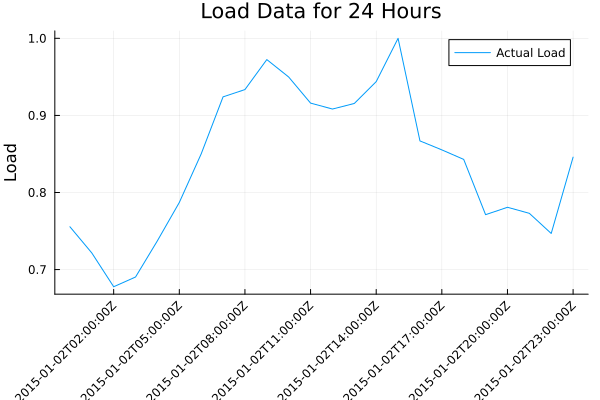

In [26]:

# Assuming you've read your dataset into a DataFrame called df
df = CSV.read("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/data/loaddata/time_series_60min_singleindex - Copy.csv", DataFrame)
# Define the normalization function
function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names(df)
    if eltype(df[!, col_name]) <: Real
        df[!, col_name] = normalize_column!(df[!, col_name])
    end
end




# Define the format of your timestamps
dateformat = "yyyy-mm-dd\\THH:MM:SSZ"
# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("2015-01-02T00:00:00Z", dateformat)
end_time = DateTime("2015-01-03T00:00:00Z", dateformat)
df_24h_load = filter(row -> start_time <= DateTime(row[:utc_timestamp], dateformat) < end_time, df)
# Ensure that the column names are correct and that they are Symbols
# Plot the load data, using the correct column accessors
loadplot = plot(df_24h_load.utc_timestamp, df_24h_load.AT_load_actual_entsoe_transparency, label="Actual Load", xlabel="Time", ylabel="Load", title="Load Data for 24 Hours", xrotation=45) # Rotates X-axis labels to make them readable




In [ ]:

data_url = "https://raw.githubusercontent.com/mieth-robert/testdata/main/single_household_smart_home.csv"
response = HTTP.get(data_url)
smart_home_data = CSV.File(IOBuffer(response.body)) |> DataFrame



smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], "m/d/y H:M")
# Load your smart_home_data DataFrame here
# smart_home_data = ...

# Define the format of your timestamps
dateformat = "m/d/y H:M"

# Ensure 'local_15min' is parsed to DateTime format if it's not already
#smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], dateformat)

# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, smart_home_data)

# Further filter to get only the start of each hour
df_hourly = df_24h[minute.(df_24h[!, :local_15min]) .== 0, :]

# Plot the solar data
plt = plot(df_hourly.local_15min, df_hourly.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)






function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names( df_hourly)
    if eltype( df_hourly[!, col_name]) <: Real
         df_hourly[!, col_name] = normalize_column!( df_hourly[!, col_name])
    end
end








# Define the format of your timestamps if your 'local_15min' column is in string format that needs parsing
dateformat = "m/d/y H:M"

# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, df_hourly)
# Ensure that the column names are correct and that they are Symbols
# Plot the solar data
banor = plot(df_24h.local_15min, df_24h.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)


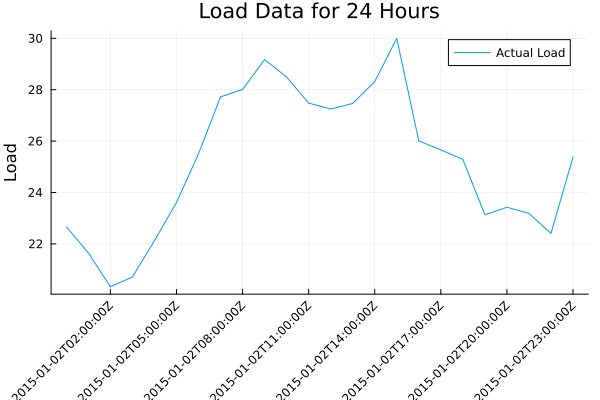

In [27]:

# Assuming you've read your dataset into a DataFrame called df
df = CSV.read("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/data/loaddata/time_series_60min_singleindex - Copy.csv", DataFrame)
# Define the normalization function
function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names(df)
    if eltype(df[!, col_name]) <: Real
        df[!, col_name] = normalize_column!(df[!, col_name])
    end
end




# Define the format of your timestamps
dateformat = "yyyy-mm-dd\\THH:MM:SSZ"
# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("2015-01-02T00:00:00Z", dateformat)
end_time = DateTime("2015-01-03T00:00:00Z", dateformat)
df_24h = filter(row -> start_time <= DateTime(row[:utc_timestamp], dateformat) < end_time, df)
# Ensure that the column names are correct and that they are Symbols
# Plot the load data, using the correct column accessors
loadplot = plot(df_24h.utc_timestamp, df_24h.AT_load_actual_entsoe_transparency, label="Actual Load", xlabel="Time", ylabel="Load", title="Load Data for 24 Hours", xrotation=45) # Rotates X-axis labels to make them readable





Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1

cum24hourseachbus = []
for i in 1:33
    eachbus = df_24h.AT_load_actual_entsoe_transparency.* dfb[!,"Pd"][i].*0.5
    push!(cum24hourseachbus,eachbus)
end





# Define the format of your timestamps
dateformat = "yyyy-mm-dd\\THH:MM:SSZ"
# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("2015-01-02T00:00:00Z", dateformat)
end_time = DateTime("2015-01-03T00:00:00Z", dateformat)
df_24h = filter(row -> start_time <= DateTime(row[:utc_timestamp], dateformat) < end_time, df)
# Ensure that the column names are correct and that they are Symbols
# Plot the load data, using the correct column accessors
loadplot = plot(df_24h.utc_timestamp, cum24hourseachbus[17], label="Actual Load", xlabel="Time", ylabel="Load", title="Load Data for 24 Hours", xrotation=45) # Rotates X-axis labels to make them readable




# cumbuseachhour = []
# for i in 1:24
#     eachhour = df_24h.AT_load_actual_entsoe_transparency[i].* dfb[!,"Pd"].* 1e3 ./ Sbase
#     push!(cumbuseachhour,eachhour)
# end    



# cumbuseachhourreactiveload = []
# for i in 1:24
#     eachhourreactiveload = df_24h.AT_load_actual_entsoe_transparency[i].* dfb[!,"Qd"].* 1e3 ./ Sbase
#     push!(cumbuseachhourreactiveload,eachhourreactiveload )
# end  


In [ ]:


data_url = "https://raw.githubusercontent.com/mieth-robert/testdata/main/single_household_smart_home.csv"
response = HTTP.get(data_url)
smart_home_data = CSV.File(IOBuffer(response.body)) |> DataFrame



smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], "m/d/y H:M")
# Load your smart_home_data DataFrame here
# smart_home_data = ...

# Define the format of your timestamps
dateformat = "m/d/y H:M"

# Ensure 'local_15min' is parsed to DateTime format if it's not already
#smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], dateformat)

# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, smart_home_data)

# Further filter to get only the start of each hour
df_hourly = df_24h[minute.(df_24h[!, :local_15min]) .== 0, :]

# Plot the solar data
plt = plot(df_hourly.local_15min, df_hourly.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)






function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names( df_hourly)
    if eltype( df_hourly[!, col_name]) <: Real
         df_hourly[!, col_name] = normalize_column!( df_hourly[!, col_name])
    end
end








# Define the format of your timestamps if your 'local_15min' column is in string format that needs parsing
dateformat = "m/d/y H:M"

# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, df_hourly)
# Ensure that the column names are correct and that they are Symbols
# Plot the solar data
solarplot = plot(df_24h.local_15min, df_24h.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)











Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1
df_24h.solar[21] = 0.0005
cum24hourseachbuspv = []
for i in 1:33
    eachbuspv = df_24h.solar.* dfpv[!, :S][i].*2# here we multiply each curve (24 hours) by a single value corres
    push!(cum24hourseachbuspv,eachbuspv)
end

solarplot = plot(df_24h.local_15min, cum24hourseachbuspv[17], label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)


# cumbuseachhourpv = []
# for i in 1:24
#     eachhourpv = df_24h.solar[i].* dfpv[!, :S] # here we scale the system capacity for all 33 buses at one specific hour by multiplying the sysytem capacity for all 33 buse by the amount of genereated pv (curve) at one specific time. then we repeat ut 24 hours for all hours. so we have 24 33dimension vectors.
#     push!(cumbuseachhourpv,eachhourpv)
# end    
# cumbuseachhourpv[10][:]




# pvcum = []
# for h in 1:24
#     Random.seed!(123)
#     pav = rand(length(cumbuseachhourpv[h][:])) .* cumbuseachhourpv[h][:] # Generate random scaling factors between 0 and 1 and then Scale the values between 0 and 100% of system capacity in each hour , it means that we have generated pv a 33 colum vector data for each hour in 24 hours
#     pavs = pav .* 1e3 ./ Sbase 
#     push!(pvcum,pavs)
# end  
# pvcum



In [ ]:
cum24hourseachbus[17]

In [ ]:
 cum24hourseachbuspv[17]

In [ ]:
using Plots

# Sample data for illustration
vector1 = rand(24)  # Random data simulating "Load Data"
vector2 = rand(24)  # Random data simulating "Total Available PV at bus 17"

# Time labels from 12 AM to 11 PM
hours = ["12 AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM", "6 AM", "7 AM", "8 AM", "9 AM", "10 AM", "11 AM", 
         "12 PM", "1 PM", "2 PM", "3 PM", "4 PM", "5 PM", "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11 PM"]

# Create the plot with specific settings for colors and labels
comparison= plot(1:24, [cum24hourseachbus[17],cum24hourseachbuspv[17]], label=["LOAD Data at Bus 17" "Total Available PV at Bus 17"], color=[:blue :red],
     xticks=(1:24, hours), xlabel="Time of Day", ylabel="kW",linewidth=2.5  legend=:topleft, xrotation=45)

# savefig(comparison, "C:/Users/user/OneDrive - Rutgers University/Desktop/PHD- research/loadDataPlotnorm.png")

In [ ]:
pvcum1 = pvcum./ 1e3 .* Sbase 

In [ ]:
totalpvofallnodesineachtime=[]
for j in 1:24
    time = sum(pvcum1[j][i] for i in 1:33)
    push!(totalpvofallnodesineachtime,time)
end  
totalpvofallnodesineachtime

In [ ]:
totalloadofallnodesineachtime=[]
for i in 1:24
    time = sum(cum24hourseachbus[j][i]  for j in 1:33)
    push!(totalloadofallnodesineachtime,time)
end
totalloadofallnodesineachtime

In [ ]:
using Plots
#at each hour we sum all pav of all 33 nodes 
# Sample data for illustration
vector1 = rand(24)  # Random data simulating "Load Data"
vector2 = rand(24)  # Random data simulating "Total Available PV at bus 17"

# Time labels from 12 AM to 11 PM
hours = ["12 AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM", "6 AM", "7 AM", "8 AM", "9 AM", "10 AM", "11 AM", 
         "12 PM", "1 PM", "2 PM", "3 PM", "4 PM", "5 PM", "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11 PM"]

# Create the plot with specific settings for colors and labels
comparison= plot(1:24, [totalloadofallnodesineachtime,totalpvofallnodesineachtime], label=["LOAD Data" "Total Available PV"], color=[:blue :red],
     xticks=(1:24, hours), xlabel="Time of Day", ylabel="kW",linewidth=2.5,  legend=:topleft, xrotation=45)
savefig(comparison, "/Users/ebrah/Mehrnoush/loadDataPlotnorm.pdf")

In [ ]:
totalpvofallnodesineachtime

one plot for both lowpv and high pv voltage fpr v0=1.05

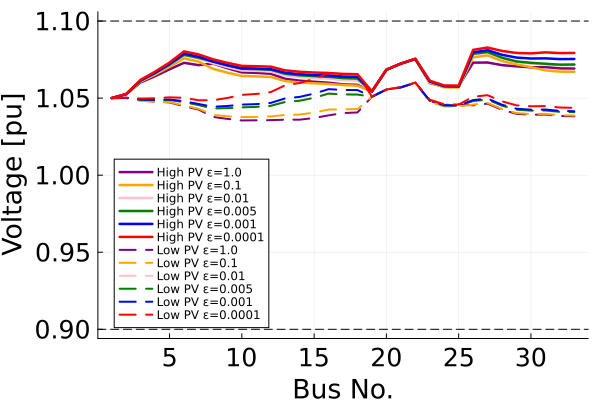

In [92]:
htime=14


data_1=   XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/v2Revisedversion_hour$(htime)_1.0.xlsx", "v2Revisedversion_hour$(htime)_1.0","A2:E34")
data_01=   XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/v2Revisedversion_hour$(htime)_0.1.xlsx", "v2Revisedversion_hour$(htime)_0.1","A2:E34")
data_001 = XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/v2Revisedversion_hour$(htime)_0.01.xlsx", "v2Revisedversion_hour$(htime)_0.01","A2:E34")
data_0005 = XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/v2Revisedversion_hour$(htime)_0.005.xlsx", "v2Revisedversion_hour$(htime)_0.005","A2:E34")
data_0001 = XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/v2Revisedversion_hour$(htime)_0.001.xlsx", "v2Revisedversion_hour$(htime)_0.001","A2:E34")
data_00001 =  XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/v2Revisedversion_hour$(htime)_0.0001.xlsx", "v2Revisedversion_hour$(htime)_0.0001","A2:E34")













datalow_1=   XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/lowpvv2Revisedversion_hour$(htime)_1.0.xlsx", "lowpvv2Revisedversion_hour$(htime)_1.0","A2:E34")
datalow_01=   XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/lowpvv2Revisedversion_hour$(htime)_0.1.xlsx", "lowpvv2Revisedversion_hour$(htime)_0.1","A2:E34")
datalow_001 = XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/lowpvv2Revisedversion_hour$(htime)_0.01.xlsx", "lowpvv2Revisedversion_hour$(htime)_0.01","A2:E34")
datalow_0005 = XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/lowpvv2Revisedversion_hour$(htime)_0.005.xlsx", "lowpvv2Revisedversion_hour$(htime)_0.005","A2:E34")
datalow_0001 = XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/lowpvv2Revisedversion_hour$(htime)_0.001.xlsx", "lowpvv2Revisedversion_hour$(htime)_0.001","A2:E34")
datalow_00001 =  XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/lowpvv2Revisedversion_hour$(htime)_0.0001.xlsx", "lowpvv2Revisedversion_hour$(htime)_0.0001","A2:E34")


















using Plots
using XLSX


nbuses = 33


epsilons = [1, 0.1, 0.01,0.005,0.001, 0.0001]
resources = 1:nbuses
voltage_highpv = [
   data_1[:, 1],
    data_01[:, 1],
    data_001[:, 1],
    data_0005[:, 1],
     data_0001[:, 1],
     data_00001[:, 1],
]

voltage_lowpv = [
   datalow_1[:, 1],
    datalow_01[:, 1],
    datalow_001[:, 1],
    datalow_0005[:, 1],
     datalow_0001[:, 1],
     datalow_00001[:, 1],
]






p = plot(xtickfontsize=18, ytickfontsize=18, legend=:bottomleft,xguidefontsize=18,yguidefontsize=18)
bold_colors = [:purple, :orange, :pink, :green,:blue,:red]

# Plot high PV data with solid lines
for (i, epsilon) in enumerate(epsilons)
    plot!(p, resources, voltage_highpv[i], label="High PV ε=$epsilon",
          line=:solid, linewidth=2.5, color=bold_colors[i])
end

# Plot low PV data with dashed lines
for (i, epsilon) in enumerate(epsilons)
    plot!(p, resources, voltage_lowpv[i], label="Low PV ε=$epsilon",
          line=(:dash, 2), linewidth=2.5, color=bold_colors[i])
end


hline!(p, [1.1, 0.9], color=:black, linestyle=:dash, label=false)


# Add labels and save the figure
xlabel!(p, "Bus No.")
xaxis!(tickfontsize=17)
ylabel!(p, "Voltage [pu]")
savefig(p, "voltage_comparison.png") # Save the combined plot as a PNG file
savefig(p, "voltage_comparison.pdf")
display(p)


one plot for both lowpv and high pv voltage fpr v0=1

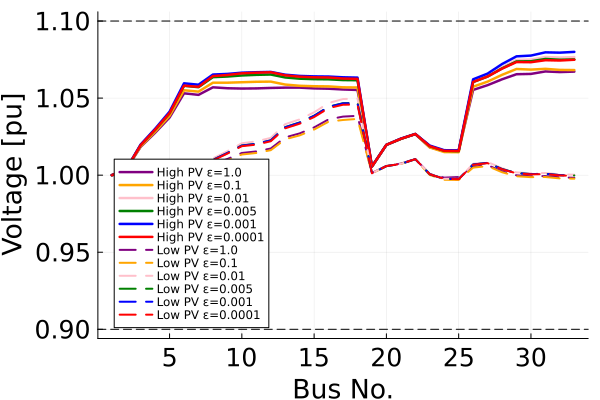

In [20]:
htime=14


data_1=   XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/v2Revisedversionv0_hour$(htime)_1.xlsx", "v2Revisedversionv0_hour$(htime)_1","A2:E34")
data_01=   XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/v2Revisedversionv0_hour$(htime)_0.1.xlsx", "v2Revisedversionv0_hour$(htime)_0.1","A2:E34")
data_001 = XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/v2Revisedversionv0_hour$(htime)_0.01.xlsx", "v2Revisedversionv0_hour$(htime)_0.01","A2:E34")
data_0005 = XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/v2Revisedversionv0_hour$(htime)_0.005.xlsx", "v2Revisedversionv0_hour$(htime)_0.005","A2:E34")
data_0001 = XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/v2Revisedversionv0_hour$(htime)_0.001.xlsx", "v2Revisedversionv0_hour$(htime)_0.001","A2:E34")
data_00001 =  XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/v2Revisedversionv0_hour$(htime)_0.0001.xlsx", "v2Revisedversionv0_hour$(htime)_0.0001","A2:E34")













datalow_1=   XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/lowpvv2Revisedversionv0_hour$(htime)_1.xlsx", "lowpvv2Revisedversionv0_hour$(htime)_1","A2:E34")
datalow_01=   XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/lowpvv2Revisedversionv0_hour$(htime)_0.1.xlsx", "lowpvv2Revisedversionv0_hour$(htime)_0.1","A2:E34")
datalow_001 = XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/lowpvv2Revisedversionv0_hour$(htime)_0.01.xlsx", "lowpvv2Revisedversionv0_hour$(htime)_0.01","A2:E34")
datalow_0005 = XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/lowpvv2Revisedversionv0_hour$(htime)_0.005.xlsx", "lowpvv2Revisedversionv0_hour$(htime)_0.005","A2:E34")
datalow_0001 = XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/lowpvv2Revisedversionv0_hour$(htime)_0.001.xlsx", "lowpvv2Revisedversionv0_hour$(htime)_0.001","A2:E34")
datalow_00001 =  XLSX.readdata("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/lowpvv2Revisedversionv0_hour$(htime)_0.0001.xlsx", "lowpvv2Revisedversionv0_hour$(htime)_0.0001","A2:E34")


















using Plots
using XLSX


nbuses = 33


epsilons = [1, 0.1, 0.01,0.005,0.001, 0.0001]
resources = 1:nbuses
voltage_highpv = [
   data_1[:, 1],
    data_01[:, 1],
    data_001[:, 1],
    data_0005[:, 1],
     data_0001[:, 1],
     data_00001[:, 1],
]

voltage_lowpv = [
   datalow_1[:, 1],
    datalow_01[:, 1],
    datalow_001[:, 1],
    datalow_0005[:, 1],
     datalow_0001[:, 1],
     datalow_00001[:, 1],
]






p = plot(xtickfontsize=18, ytickfontsize=18, legend=:bottomleft, legend_columns=1,xguidefontsize=18,yguidefontsize=18)
bold_colors = [:purple, :orange, :pink, :green,:blue,:red]

# Plot high PV data with solid lines
for (i, epsilon) in enumerate(epsilons)
    plot!(p, resources, voltage_highpv[i], label="High PV ε=$epsilon",
          line=:solid, linewidth=2.5, color=bold_colors[i])
end

# Plot low PV data with dashed lines
for (i, epsilon) in enumerate(epsilons)
    plot!(p, resources, voltage_lowpv[i], label="Low PV ε=$epsilon",
          line=(:dash, 2), linewidth=2.5, color=bold_colors[i])
end


hline!(p, [1.1, 0.9], color=:black, linestyle=:dash, label=false)


# Add labels and save the figure
xlabel!(p, "Bus No.")
xaxis!(tickfontsize=17)
ylabel!(p, "Voltage [pu]")
savefig(p, "voltage_comparison.png") # Save the combined plot as a PNG file
savefig(p, "voltage_comparison.pdf")
display(p)


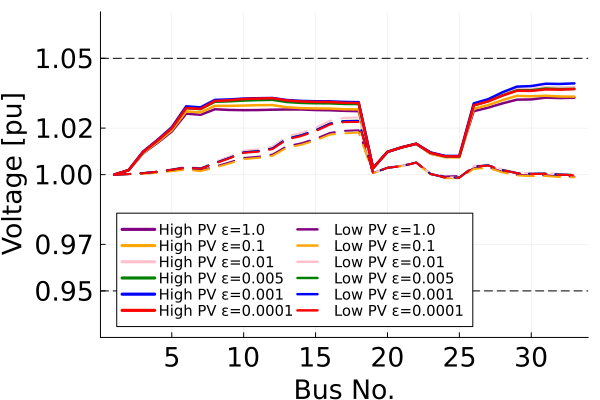

"/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/Data Value in Distribution System 2024 _ PHDfirstPaPer/voltage_comparison.svg"

In [63]:
gr() 
using Plots

# Assume definitions for epsilons, resources, voltage_highpv, and voltage_lowpv are provided.
bold_colors = [:purple, :orange, :pink, :green, :blue, :red]

p = plot(xtickfontsize=18, ytickfontsize=18,ylims=(0.93, 1.07),     yticks=( [0.95,0.97,1,1.02,1.05]), legend=:bottomleft, legendfontsize=10, legend_columns=2,legendsize=3, xguidefontsize=18, yguidefontsize=18)

# Iterate over all epsilons and add both high and low PV data for each epsilon to the plot.
for (i, epsilon) in enumerate(epsilons)
    # High PV in solid line
    plot!(p, resources, voltage_highpv[i].^0.5, label="High PV ε=$epsilon", line=:solid, linewidth=2.5, color=bold_colors[i])
    
    # Low PV in dashed line
    plot!(p, resources, voltage_lowpv[i].^0.5, label="Low PV ε=$epsilon", line=(:dash, 2), linewidth=2.5, color=bold_colors[i])
end

# Horizontal lines without label
hline!(p, [1.05, 0.95], color=:black, linestyle=:dash, label=false)

# Adding labels
xlabel!(p, "Bus No.")
ylabel!(p, "Voltage [pu]")

# Save and display the figure
savefig(p, "voltage_comparison.png")
savefig(p, "voltage_comparison.pdf")
display(p)
savefig(p, "voltage_comparison1.pdf")
savefig(p, "voltage_comparison.svg") 

nodal system

In [28]:
using CSV
using DataFrames
using JuMP
using Gurobi
using Ipopt
using LinearAlgebra
using Random
using Plots
using SparseArrays
using XLSX
using MosekTools
using SCS
using Distributions
using HTTP




file_loc = "/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/data/33bus"
dfg = CSV.read("$file_loc/Generator (1).csv", DataFrame)
dfl = CSV.read("$file_loc/Line (1).csv",DataFrame)
dfb = CSV.read("$file_loc/Node_full (1).csv", DataFrame)
dfpv = CSV.read("$file_loc/pvlow.csv", DataFrame)
dfbat = CSV.read("$file_loc/battery (1).csv", DataFrame)

Row,index,Node,bmax,pmax
,Int64,Int64,Int64,Int64
1,1,1,0,0
2,2,2,0,0
3,3,3,0,0
4,4,4,0,0
5,5,5,0,0
6,6,6,0,0
7,7,7,0,0
8,8,8,0,0
9,9,9,0,0


In [29]:

# Assuming you've read your dataset into a DataFrame called df
df = CSV.read("/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/data/loaddata/time_series_60min_singleindex - Copy.csv", DataFrame)
# Define the normalization function
function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names(df)
    if eltype(df[!, col_name]) <: Real
        df[!, col_name] = normalize_column!(df[!, col_name])
    end
end




# Define the format of your timestamps
dateformat = "yyyy-mm-dd\\THH:MM:SSZ"
# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("2015-01-02T00:00:00Z", dateformat)
end_time = DateTime("2015-01-03T00:00:00Z", dateformat)
df_24h = filter(row -> start_time <= DateTime(row[:utc_timestamp], dateformat) < end_time, df)
# Ensure that the column names are correct and that they are Symbols
# Plot the load data, using the correct column accessors
loadplot = plot(df_24h.utc_timestamp, df_24h.AT_load_actual_entsoe_transparency, label="Actual Load", xlabel="Time", ylabel="Load", title="Load Data for 24 Hours", xrotation=45) # Rotates X-axis labels to make them readable





Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1

cum24hourseachbus = []
for i in 1:33
    eachbus = df_24h.AT_load_actual_entsoe_transparency.* dfb[!,"Pd"][i].* 1e3.*0.5 ./ Sbase
    push!(cum24hourseachbus,eachbus)
end





# Define the format of your timestamps
dateformat = "yyyy-mm-dd\\THH:MM:SSZ"
# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("2015-01-02T00:00:00Z", dateformat)
end_time = DateTime("2015-01-03T00:00:00Z", dateformat)
df_24h = filter(row -> start_time <= DateTime(row[:utc_timestamp], dateformat) < end_time, df)
# Ensure that the column names are correct and that they are Symbols
# Plot the load data, using the correct column accessors
loadplot = plot(df_24h.utc_timestamp, cum24hourseachbus[4], label="Actual Load", xlabel="Time", ylabel="Load", title="Load Data for 24 Hours", xrotation=45) # Rotates X-axis labels to make them readable




cumbuseachhour = []
for i in 1:24
    eachhour = df_24h.AT_load_actual_entsoe_transparency[i].* dfb[!,"Pd"].* 1e3.*0.5 ./ Sbase
    push!(cumbuseachhour,eachhour)
end    



cumbuseachhourreactiveload = []
for i in 1:24
    eachhourreactiveload = df_24h.AT_load_actual_entsoe_transparency[i].* dfb[!,"Qd"].* 1e3.*0.5 ./ Sbase
    push!(cumbuseachhourreactiveload,eachhourreactiveload )
end  


In [30]:
using CSV
using DataFrames
using HTTP
using CSV
using DataFrames
using Dates
using Plots



data_url = "https://raw.githubusercontent.com/mieth-robert/testdata/main/single_household_smart_home.csv"
response = HTTP.get(data_url)
smart_home_data = CSV.File(IOBuffer(response.body)) |> DataFrame



smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], "m/d/y H:M")
# Load your smart_home_data DataFrame here
# smart_home_data = ...

# Define the format of your timestamps
dateformat = "m/d/y H:M"

# Ensure 'local_15min' is parsed to DateTime format if it's not already
#smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], dateformat)

# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, smart_home_data)

# Further filter to get only the start of each hour
df_hourly = df_24h[minute.(df_24h[!, :local_15min]) .== 0, :]

# Plot the solar data
plt = plot(df_hourly.local_15min, df_hourly.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)






function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names( df_hourly)
    if eltype( df_hourly[!, col_name]) <: Real
         df_hourly[!, col_name] = normalize_column!( df_hourly[!, col_name])
    end
end








# Define the format of your timestamps if your 'local_15min' column is in string format that needs parsing
dateformat = "m/d/y H:M"

# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, df_hourly)
# Ensure that the column names are correct and that they are Symbols
# Plot the solar data
solarplot = plot(df_24h.local_15min, df_24h.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)











Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1
df_24h.solar[21] = 0.0005
cum24hourseachbuspv = []
for i in 1:33
    eachbuspv = df_24h.solar.* dfpv[!, :S][i].*2# here we multiply each curve (24 hours) by a single value corres
    push!(cum24hourseachbuspv,eachbuspv)
end




cumbuseachhourpv = []
for i in 1:24
    eachhourpv = df_24h.solar[i].* dfpv[!, :S].*2 # here we scale the system capacity for all 33 buses at one specific hour by multiplying the sysytem capacity for all 33 buse by the amount of genereated pv (curve) at one specific time. then we repeat ut 24 hours for all hours. so we have 24 33dimension vectors.
    push!(cumbuseachhourpv,eachhourpv)
end    
cumbuseachhourpv[10][:]




pvcum = []
for h in 1:24
    Random.seed!(123)
    pav = rand(length(cumbuseachhourpv[h][:])) .* cumbuseachhourpv[h][:] # Generate random scaling factors between 0 and 1 and then Scale the values between 0 and 100% of system capacity in each hour , it means that we have generated pv a 33 colum vector data for each hour in 24 hours
    pavs = pav .* 1e3 ./ Sbase 
    push!(pvcum,pavs)
end  
pvcum




24-element Vector{Any}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 9.705421098469855e-6, 0.0, 0.00027397088168331556, 0.0, 0.0, 0.0, 0.00015150883439876779, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 9.705421098469855e-6, 0.0, 0.00027397088168331556, 0.0, 0.0, 0.0, 0.00015150883439876779, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 9.705421098469855e-6, 0.0, 0.00027397088168331556, 0.0, 0.0, 0.0, 0.00015150883439876779, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 9.705421098469855e-6, 0.0, 0.00027397088168331556, 0.0, 0.0, 0.0, 0.00015150883439876779, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 9.705421098469855e-6, 0.0, 0.00027397088168331556, 0.0, 0.0, 0.0, 0.00015150883439876779, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 9.705421098469855e-6, 0.0, 0.00027397088168331556, 0.0, 0.0, 0.0, 0.00015150883439876779, 0.0, 0.0]
 [0.0, 0.0, 0.0,

In [31]:
S_per_time_pu=cumbuseachhourpv.* 1e3 ./ Sbase

24-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.0, 0.0, 0.000169971671388102, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.0, 0.0, 0.000169971671388102, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.0, 0.0, 0.000169971671388102, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.0, 0.0, 0.000169971671388102, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.0, 0.0, 0.000169971671388102, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.000169971671388102, 0.0, 0.000339943342776204, 0.0, 0.0, 0.0, 0.000169971671388102, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0

In [32]:
using Printf

# Function to adjust and format numbers, keeping them as numbers
function adjust_and_format_number(num)
    if abs(num) < 1e-4
        return 0.0
    else
        return round(num, digits=4)
    end
end

# Apply the function to each number in the vector pvcum
pvcum = map(sublist -> map(adjust_and_format_number, sublist), pvcum)

# Displaying a sample from the result
println(pvcum[10])

# Apply the same process for other vectors
cumbuseachhour = map(sublist -> map(adjust_and_format_number, sublist), cumbuseachhour)
println(cumbuseachhour[10])

cumbuseachhourreactiveload = map(sublist -> map(adjust_and_format_number, sublist), cumbuseachhourreactiveload)
println(cumbuseachhourreactiveload[10])


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0321, 0.0104, 0.0061, 0.004, 0.0, 0.0, 0.0119, 0.0018, 0.0, 0.0011, 0.0, 0.0323, 0.0, 0.0, 0.0, 0.0179, 0.0, 0.0]
[0.0, 0.0486, 0.0438, 0.0583, 0.0292, 0.0292, 0.0972, 0.0972, 0.0292, 0.0292, 0.0219, 0.0292, 0.0292, 0.0583, 0.0292, 0.0292, 0.0292, 0.0438, 0.0438, 0.0438, 0.0438, 0.0438, 0.0438, 0.2042, 0.2042, 0.0292, 0.0292, 0.0292, 0.0583, 0.0972, 0.0729, 0.1021, 0.0292]
[0.0, 0.0292, 0.0194, 0.0389, 0.0146, 0.0097, 0.0486, 0.0486, 0.0097, 0.0097, 0.0146, 0.017, 0.017, 0.0389, 0.0049, 0.0097, 0.0097, 0.0194, 0.0194, 0.0194, 0.0194, 0.0194, 0.0243, 0.0972, 0.0972, 0.0122, 0.0122, 0.0097, 0.034, 0.2917, 0.034, 0.0486, 0.0194]


In [33]:
# define location of files

htime= 19

#define voltage base and Sbase 
Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1

#convert impedances from Ohms to p.u. - loads from kW to pu - battery data from kw to pu - pv data from kw to pu
dfb_pu = DataFrame()
for row in eachrow(dfb)
    newdfb = (index=row.index, Node = row.Node, Pd=row.Pd .* 1e3 .*0.5 ./ Sbase, Qd=row.Qd .* 1e3.*0.5 ./ Sbase, Vmax=1.1, Vmin=0.9, r=row.r ./(Vbase^2 / Sbase), x=row.x ./(Vbase^2 / Sbase), b= row.b)
    push!(dfb_pu, newdfb)
end

dfl_pu = DataFrame()
for row in eachrow(dfl)
    newdfl = (index=row.index, to = row.to , from=row.from , r=row.r ./  (Vbase^2 / Sbase), x=row.x ./ (Vbase^2 / Sbase), b=row.b, s=row.s, g = row.g)
    push!(dfl_pu, newdfl)
end

dfbat_pu = DataFrame()
for row in eachrow(dfbat)
    newdfbat = (index=row.index, Node = row.Node , bmax=row.bmax .* 1e3 ./ Sbase , pmax=row.pmax .* 1e3 ./ Sbase )
    push!(dfbat_pu, newdfbat)
end

dfpv_pu = DataFrame()
for row in eachrow(dfpv)
    newdfpv = (index=row.index, Node = row.Node , S = row.S .* 1e3.*2 ./ Sbase )
    push!(dfpv_pu, newdfpv)
end


# bring the data in a more useable form
println(">>> preparing data")
buses = []
for row in eachrow(dfb_pu)
    newbus = (index=row.index, ancestor=[], children=[], pd=row.Pd, qd=row.Qd, Vmax=row.Vmax, Vmin = row.Vmin)
    push!(buses, newbus)
end

lines = []
for row in eachrow(dfl_pu)
    newline = (index=row.index, r=row.r, x=row.x, from=row.to, to=row.from)
    push!(buses[newline.to].ancestor, newline.from)
    push!(buses[newline.from].children, newline.to)
    push!(lines, newline)
end

PVs = []
for row in eachrow(dfpv_pu)
    newPV = (index=row.index, S=row.S)
    push!(PVs, newPV)
end

energy_storage_systems = []
for row in eachrow(dfbat_pu)
    newenergy_storage_system = (index=row.index, Pbmax=row.pmax,Bmax = row.bmax )
    push!(energy_storage_systems, newenergy_storage_system)
end

nbuses = length(buses)
nlines = length(lines)
nPVs = length(PVs)
nenergy_storage_systems = length(energy_storage_systems)

# now compute the same thing in the matrix form
println(">>> compute matrizes")
# define A matrix (with substation bus!)
A = zeros(length(lines), length(buses))
for bus in buses
    a = bus.index
    while a != 1
        A[a-1, bus.index] = 1
        a = buses[a].ancestor[1]
    end
end

# define load active and reactive power vectors
pl= cumbuseachhour[htime]
ql = cumbuseachhourreactiveload[htime]
pav_pu = pvcum[htime]

# Random.seed!(123)
# random_factors = 1 .* rand(length(dfpv[!, :S])) 
# pav = random_factors .* dfpv[!, :S]
# pav_pu=pav .* 1e3 ./ Sbase 
######################################



# define power generation vectors
#Random.seed!(123)
#pav = rand(length(dfpv_pu[!, :S])) .* dfpv_pu[!, :S] # Generate random scaling factors between 0 and 1 and then Scale the values between 0 and 100%

#pavs = pav .* 5

# set substation voltage
u_0 = 1.05

# define remaining matrizes
diag_r = Diagonal([line.r for line in lines])
diag_x = Diagonal([line.x for line in lines])
R = 2*A'*diag_r*A
B = 2*A'*diag_x*A
a = ones(nbuses) .* u_0 


# define parameters relatedd to the price
c = fill(10, nbuses) #the price associated with the power consumed by the customers
d= fill(3, nbuses) # the feed-in tariff cost to the utility
e= fill(30, nbuses) # the cost of reactive power injection/absorption from the inverters
f= fill(6,nbuses) # the cost of active power curtailment

>>> preparing data
>>> compute matrizes


33-element Vector{Int64}:
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 ⋮
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6
 6

In [7]:
print(pav_pu ./ 1e3 .* Sbase)

[0.0, 0.0, 180.2, 0.0, 61.3, 121.10000000000001, 0.0, 167.7, 0.0, 0.0, 250.90000000000003, 52.800000000000004, 0.0, 33.9, 0.0, 231.79999999999998, 74.8, 44.4, 28.7, 0.0, 215.9, 85.8, 12.7, 0.0, 8.3, 0.0, 233.7, 0.0, 238.8, 0.0, 129.2, 0.0, 225.0]

In [8]:
forecast_values = hcat(pav_pu,pl,ql)

33×3 Matrix{Float64}:
 0.0     0.0     0.0
 0.0     0.0421  0.0253
 0.1802  0.0379  0.0169
 0.0     0.0506  0.0337
 0.0613  0.0253  0.0126
 0.1211  0.0253  0.0084
 0.0     0.0843  0.0421
 0.1677  0.0843  0.0421
 0.0     0.0253  0.0084
 0.0     0.0253  0.0084
 0.2509  0.019   0.0126
 0.0528  0.0253  0.0148
 0.0     0.0253  0.0148
 ⋮               
 0.0858  0.0379  0.0169
 0.0127  0.0379  0.0211
 0.0     0.177   0.0843
 0.0083  0.177   0.0843
 0.0     0.0253  0.0105
 0.2337  0.0253  0.0105
 0.0     0.0253  0.0084
 0.2388  0.0506  0.0295
 0.0     0.0843  0.2529
 0.1292  0.0632  0.0295
 0.0     0.0885  0.0421
 0.225   0.0253  0.0169

In [9]:
# Function to create clusters
function create_clusters(n_buses, n_clusters)
    Random.seed!(123)
    buses = collect(1:n_buses) # Create a list of buses
    clusters = [Int[] for _ in 1:n_clusters] # Initialize clusters

    while length(buses) > 0
        for cluster in clusters
            if length(buses) == 0
                break
            end
            # Randomly choose a bus to be in this cluster
            bus_index = rand(1:length(buses))
            bus = buses[bus_index]

            # Add the bus to the current cluster
            push!(cluster, bus)

            # Remove the bus from the list of buses
            deleteat!(buses, bus_index)

            # Sort the cluster to ensure buses are close together
            sort!(cluster)
        end
    end
    return clusters
end

# Define the number of buses and clusters
n_buses = 33
n_clusters = 33

33

In [10]:
# clusters= [[1,2,3,4,5,6,7,8,9,10],[11,12,13,14,15,16,17,18],[19,20,21,22],[23,24,25],[26,27,28,29,30,31,32,33]]


clusters= [[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12],[13],[14],[15],[16],[17],[18],[19],[20],[21],[22],[23],[24],[25],[26],[27],[28],[29],[30],[31],[32],[33]]

33-element Vector{Vector{Int64}}:
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]
 [10]
 [11]
 [12]
 [13]
 ⋮
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [32]
 [33]

In [11]:
F=pl./ql
F[1]=0

0

In [12]:
Random.seed!(123)
# Function to create samples for vector deltas
function create_delta_samples(clusters, forecast_values, n_samples)
    deltas_samples = []

    # For each cluster, create samples for delta vector
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        samples = zeros(delta_size, n_samples)

        # Create samples
        for i in 1:n_samples
            for j in 1:cluster_size
                # p_av follows a normal distribution with mean 0 and std deviation of 10% of forecast
                p_av_forecast = forecast_values[cluster[j], 1]
                p_av_std = 0.2 * p_av_forecast
                p_av_dist = Normal(0, p_av_std)
                p_av_sample = rand(p_av_dist)
                p_av_sample = min.(p_av_sample, S_per_time_pu[htime][:][cluster[j]] - pav_pu[cluster[j]])
                p_av_sample = max.(p_av_sample, - pav_pu[cluster[j]])

                # p_l is uniformly sampled between 0.5 and 1 of forecast
                # q_l is uniformly sampled between 0.9 and 1.1 of forecast
                p_l_forecast = forecast_values[cluster[j], 2]
                p_l_std = 0.2 * p_l_forecast
                p_l_dist = Normal(0, p_l_std)
                p_l_sample = rand(p_l_dist)
                p_l_sample = min.(p_l_sample, 1.2 * p_l_forecast - p_l_forecast)
                p_l_sample = max.(p_l_sample, 0.5 * p_l_forecast- p_l_forecast)
                
                if F[cluster[j]] == 0
                    q_l_sample= 0
                else    
                    q_l_sample = (p_l_sample + p_l_forecast) ./ F[cluster[j]]
                end
                
                # Add samples to the corresponding positions in the delta vector
                samples[(j-1)*3+1, i] = p_av_sample + p_av_forecast
                samples[(j-1)*3+2, i] = p_l_sample + p_l_forecast
                samples[(j-1)*3+3, i] = q_l_sample
            end
        end

        # Add the samples for this cluster's delta to the list
        push!(deltas_samples, samples)
    end
    return deltas_samples
end













# Function to create samples for vector deltas
# function create_delta_samples(clusters, forecast_values, n_samples)
#     deltas_samples = []

#     # For each cluster, create samples for delta vector
#     for cluster in clusters
#         cluster_size = length(cluster)
#         delta_size = 3 * cluster_size
#         samples = zeros(delta_size, n_samples)

#         # Create samples
#         for i in 1:n_samples
#             for j in 1:cluster_size
#                 # p_av follows a normal distribution with mean 0 and std deviation of 10% of forecast
#                 p_av_forecast = forecast_values[cluster[j], 1]
#                 p_av_std = 0.1 * p_av_forecast
#                 p_av_dist = Normal(0, p_av_std)
#                 p_av_sample = rand(p_av_dist)
#                 p_av_sample = min.(p_av_sample, dfpv_pu[!,:S][cluster[j]] - pav_pu[cluster[j]])
#                 p_av_sample = max.(p_av_sample, - pav_pu[cluster[j]])

#                 # p_l is uniformly sampled between 0.5 and 1 of forecast
#                 # q_l is uniformly sampled between 0.9 and 1.1 of forecast
#                 p_l_forecast = forecast_values[cluster[j], 2]
#                 if p_l_forecast > 0
#                     p_l_sample = rand(Uniform(0.5 * p_l_forecast, p_l_forecast))
#                 else
#                     p_l_sample = 0 
#                 end
#                 q_l_forecast = forecast_values[cluster[j], 3]
#                 if q_l_forecast > 0
#                     q_l_sample = rand(Uniform(0.9 * q_l_forecast, 1.1 * q_l_forecast))
#                 else
#                     q_l_sample = 0 
#                 end

#                 # Add samples to the corresponding positions in the delta vector
#                 samples[(j-1)*3+1, i] = p_av_sample+pav_pu[cluster[j]]
#                 samples[(j-1)*3+2, i] = p_l_sample
#                 samples[(j-1)*3+3, i] = q_l_sample
#             end
#         end

#         # Add the samples for this cluster's delta to the list
#         push!(deltas_samples, samples)
#     end
#     return deltas_samples
# end



# Create the samples for vector deltas
n_samples = 5 # Number of samples for each vector delta
deltas_samples = create_delta_samples(clusters, forecast_values, n_samples)

33-element Vector{Any}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.035629996904282396 0.036585737170019166 … 0.03351990028279633 0.03756753138803977; 0.02141185087121959 0.021986203097422444 … 0.020143788055932237 0.022576212449344563]
 [0.18962088550268164 0.13423305795203488 … 0.18225779115146548 0.17459033127662416; 0.027955041773606713 0.040844126922997805 … 0.040925555633186776 0.04548; 0.01246544079086948 0.018212816490729887 … 0.018249126390523913 0.020279999999999996]
 [0.0 0.0 … 0.0 0.0; 0.04855160847850244 0.05772203425701809 … 0.05089111835684899 0.0332227446145182; 0.032335755053864275 0.03844333111584012 … 0.03389388712699231 0.022126610543661333]
 [0.07486914041272039 0.06884897032413473 … 0.03747526869247468 0.06409829977007585; 0.030359999999999998 0.016942924144599705 … 0.016478753833513098 0.028306754164385273; 0.01512 0.008437978032488391 … 0.008206810209575694 0.014097434880286737]
 [0.14387538219428733 0.09893523626298409 … 0.

In [13]:
clusters

33-element Vector{Vector{Int64}}:
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]
 [10]
 [11]
 [12]
 [13]
 ⋮
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [32]
 [33]

In [14]:
function create_delta_max(clusters, S_per_time_pu,pl,ql)
    deltas_max = []
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        max = zeros(delta_size, 1)
        for i in 1:1
            for j in 1:cluster_size
                p_av_max =  S_per_time_pu[htime][:][cluster[j]]
                p_l_max=  1.2*pl[cluster[j]]
                if F[cluster[j]]==0
                    q_l_max = 0
                else    
                    q_l_max = 1.2*pl[cluster[j]]/F[cluster[j]]
                end    
                # Add maxvalues to the corresponding positions in the delta_max vector
                max[(j-1)*3+1, i] = p_av_max
                max[(j-1)*3+2, i] = p_l_max
                max[(j-1)*3+3, i] = q_l_max
            end
        end
        push!(deltas_max, max)
    end
    return deltas_max
end
deltas_max = create_delta_max(clusters, S_per_time_pu,pl,ql)







# function create_delta_max(clusters, PVs,pl,ql)
#     deltas_max = []
#     for cluster in clusters
#         cluster_size = length(cluster)
#         delta_size = 3 * cluster_size
#         max = zeros(delta_size, 1)
#         for i in 1:1
#             for j in 1:cluster_size
#                 p_av_max = PVs[cluster[j]].S
#                 p_l_max=  1*pl[cluster[j]]
#                 q_l_max = 1.1*ql[cluster[j]]
#                 # Add maxvalues to the corresponding positions in the delta_max vector
#                 max[(j-1)*3+1, i] = p_av_max
#                 max[(j-1)*3+2, i] = p_l_max
#                 max[(j-1)*3+3, i] = q_l_max
#             end
#         end
#         push!(deltas_max, max)
#     end
#     return deltas_max
# end
# deltas_max = create_delta_max(clusters, PVs,pl,ql)

33-element Vector{Any}:
 [0.0; 0.0; 0.0;;]
 [0.0; 0.050519999999999995; 0.030359999999999998;;]
 [0.241643059490085; 0.04548; 0.020279999999999996;;]
 [0.0; 0.060719999999999996; 0.040440000000000004;;]
 [0.241643059490085; 0.030359999999999998; 0.01512;;]
 [0.3624645892351275; 0.030359999999999998; 0.010079999999999999;;]
 [0.0; 0.10116; 0.050519999999999995;;]
 [0.193314447592068; 0.10116; 0.050519999999999995;;]
 [0.0; 0.030359999999999998; 0.010079999999999999;;]
 [0.0; 0.030359999999999998; 0.010079999999999999;;]
 [0.3624645892351275; 0.022799999999999997; 0.015119999999999998;;]
 [0.386628895184136; 0.030359999999999998; 0.017759999999999998;;]
 [0.0; 0.030359999999999998; 0.017759999999999998;;]
 ⋮
 [0.241643059490085; 0.04548; 0.020279999999999996;;]
 [0.096657223796034; 0.04548; 0.02532;;]
 [0.0; 0.21239999999999998; 0.10116;;]
 [0.144985835694051; 0.21239999999999998; 0.10116;;]
 [0.0; 0.030359999999999998; 0.0126;;]
 [0.289971671388102; 0.030359999999999998; 0.0126;;]
 [0.0

In [15]:



function create_delta_min(clusters, S_per_time_pu,pl,ql)
    deltas_min = []
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        min = zeros(delta_size, 1)
        for i in 1:1
            for j in 1:cluster_size
                p_av_min = 0
                p_l_min=  0.5*pl[cluster[j]]
                if F[cluster[j]]==0
                    q_l_min = 0
                else    
                    q_l_min = 0.5*pl[cluster[j]]/F[cluster[j]]
                end 
                # Add minvalues to the corresponding positions in the delta_min vector
                min[(j-1)*3+1, i] = p_av_min
                min[(j-1)*3+2, i] = p_l_min
                min[(j-1)*3+3, i] = q_l_min
            end
        end
        push!(deltas_min, min)
    end
    return deltas_min
end
deltas_min = create_delta_min(clusters, S_per_time_pu,pl,ql)





# function create_delta_min(clusters, PVs,pl,ql)
#     deltas_min = []
#     for cluster in clusters
#         cluster_size = length(cluster)
#         delta_size = 3 * cluster_size
#         min = zeros(delta_size, 1)
#         for i in 1:1
#             for j in 1:cluster_size
#                 p_av_min = 0
#                 p_l_min=  0.5*pl[cluster[j]]
#                 q_l_min = 0.9*ql[cluster[j]]
#                 # Add minvalues to the corresponding positions in the delta_min vector
#                 min[(j-1)*3+1, i] = p_av_min
#                 min[(j-1)*3+2, i] = p_l_min
#                 min[(j-1)*3+3, i] = q_l_min
#             end
#         end
#         push!(deltas_min, min)
#     end
#     return deltas_min
# end
# deltas_min = create_delta_min(clusters, PVs,pl,ql)

33-element Vector{Any}:
 [0.0; 0.0; 0.0;;]
 [0.0; 0.02105; 0.01265;;]
 [0.0; 0.01895; 0.00845;;]
 [0.0; 0.0253; 0.01685;;]
 [0.0; 0.01265; 0.0063;;]
 [0.0; 0.01265; 0.0042;;]
 [0.0; 0.04215; 0.02105;;]
 [0.0; 0.04215; 0.02105;;]
 [0.0; 0.01265; 0.0042;;]
 [0.0; 0.01265; 0.0042;;]
 [0.0; 0.0095; 0.0063;;]
 [0.0; 0.01265; 0.0074;;]
 [0.0; 0.01265; 0.0074;;]
 ⋮
 [0.0; 0.01895; 0.00845;;]
 [0.0; 0.01895; 0.01055;;]
 [0.0; 0.0885; 0.04215000000000001;;]
 [0.0; 0.0885; 0.04215000000000001;;]
 [0.0; 0.01265; 0.00525;;]
 [0.0; 0.01265; 0.00525;;]
 [0.0; 0.01265; 0.0042;;]
 [0.0; 0.0253; 0.01475;;]
 [0.0; 0.04215; 0.12645;;]
 [0.0; 0.0316; 0.01475;;]
 [0.0; 0.04425; 0.02105;;]
 [0.0; 0.01265; 0.00845;;]

In [16]:
deltas_hat = deltas_samples

33-element Vector{Any}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.035629996904282396 0.036585737170019166 … 0.03351990028279633 0.03756753138803977; 0.02141185087121959 0.021986203097422444 … 0.020143788055932237 0.022576212449344563]
 [0.18962088550268164 0.13423305795203488 … 0.18225779115146548 0.17459033127662416; 0.027955041773606713 0.040844126922997805 … 0.040925555633186776 0.04548; 0.01246544079086948 0.018212816490729887 … 0.018249126390523913 0.020279999999999996]
 [0.0 0.0 … 0.0 0.0; 0.04855160847850244 0.05772203425701809 … 0.05089111835684899 0.0332227446145182; 0.032335755053864275 0.03844333111584012 … 0.03389388712699231 0.022126610543661333]
 [0.07486914041272039 0.06884897032413473 … 0.03747526869247468 0.06409829977007585; 0.030359999999999998 0.016942924144599705 … 0.016478753833513098 0.028306754164385273; 0.01512 0.008437978032488391 … 0.008206810209575694 0.014097434880286737]
 [0.14387538219428733 0.09893523626298409 … 0.

In [17]:
generalobj1 = []
    # For each cluster, create samples for delta vector
    for cluster in clusters
        cluster_size = length(cluster)
        delta_size = 3 * cluster_size
        general = zeros(1,delta_size)
# Create samples
        for i in 1:1
            for j in 1:cluster_size
                p_av_min = 0
                p_l_min=  0
                q_l_min = 0

                # Add samples to the corresponding positions in the delta vector
                general[1,(j-1)*3+1] = p_av_min
                general[1,(j-1)*3+2] = p_l_min
                general[1,(j-1)*3+3] = q_l_min
            end
        end
        # Add the samples for this cluster's delta to the list
        push!(generalobj1, general)
    end

In [18]:
n_buses=33
# pvuncer_loc= [8,11,12,16, 17,18,19,22,23,25,27,29,31] 
pvuncer_loc= [3,5,6,8,11,12,14,16, 17,18,19,21,22,23,25,27,29,31,33] 
# pvuncer_loc= [4,6,8,11,12,16, 17,18,19,22,23,25,27,29,31,33] 

19-element Vector{Int64}:
  3
  5
  6
  8
 11
 12
 14
 16
 17
 18
 19
 21
 22
 23
 25
 27
 29
 31
 33

In [19]:
#function run_optimization(epsilon)
    function run_optimization(epsilon)
    n_clusters = 33
    ϵ = zeros(Float64, n_clusters)
    for i in 1:n_clusters
        ϵ[i] = epsilon
    end 
    
#      ϵ = [0.01,0.01,0.01,0.01,0.01]
#      ϵ[2]=epsilon
    
    model = Model(SCS.Optimizer)
##############################################################
    n_clusters = 33
    N =nbuses
    D = n_clusters
    o= n_clusters
    Nprime = n_samples
    Vmax=1.1
    Vmin=0.9
    eta1 =0.05
    eta=0.05
    er=[]
    for j in 1:n_clusters
        er1= length(clusters[j])
        push!(er,er1)
    end    
    maximum(er)# the number of buses in the cluster which has the maximum buses
############################################################
    @variable(model,0 <= alpha[n=1:nbuses] <= 1) #variable for fraction of active power curtailed by RES
    @variable(model, qc[n=1:nPVs] ) #variable for reactive power provided by RES
    @variable(model, 0 <= pb[n=1: nenergy_storage_systems]) #variable for rate of (dis)charge for energy storage 
    # @variable(model, bb[n=1: nenergy_storage_systems]>= 0) #variable for state of charge of energy storage
    @variable(model, y1[n=1:nPVs] >=0)
    @variable(model, y2[n=1:nPVs] >=0)
    
    
    #auxillary variables for wc exp. cost reformulation
    @variable(model, λ_co[f=1:D] >=0)
    @variable(model, s_co1[n=1:N, i = 1:Nprime] >=0)
    @variable(model, s_co2[n=1:N, i = 1:Nprime] >=0)
    #@variable(model, S_cost[f=1:D, i=1:Nprime])
#     @variable(model, q[f=1:D, i=1:Nprime])
#     @variable(model, U[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
#     @variable(model, L[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    # auxillary variables for CVaR reformulation
    @variable(model, varphi <=0)
    @variable(model, gamma[n=1:N] <=0)
    
    #DEFINE MATRISES
####################################################################    
        A = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            aa = Array{AffExpr}(undef, nbuses, delta_size)
            for n in 1:nbuses
                for j in 1:cluster_size 
                    first =  R[n,cluster[j]]*(1-alpha[cluster[j]])
                    second=  -R[n,cluster[j]]
                    third = -B[n,cluster[j]]
                    # Add elements to the corresponding positions in the matrix A
                    aa[n,(j-1)*3+1] = first
                    aa[n,(j-1)*3+2] = second
                    aa[n,(j-1)*3+3] = third
                end
            end
            push!(A, aa)
        end
######################################################################
        AJ=vcat(A,-A,generalobj1)
         #a_prime= zeros(2*nbuses+1,n_clusters,3*maximum(er))
        a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
        for i in 1:(2*nbuses+1)
            for j in 1:n_clusters
                for k in 1:3*maximum(er)
                    a_prime[i, j, k] = @expression(model, 0)
                end
            end
        end
        #a_prime = Array{AffExpr}(undef, 2*nbuses+1, n_clusters, 3*maximum(er))
        for b in 1:length(AJ)
            for c in 1:n_buses
                if b < n_clusters+1
                    if 3*length(clusters[b]) == 3*maximum(er)
                        for d in 1:3*maximum(er)
                            a_prime[c,b,d] = AJ[b][c,:][d]
                        end   
                    else
                        for d in 1:3*maximum(er)
                            if d < 3*length(clusters[b])+1
                                a_prime[c,b,d] = AJ[b][c,:][d]
                            else
                                a_prime[c,b,d]=0
                            end    
                        end    
                    end
                elseif b > n_clusters && b < 2*n_clusters+1 
                    if 3*length(clusters[b - n_clusters]) == 3*maximum(er)
                         for d in 1:3*maximum(er)
                             a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                         end   
                    else
                        for d in 1:3*maximum(er)
                            if d < 3*length(clusters[b - n_clusters])+1
                                a_prime[c + nbuses,b - n_clusters,d] = AJ[b][c,:][d]
                            else
                                 a_prime[c + nbuses,b - n_clusters,d]=0
                            end    
                         end  
                    end    
                else
                    if c == 1
                        if 3*length(clusters[b - 2*n_clusters]) == 3*maximum(er)
                            for d in 1:3*maximum(er) 
                                a_prime[c + 2*nbuses,b - 2*n_clusters,d] = AJ[b][c,:][d]
                            end    
                        else
                             for d in 1:3*maximum(er)
                                if d < 3*length(clusters[b - 2*n_clusters])+1
                                     a_prime[c + 2*nbuses,b - 2*n_clusters,d] =  AJ[b - 2*n_clusters][c,:][d]
                                else
                                    a_prime[c + 2*nbuses,b - 2*n_clusters,d]=0
                                end    
                             end           
                         end
                    end
                 end
             end
        end    

    ######################################################################
    # THIS MATRIX IS CREATED FOR USING IN MATRIX M   
        generalobj2 = []
        for cluster in clusters
            cluster_size = length(cluster)
            delta_size = 3 * cluster_size
            general2 = Array{AffExpr}(undef, 1, delta_size)
            for i in 1:1
                for j in 1:cluster_size
                    # p_av follows a normal distribution with mean 0 and std deviation of 10% of forecast
                    p_av_min = -c[cluster[j]]* (1-alpha[cluster[j]])+f[cluster[j]]*alpha[cluster[j]]
                    p_l_min=  c[cluster[j]] 
                    q_l_min = 0

                    general2[1,(j-1)*3+1] = p_av_min
                    general2[1,(j-1)*3+2] = p_l_min
                    general2[1,(j-1)*3+3] = q_l_min
                end
            end
            push!(generalobj2, general2)
        end
#######################################################################
    # matrix M
    # Initialize the matrix of vectors
    M = Array{Array{AffExpr, 1}}(undef, n_clusters, n_clusters)
    for i in 1:n_clusters
        for j in 1:n_clusters
            if i == j
                # If deltas_min[i] is already a vector, transpose and then convert to vector
                M[i, j] = vec(generalobj2[i])
            else
                M[i, j] = vec(zeros(1, 3 * length(clusters[j])))
            end
        end
    end
#################################################################


#########################################################
    @expression(model, b_first[t=1:nbuses], -R[t,:]'*pb +B[t,:]'*qc +a[t] - Vmax -varphi)
    @expression(model, b_second[t=1:nbuses], R[t,:]'*pb - B[t,:]'*qc -a[t] + Vmin -varphi)
    @expression(model, b_third_1[t=1:nbuses], qc[t]^2 - S_per_time_pu[htime][:][t]^2 - gamma[t])
    b_third_0= zeros(Float64, nbuses)
#*    @expression(model, v[n=1:nbuses],  A_filtered[n,:]'*sigma_hat_filtered_second_samples -R[n,:]'*pb +B[n,:]'*qc +a[n])# the definition of voltage in our model
    @expression(model, voltage[n=1:nbuses], sum(dot(A[f][n,:], deltas_samples[f][:,1]) for f in 1:D) -R[n,:]'*pb +B[n,:]'*qc +a[n])# the definition of voltage in our model
    @expression(model, c_prime[i=1:2*nbuses+1], 
    if i <= nbuses
        b_first[i]  # The first 33 elements from b_first
    elseif i <= 2 * nbuses
        b_second[i - nbuses]  # The next 33 elements from b_second
    else
        0  # The 67th element is zero
    end
)
    @variable(model, varpi) 
    @variable(model, psi[n=1:N]) 
    ########################
    @variable(model, λ_cc[f=1:D] >=0) #related to constraint v[t] >= buses[t].Vmin and  v[t] =< buses[t].Vmax
    @variable(model, λ_third_cc[n=1:N ] >=0) # related to constraint ((1-alpha[PV.index])*pavs[PV.index])^2 + (qc[PV.index])^2 <= (PV.S)^2
    ##################
    @variable(model, P_cc[i=1:Nprime]>=0 )
    @variable(model, P[k=1:2*nbuses+1,f=1:D, i=1:Nprime] >=0)
    @variable(model, z[ k=1:2*nbuses+1,f=1:D, i=1:Nprime])
    @variable(model, u[ k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    @variable(model, l[ k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime] >=0)
    ######################
    @variable(model, Z_cc[n=1:N, i=1:Nprime]>=0)
    #*#@variable(model, Z[n=1:N, f=1:D, i=1:Nprime])
     ###############
    @constraint(model,absolute[n=1:N] , qc[n] == y1[n] - y2[n]) 
    #Deterministic constraints
    for energy_storage_system in energy_storage_systems
    @constraint(model, pb[energy_storage_system.index] <= energy_storage_system.Pbmax) #Upper limit constraint for storage device
    @constraint(model, pb[energy_storage_system.index] >= -energy_storage_system.Pbmax)#Lower limit constraint for storage device
    end
    #Worst-case exp. cost aux. constraints
#     @constraint(model, mu_up[f=1:D, i=1:Nprime], S_cost[f,i] >= sum( q[f,i]*deltas_hat[f][m,:][i] + (U[f,m,i] * deltas_max[f][m] -L[f,m,i]* deltas_min[f][m]) for m in 1:3*length(clusters[f]))) 
#     @constraint(model, mu_lo[f=1:D, m=1:3*length(clusters[f]), i=1:Nprime], sum(M[o,:][f][m] for o in 1:D) - q[f,i] == U[f,m,i]- L[f,m,i])
#     @constraint(model, mu_av[f=1:D, i=1:Nprime],  q[f,i] >= -λ_cost[f])
#     @constraint(model, mu_av2[f=1:D, i=1:Nprime],  q[f,i] <= λ_cost[f])
    # CVaR reformulation of chance constraints
    @constraint(model, 0 >=varpi + varphi)
    @constraint(model,cvar_third[n=1:N],0 >= psi[n] + gamma[n])
    ###################################3
    constraint_ref = @constraint(model, eta1*varpi >= sum(λ_cc[f] * ϵ[f] for f in 1:D) + (1/Nprime) * sum(P_cc[i] for i in 1:Nprime))
    @constraint(model, DD1[k=1:2*nbuses+1, i=1:Nprime], P_cc[i] >= c_prime[k] + sum(P[k,f,i] for f in 1:D))
    @constraint(model, rhof1_up[k=1:2*nbuses+1, f=1:D, i=1:Nprime], P[k,f,i] >=  sum( z[k,f,i]*deltas_hat[f][m,:][i] + (u[k,f,m,i] * deltas_max[f][m] -l[k,f,m,i]* deltas_min[f][m]) for m in 1:3*length(clusters[f])))  
    @constraint(model, rhof1_lo[k=1:2*nbuses+1, f=1:D, m=1:3*length(clusters[f]), i=1:Nprime], a_prime[k,f,m]-z[k,f,i] == u[k,f,m,i]- l[k,f,m,i])
    @constraint(model, rhof1_av[k=1:2*nbuses+1, f=1:D, i=1:Nprime],    z[k,f,i] >= -λ_cc[f])
    @constraint(model, rhof1_av2[k=1:2*nbuses+1, f=1:D, i=1:Nprime],  z[k,f,i] <= λ_cc[f])
    ###########################################
    for n in 1:nbuses
        if dfpv_pu[n, :S] == 0.0
            @constraint(model, alpha[n]==0)
        end
    end

    
    constraint_refs = []
    for n in 1:nbuses
        if dfpv_pu[n, :S] != 0.0
            for cluster in clusters
                s_r= zeros(1,3*length(cluster))
                for j in 1:length(cluster)
                    if cluster[j] == n
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        s_r[1,(j-1)*3+1]=1
                        main_constraint_ref = @constraint(model,  eta * psi[n] >= λ_third_cc[n] * ϵ[indxofcluster]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
                        for i in 1:Nprime
                        @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*dot(s_r,deltas_max[indxofcluster]))^2 - λ_third_cc[n]*(dot(s_r,deltas_max[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*(s_r*deltas_hat[indxofcluster])[i])^2)
                        #@constraint(model, Z_cc[n,i] >= -λ_third_cc[n] *(dot(s_r,deltas_max[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        # @constraint(model, Z_cc[n,i] >= λ_third_cc[n] *(dot(s_r,deltas_min[indxofcluster])-(s_r*deltas_hat[indxofcluster])[i]))
                        @constraint(model, Z_cc[n,i] >= 0)
                        end
                        push!(constraint_refs, main_constraint_ref)
                    end
                 end
             end 
        end   
     end
     
    
    
  
    
    obj_refs = []
    obj_refs2=[]
    for n in 1:nbuses
            totaltotal = 0 
            for cluster in clusters
                for j in 1:length(cluster)
                    if cluster[j] == n
                        r_n= zeros(1,3*length(cluster))
                        m_n= zeros(1,3*length(cluster))
                        indxofcluster = findfirst(x -> x == cluster, clusters)
                        m_n[1,(j-1)*3+1]=1
                        r_n[1,(j-1)*3+2]=1
                        #main_constraint_ref = @constraint(model,  eta * psi[n] >= λ_third_cc[n] * ϵ[indxofcluster]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
                        total1 = 0
                        total2=0
                        for i in 1:Nprime
                        @constraint(model, s_co1[n,i] >= c[n]*(dot(r_n,deltas_max[indxofcluster]) - (1-alpha[n])* (dot(m_n,deltas_min[indxofcluster])) + pb[n]) - λ_co[indxofcluster]*((dot(r_n,deltas_max[indxofcluster]) - (r_n*deltas_hat[indxofcluster])[i]) - (dot(m_n,deltas_min[indxofcluster]) - (m_n*deltas_hat[indxofcluster])[i])) )
                        @constraint(model, s_co1[n,i] >= d[n]*(-dot(r_n,deltas_min[indxofcluster]) + (1-alpha[n])* (dot(m_n,deltas_max[indxofcluster])) - pb[n]) - λ_co[indxofcluster]*((- dot(r_n,deltas_min[indxofcluster]) + (r_n*deltas_hat[indxofcluster])[i]) + (dot(m_n,deltas_max[indxofcluster]) - (m_n*deltas_hat[indxofcluster])[i])))
                        @constraint(model, s_co1[n,i] >= c[n]* ((r_n*deltas_hat[indxofcluster])[i]- (1-alpha[n])*(m_n*deltas_hat[indxofcluster])[i] + pb[n]))
                        @constraint(model, s_co1[n,i] >= d[n]* (-(r_n*deltas_hat[indxofcluster])[i]+ (1-alpha[n])*(m_n*deltas_hat[indxofcluster])[i] - pb[n]))
                        @constraint(model, s_co1[n,i] >= 0)
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]*(dot(m_n,deltas_max[indxofcluster])) - λ_co[indxofcluster]*(dot(m_n,deltas_max[indxofcluster])- (m_n*deltas_hat[indxofcluster])[i] ))
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]*(dot(m_n,deltas_min[indxofcluster])) + λ_co[indxofcluster]*(dot(m_n,deltas_min[indxofcluster])- (m_n*deltas_hat[indxofcluster])[i] ))
                        @constraint(model, s_co2[n,i] >= f[n]*alpha[n]* ((m_n*deltas_hat[indxofcluster])[i]))
                        @constraint(model, s_co2[n,i] >= 0)
                        total1 += s_co1[n,i]
                        total2 += s_co2[n,i]
                        end
                        push!(obj_refs, (1/Nprime) * total1)
                        push!(obj_refs2, (1/Nprime) * total2)
                    end
                 end
             end  
     end
     
    
    
    
    
    
    
    


#*    for n in 1:nbuses
#*        if dfpv_pu[n, :S] != 0.0
#*            @constraint(model,  eta * gamma[n] >= λ_third_cc[n] * ϵj[n]  + (1/Nprime) * sum(Z_cc[n,i] for i in 1:Nprime))
#*            for i in 1:Nprime
#*                 @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*sigma_max[n])^2 - λ_third_cc[n]*(sigma_max[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= b_third_1[n] + ((1-alpha[n])*sigma_hat[n][i])^2)
#*                 @constraint(model, Z_cc[n,i] >= -λ_third_cc[n] *(sigma_max[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= λ_third_cc[n] *(sigma_min[n]-sigma_hat[n][i]))
#*                 @constraint(model, Z_cc[n,i] >= 0)
#*            end   
#*        end
#*     end 
    #objective
    expcost = sum(λ_co[f]*ϵ[f] for f in 1:D)  + sum( obj_refs[n] + obj_refs2[n]  for n in 1:N) + sum(( e[n]* (y1[n]+y2[n])) for n in 1:N )
    @objective(model, Min,expcost)
    optimize!(model)
    obj_value = JuMP.objective_value(model)
v_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:voltage])]
qc_opt = [round(x, digits=4) for x in value.(model[:qc])]
alpha_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:alpha])]
pb_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:pb])]
λ_cc_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_cc])]
λ_third_cc_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_third_cc])[pvuncer_loc]]
λ_cost_opt = [round(x < 1e-4 ? 0.0 : x, digits=4) for x in value.(model[:λ_co])]
obj_value_opt = round(value.(obj_value), digits=4) 
    dual_value_cc = dual(constraint_ref)
    dual_value_inv=[]
    for ref in constraint_refs
        rr=zeros(length(pvuncer_loc),1)
        rr = dual(ref)
        push!(dual_value_inv,rr)
    end
    return v_opt,qc_opt, alpha_opt, pb_opt, λ_cc_opt, λ_third_cc_opt, λ_cost_opt, obj_value_opt,dual_value_cc,dual_value_inv
end

run_optimization (generic function with 1 method)

In [21]:
epsilon_values=[0.005]
# epsilon_values=[1]
for epsilon in epsilon_values
    result=run_optimization(epsilon)
    df_variables = DataFrame(  voltage= result[1], qc=  result[2], alpha=  result[3], pb= result[4])
    df_λ_cc= DataFrame(λ_cc= result[5])
    df_λ_third_cc= DataFrame(λ_third_cc =  result[6]) 
    df_λ_cost= DataFrame(λ_cost= result[7])
    df_objective= DataFrame(objective= result[8])
    df_dualcc= DataFrame(dualcc= result[9])
    df_dualinv= DataFrame(dualinv= result[10])
    ############## store the results for each epsilon in seperate excel files
    xlsx_file = XLSX.writetable("nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx",df_variables, sheetname="nodalv2Revisedversion_hour$(htime)_$(epsilon)")
    XLSX.openxlsx("nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        sheet = xf[1]
        XLSX.writetable!(sheet, df_objective, anchor_cell=XLSX.CellRef("E1"))
    end    
    XLSX.openxlsx("nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        sheet = xf[1]
        XLSX.writetable!(sheet, df_dualcc, anchor_cell=XLSX.CellRef("F1"))
    end  
    XLSX.openxlsx("nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "dualinv")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_dualinv)
    end
    XLSX.openxlsx("nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_cc")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_cc)
    end
    XLSX.openxlsx("nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_third_cc")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_third_cc)
    end
    XLSX.openxlsx("nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", mode="rw") do xf
        n = XLSX.sheetcount(xf)
        XLSX.addsheet!(xf, "landa_cost")
        sheet = xf[n+1]
        XLSX.writetable!(sheet,df_λ_cost)
    end
end

------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 89272, constraints m: 147355
cones: 	  z: primal zero / dual free vars: 33212
	  l: linear vars: 113383
	  q: soc vars: 760, qsize: 190
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 340671, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 6.00e+02  3.00e+01  1.19e+06 -5.94e+05  1.00e-01  2.21e-01 
   250|

In [ ]:

htime = 19

epsilon_values=[0.01]
allepsilons_19 = []
for epsilon in epsilon_values
    mue_epsilon=[]
    for f in 1:n_clusters
        if f == 1
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A2")* XLSX.readdata("/Users/ebrah/Mehrnoush/nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "nodalv2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A2") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 2:5)
            push!(mue_epsilon,  mue)
        elseif f == 2
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A3")* XLSX.readdata("/Users/ebrah/Mehrnoush/nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "nodalv2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A3") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 6:11)
            push!(mue_epsilon,  mue)
        elseif f== 3
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A4")* XLSX.readdata("/Users/ebrah/Mehrnoush/nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "nodalv2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A4") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 12:14)
            push!(mue_epsilon,  mue)
        elseif f== 4
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A5")* XLSX.readdata("/Users/ebrah/Mehrnoush/nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "nodalv2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A5") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 15:16)
            push!(mue_epsilon,  mue)
        else
            mue =  XLSX.readdata("/Users/ebrah/Mehrnoush/nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cc","A6")* XLSX.readdata("/Users/ebrah/Mehrnoush/nodalv2Revisedversion_hour$(htime)_$(epsilon).xlsx", "nodalv2Revisedversion_hour$(htime)_$(epsilon)","F2") + XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_cost","A6") + sum(XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "landa_third_cc","A$(j)")*XLSX.readdata("/Users/ebrah/Mehrnoush/v2Revisedversion_hour$(htime)_$(epsilon).xlsx", "dualinv","A$(j)") for j in 17:20)
            push!(mue_epsilon,  mue)
        end
    end
    print(mue_epsilon)
    push!(allepsilons_19,  mue_epsilon)
end
allepsilons_19

In [ ]:
using CSV
using DataFrames
using HTTP
using CSV
using DataFrames
using Dates
using Plots



data_url = "https://raw.githubusercontent.com/mieth-robert/testdata/main/single_household_smart_home.csv"
response = HTTP.get(data_url)
smart_home_data = CSV.File(IOBuffer(response.body)) |> DataFrame



smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], "m/d/y H:M")
# Load your smart_home_data DataFrame here
# smart_home_data = ...

# Define the format of your timestamps
dateformat = "m/d/y H:M"

# Ensure 'local_15min' is parsed to DateTime format if it's not already
#smart_home_data[!, :local_15min] = DateTime.(smart_home_data[!, :local_15min], dateformat)

# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, smart_home_data)

# Further filter to get only the start of each hour
df_hourly = df_24h[minute.(df_24h[!, :local_15min]) .== 0, :]

# Plot the solar data
plt = plot(df_hourly.local_15min, df_hourly.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)






function normalize_column!(col::AbstractVector{T}) where T<:Real
    min_val = minimum(col)
    max_val = maximum(col)
    return (col) / (max_val)
end
# Apply the normalization to each numeric column
for col_name in names( df_hourly)
    if eltype( df_hourly[!, col_name]) <: Real
         df_hourly[!, col_name] = normalize_column!( df_hourly[!, col_name])
    end
end








# Define the format of your timestamps if your 'local_15min' column is in string format that needs parsing
dateformat = "m/d/y H:M"

# Filter the DataFrame to include only the rows for the 24-hour period
start_time = DateTime("3/2/15 0:0", dateformat)
end_time = DateTime("3/3/15 0:0", dateformat)
df_24h = filter(row -> start_time <= row[:local_15min] < end_time, df_hourly)
# Ensure that the column names are correct and that they are Symbols
# Plot the solar data
solarplot = plot(df_24h.local_15min, df_24h.solar, label="Solar Energy", xlabel="Time", ylabel="Energy", title="Solar Energy Data for March 3, 2015", xrotation=45)











Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1
df_24h.solar[21] = 0.0005
cum24hourseachbuspv = []
for i in 1:33
    eachbuspv = df_24h.solar.* dfpv[!, :S][i].*2# here we multiply each curve (24 hours) by a single value corres
    push!(cum24hourseachbuspv,eachbuspv)
end




cumbuseachhourpv = []
for i in 1:24
    eachhourpv = df_24h.solar[i].* dfpv[!, :S].*2 # here we scale the system capacity for all 33 buses at one specific hour by multiplying the sysytem capacity for all 33 buse by the amount of genereated pv (curve) at one specific time. then we repeat ut 24 hours for all hours. so we have 24 33dimension vectors.
    push!(cumbuseachhourpv,eachhourpv)
end    
cumbuseachhourpv[10][:]




pvcum = []
for h in 1:24
    Random.seed!(123)
    pav = rand(length(cumbuseachhourpv[h][:])) .* cumbuseachhourpv[h][:] # Generate random scaling factors between 0 and 1 and then Scale the values between 0 and 100% of system capacity in each hour , it means that we have generated pv a 33 colum vector data for each hour in 24 hours
    pavs = pav .* 1e3 ./ Sbase 
    push!(pvcum,pavs)
end  
pvcum




DETERMINESTIC MODEL FOR OUT OF SAMPLE TEST

In [23]:
using CSV
using DataFrames
using LinearAlgebra
using Statistics
using Random
using JuMP
using Gurobi
using Ipopt

# define location of files
file_loc = "/Users/mehrnoushghazanfariharandi/Library/CloudStorage/OneDrive-RutgersUniversity/RUTGERS/PHD-research/Spring and fall 2024/data/33bus"
dfg = CSV.read("$file_loc/Generator (1).csv", DataFrame)
dfl = CSV.read("$file_loc/Line (1).csv",DataFrame)
dfb = CSV.read("$file_loc/Node_full (1).csv", DataFrame)
dfpv = CSV.read("$file_loc/pv - veryhigh.csv", DataFrame)
dfbat = CSV.read("$file_loc/battery (1).csv", DataFrame)


htime= 19

#define voltage base and Sbase 
Vbase = 12.66 * 1e3;  # in Volts#basekV=12.66
Sbase = 1. * 1e6;  #in VA #baseMVA=1

#convert impedances from Ohms to p.u. - loads from kW to pu - battery data from kw to pu - pv data from kw to pu
dfb_pu = DataFrame()
for row in eachrow(dfb)
    newdfb = (index=row.index, Node = row.Node, Pd=row.Pd .* 1e3 .*0.5 ./ Sbase, Qd=row.Qd .* 1e3.*0.5 ./ Sbase, Vmax=1.1, Vmin=0.9, r=row.r ./(Vbase^2 / Sbase), x=row.x ./(Vbase^2 / Sbase), b= row.b)
    push!(dfb_pu, newdfb)
end

dfl_pu = DataFrame()
for row in eachrow(dfl)
    newdfl = (index=row.index, to = row.to , from=row.from , r=row.r ./  (Vbase^2 / Sbase), x=row.x ./ (Vbase^2 / Sbase), b=row.b, s=row.s, g = row.g)
    push!(dfl_pu, newdfl)
end

dfbat_pu = DataFrame()
for row in eachrow(dfbat)
    newdfbat = (index=row.index, Node = row.Node , bmax=row.bmax .* 1e3 ./ Sbase , pmax=row.pmax .* 1e3 ./ Sbase )
    push!(dfbat_pu, newdfbat)
end

dfpv_pu = DataFrame()
for row in eachrow(dfpv)
    newdfpv = (index=row.index, Node = row.Node , S = row.S .* 1e3.*2 ./ Sbase )
    push!(dfpv_pu, newdfpv)
end


# bring the data in a more useable form
println(">>> preparing data")
buses = []
for row in eachrow(dfb_pu)
    newbus = (index=row.index, ancestor=[], children=[], pd=row.Pd, qd=row.Qd, Vmax=row.Vmax, Vmin = row.Vmin)
    push!(buses, newbus)
end

lines = []
for row in eachrow(dfl_pu)
    newline = (index=row.index, r=row.r, x=row.x, from=row.to, to=row.from)
    push!(buses[newline.to].ancestor, newline.from)
    push!(buses[newline.from].children, newline.to)
    push!(lines, newline)
end

PVs = []
for row in eachrow(dfpv_pu)
    newPV = (index=row.index, S=row.S)
    push!(PVs, newPV)
end

energy_storage_systems = []
for row in eachrow(dfbat_pu)
    newenergy_storage_system = (index=row.index, Pbmax=row.pmax,Bmax = row.bmax )
    push!(energy_storage_systems, newenergy_storage_system)
end

nbuses = length(buses)
nlines = length(lines)
nPVs = length(PVs)
nenergy_storage_systems = length(energy_storage_systems)

#--------------------------------------------------------------------------
# feasibility lindist for reference in "standard" form
# only computes the resulting flows and voltages for the given load
println(">>> preparing model")

m = Model(Gurobi.Optimizer)

@variable(m, fp[i=1:nbuses]) #variable for active power flow
@variable(m, fq[i=1:nbuses]) # variable for reactive power flow
@variable(m, v[i=1:nbuses]) #variable for voltage square

for bus in buses
    @constraint(m, fp[bus.index] - bus.pd == sum(fp[l] for l in bus.children))
    @constraint(m, fq[bus.index] - bus.qd == sum(fq[l] for l in bus.children))
end

for line in lines
   @constraint(m, v[line.from] == v[line.to] + 2*(line.r*fp[line.to] + line.x*fq[line.to]))
end

@constraint(m, v[1] == 1.) #Voltage constraint for root node

@objective(m, Min, 0)

optimize!(m)
#-----------------------------------------------------------------------------

# now compute the same thing in the matrix form
println(">>> compute matrizes")
# define A matrix (with substation bus!)
A = zeros(length(lines), length(buses))
for bus in buses
    a = bus.index
    while a != 1
        A[a-1, bus.index] = 1
        a = buses[a].ancestor[1]
    end
end

# define load active and reactive power vectors
# pl = [bus.pd for bus in buses]
# ql = [bus.qd for bus in buses]

# # define power generation vectors
# Random.seed!(123)
# pav = rand(length(dfpv_pu[!, :S])) .* dfpv_pu[!, :S] # Generate random scaling factors between 0 and 1 and then Scale the values between 0 and 100%

# pavs = pav .* 5

pl= cumbuseachhour[htime]
ql = cumbuseachhourreactiveload[htime]
pavs = pvcum[htime]

# set substation voltage
u_0 = 1.05

# define remaining matrizes
diag_r = Diagonal([line.r for line in lines])
diag_x = Diagonal([line.x for line in lines])
R = 2*A'*diag_r*A
B = 2*A'*diag_x*A
a = ones(nbuses) .* u_0 

# define parameters relatedd to the price
c = fill(10, nbuses) #the price associated with the power consumed by the customers
d= fill(3, nbuses) # the feed-in tariff cost to the utility
e= fill(30, nbuses) # the cost of reactive power injection/absorption from the inverters
f= fill(6,nbuses) # the cost of active power curtailment

# Create the optimization model
m2 = Model(Gurobi.Optimizer)
# Define variables and other parameters as needed
@variable(m2, 0 <= alpha[n=1:nbuses] <= 1) #variable for fraction of active power curtailed by RES
@variable(m2, qc[n=1:nbuses]) #variable for reactive power provided by RES
@variable(m2, pb[n=1:nbuses]>=0) #variable for rate of (dis)charge for energy storage
@variable(m2, consumption[n=1: nbuses] >= 0) # auxiliary variable for cunsumption 
@variable(m2, generation[n=1: nbuses] >= 0) # auxiliary variable for generation
@variable(m2, y1[n=1:nPVs] >=0)
@variable(m2, y2[n=1:nPVs] >=0)
    



# define net injection vectors
p = (ones(nbuses) .- alpha) .* pavs - pl - pb
q = qc - ql


@constraint(m2, consumption >= -p)
@constraint(m2, generation  >= p)
@constraint(m2,absolute[n=1:nbuses] , qc[n] == y1[n] - y2[n]) 




reactpowinjec_cost = sum(e[bus.index] * (y1[bus.index]+y2[bus.index]) for bus in buses)
actpowcurtail_cost =  sum(f[bus.index]*alpha[bus.index]*pavs[bus.index] for bus in buses)

for PV in PVs
  @constraint(m2, ((1-alpha[PV.index])*pavs[PV.index])^2 + (qc[PV.index])^2 <= (PV.S)^2)
end

for energy_storage_system in energy_storage_systems
    @constraint(m2, pb[energy_storage_system.index] <= energy_storage_system.Pbmax) #Upper limit constraint for storage device
    @constraint(m2, pb[energy_storage_system.index] >= -energy_storage_system.Pbmax)#Lower limit constraint for storage device
end

@expression(m2, v[t=1:nbuses], R[t,:]'*p + B[t,:]'*q + a[t]) #v = R*p + B*q + a

for t in 1:nbuses
    @constraint(m2, v[t] <= buses[t].Vmax) #upper limit constraint for voltage (square)
    @constraint(m2, v[t] >= buses[t].Vmin) #lower limit constraint for voltage (square)
end

@objective(m2, Min, c'*consumption + d'*generation + reactpowinjec_cost + actpowcurtail_cost)
optimize!(m2)
;


println(value.(m2[:v]))
println(value.(m2[:qc]))
println(value.(m2[:alpha]))
println(value.(m2[:pb]))

>>> preparing data
>>> preparing model
Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-11
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[rosetta2] - Darwin 23.3.0 23D2057)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 99 rows, 99 columns and 259 nonzeros
Model fingerprint: 0x973023e7
Coefficient statistics:
  Matrix range     [6e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 1e+00]
Presolve removed 99 rows and 99 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  0.000000000e+00

User-callback calls 47, time in user-callback 0.00 sec
>>> compute matrizes
Set parameter Username
Academic l

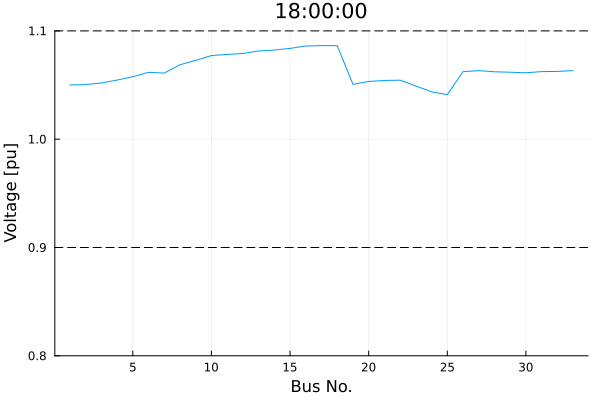

In [24]:

using Plots
plot(legend = false, ylims=(0.8, 1.1), xlabel="Bus No.", ylabel="Voltage [pu]", title="18:00:00")
plot!(1:33, value.(m2[:v]), label=false) 
hline!([1.1, 0.9], color=:black, linestyle=:dash, label= false)

# Display the plot
display(plot!())
# savefig(plot!(), "voltage_time_23.png")
#savefig(voltagetime00, "C:/Users/user/OneDrive - Rutgers University/Desktop/PHD- research/generationDataPlotnor.png")